In [ ]:
import json
import os

In [ ]:
with open('/home/oct/Gazeformer/dataset/coco_search18_TP_and_FV_fixations_train_512x320.json', 'r') as f:
    data1 = json.load(f)

# Load the second JSON file
with open('/home/oct/Gazeformer/dataset/coco_search18_TP_and_FV_fixations_val_512x320.json', 'r') as f:
    data2 = json.load(f)


In [ ]:
# 合并两个数据
combined_data = data1 + data2

# 根据 condition 字段分割数据
present_data = [entry for entry in combined_data if entry['condition'] == 'present']
freeview_data = [entry for entry in combined_data if entry['condition'] == 'freeview']

# 将分割后的数据写入新的 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_fixations_512x320.json', 'w') as f:
    json.dump(present_data, f, indent=4)

with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_FV_fixations_512x320.json', 'w') as f:
    json.dump(freeview_data, f, indent=4)

print(f"Number of entries in present_data: {len(present_data)}")
print(f"Number of entries in freeview_data: {len(freeview_data)}")

In [ ]:
# 创建一个新的列表来存储匹配的数据
matched_data = []

# 创建一个字典来加速查找freeview_data中的数据
freeview_dict = {(entry['name'], entry['subject'] - 100): entry for entry in freeview_data}
print(f"Number of entries in freeview_dict: {len(freeview_dict)}")

# 遍历present_data，查找匹配的freeview_data
for entry in present_data:
    key = (entry['name'], entry['subject'])
    
    if key in freeview_dict:
        freeview_entry = freeview_dict[key]
        matched_entry = {
            'name': entry['name'],
            'subject': entry['subject'],
            'TP_X': entry['X'],
            'TP_Y': entry['Y'],
            'TP_T': entry['T'],
            'FV_X': freeview_entry['X'],
            'FV_Y': freeview_entry['Y'],
            'FV_T': freeview_entry['T']
        }
        matched_data.append(matched_entry)

# 将匹配的数据写入新的JSON文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_matched_fixations_512x320.json', 'w') as f:
    json.dump(matched_data, f, indent=4)

print(f"Number of matched entries: {len(matched_data)}")


In [ ]:
# 读取 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_matched_fixations_512x320.json', 'r') as f:
    data = json.load(f)

# 定义图片文件夹路径
image_folder = '/home/oct/COCO_Search18-and-FV/images'

# 遍历 JSON 数据，查找对应的图片并添加 class 字段
for entry in data:
    image_name = entry['name']
    for root, dirs, files in os.walk(image_folder):
        if image_name in files:
            entry['class'] = os.path.basename(root)
            break

# 保存修改后的 JSON 数据到新的文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_matched_fixations_with_class_512x320.json', 'w') as f:
    json.dump(data, f, indent=4)

print("JSON 文件已成功更新并保存。")
print(f"总共的数据条数: {len(data)}")

In [4]:
from scipy.stats import ks_2samp

def ks_test(data1, data2):
    """
    对两组数据进行 Kolmogorov-Smirnov 检验，比较它们的分布是否有显著差异。

    参数:
    data1 (array-like): 第一组数据
    data2 (array-like): 第二组数据

    返回:
    tuple: (p-value, D statistic)
    """
    D_statistic, p_value = ks_2samp(data1, data2)
    return p_value, D_statistic



from scipy.stats import mannwhitneyu

def mann_whitney_u_test(data1, data2):
    """
    对两组数据进行 Mann-Whitney U 检验，比较它们的中位数是否有显著差异。

    参数:
    data1 (array-like): 第一组数据
    data2 (array-like): 第二组数据

    返回:
    tuple: (p-value, U statistic)
    """
    U_statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
    return p_value, U_statistic


from scipy.stats import chi2_contingency
import numpy as np

def chi_square_test(data1, data2, bins):
    """
    对两组数据的每个维度（x, y, t）分别进行卡方检验。

    参数:
    data1 (DataFrame): 第一组数据，包含 'x', 'y', 't' 列
    data2 (DataFrame): 第二组数据，包含 'x', 'y', 't' 列
    bins (dict): 离散化区间
    
    返回:
    tuple: (p-value, chi2 statistic)
    """
    hist1, _ = np.histogram(data1, bins=bins)
    hist2, _ = np.histogram(data2, bins=bins)
    # 执行卡方检验
    chi2_statistic, p_value, _, _ = chi2_contingency([hist1, hist2])

    return p_value, chi2_statistic



In [1]:
import json

# 读取 JSON 文件

with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_matched_fixations_with_class_512x320.json', 'r') as f:
    data = json.load(f)
    # 初始化数据结构
    dataTP_X, dataFV_X, dataTP_Y, dataFV_Y, dataTP_T, dataFV_T = [], [], [], [], [], []

    # 填充数据
    for entry in data:
        dataTP_X.extend(entry['TP_X'])
        dataFV_X.extend(entry['FV_X'])
        dataTP_Y.extend(entry['TP_Y'])
        dataFV_Y.extend(entry['FV_Y'])
        dataTP_T.extend(entry['TP_T'])
        dataFV_T.extend(entry['FV_T'])
        
# 按 class 分类数据
class_data = {}
for entry in data:
    class_name = entry['class']
    if class_name not in class_data:
        class_data[class_name] = {'TP_X': [], 'FV_X': [], 'TP_Y': [], 'FV_Y': [], 'TP_T': [], 'FV_T': []}
    class_data[class_name]['TP_X'].extend(entry['TP_X'])
    class_data[class_name]['FV_X'].extend(entry['FV_X'])
    class_data[class_name]['TP_Y'].extend(entry['TP_Y'])
    class_data[class_name]['FV_Y'].extend(entry['FV_Y'])
    class_data[class_name]['TP_T'].extend(entry['TP_T'])
    class_data[class_name]['FV_T'].extend(entry['FV_T'])

In [6]:
import numpy as np
# 定义离散化区间
bins = {'x': np.linspace(0, 512, 10), 'y': np.linspace(0, 320, 10), 't': np.linspace(0, 1000, 10)}

# 初始化结果字典
results = {
    'TP_X_vs_FV_X': {
        'ks_test': {'p-value': ks_test(dataTP_X, dataFV_X)[0], 'D statistic': ks_test(dataTP_X, dataFV_X)[1]},
        'mann_whitney_u_test': {'p-value': mann_whitney_u_test(dataTP_X, dataFV_X)[0], 'U statistic': mann_whitney_u_test(dataTP_X, dataFV_X)[1]},
        'chi_square_test': {'p-value': chi_square_test(dataTP_X, dataFV_X, bins['x'])[0], 'chi2 statistic': chi_square_test(dataTP_X, dataFV_X, bins['x'])[1]}
    },
    'TP_Y_vs_FV_Y': {
        'ks_test': {'p-value': ks_test(dataTP_Y, dataFV_Y)[0], 'D statistic': ks_test(dataTP_Y, dataFV_Y)[1]},
        'mann_whitney_u_test': {'p-value': mann_whitney_u_test(dataTP_Y, dataFV_Y)[0], 'U statistic': mann_whitney_u_test(dataTP_Y, dataFV_Y)[1]},
        'chi_square_test': {'p-value': chi_square_test(dataTP_Y, dataFV_Y, bins['y'])[0], 'chi2 statistic': chi_square_test(dataTP_Y, dataFV_Y, bins['y'])[1]}
    },
    'TP_T_vs_FV_T': {
        'ks_test': {'p-value': ks_test(dataTP_T, dataFV_T)[0], 'D statistic': ks_test(dataTP_T, dataFV_T)[1]},
        'mann_whitney_u_test': {'p-value': mann_whitney_u_test(dataTP_T, dataFV_T)[0], 'U statistic': mann_whitney_u_test(dataTP_T, dataFV_T)[1]},
        'chi_square_test': {'p-value': chi_square_test(dataTP_T, dataFV_T, bins['t'])[0], 'chi2 statistic': chi_square_test(dataTP_T, dataFV_T, bins['t'])[1]}
    }
}

# 将结果保存为 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/xyt_statistical_test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("检验结果已保存为JSON文件。")


检验结果已保存为JSON文件。


In [16]:
import pandas as pd

# 读取 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/classified_xyt_statistical_test_results.json', 'r') as f:
    results = json.load(f)

# 初始化数据结构
data = {'ks_test': [], 'mann_whitney_u_test': [], 'chi_square_test': []}

# 填充数据
for class_name, tests in results.items():
    for test_name in data.keys():
        for axis in ['TP_X_vs_FV_X', 'TP_Y_vs_FV_Y', 'TP_T_vs_FV_T']:
            p_value = tests[axis][test_name]['p-value']
            stat = tests[axis][test_name]['D statistic'] if test_name == 'ks_test' else tests[axis][test_name]['U statistic'] if test_name == 'mann_whitney_u_test' else tests[axis][test_name]['chi2 statistic']
            data[test_name].append([class_name, axis, p_value, stat])

# 转换为 DataFrame
df_kstest = pd.DataFrame(data['ks_test'], columns=['Class', 'Axis', 'p-value', 'Statistic'])
df_mannwhitney = pd.DataFrame(data['mann_whitney_u_test'], columns=['Class', 'Axis', 'p-value', 'Statistic'])
df_chisquare = pd.DataFrame(data['chi_square_test'], columns=['Class', 'Axis', 'p-value', 'Statistic'])

# 显示 DataFrame
print("KS-test Results:")
print(df_kstest.pivot(index='Class', columns='Axis', values=['p-value', 'Statistic']))

print("\nMann-Whitney U Test Results:")
print(df_mannwhitney.pivot(index='Class', columns='Axis', values=['p-value', 'Statistic']))

print("\nChi-Square Test Results:")
print(df_chisquare.pivot(index='Class', columns='Axis', values=['p-value', 'Statistic']))

KS-test Results:
                    p-value                                  Statistic  \
Axis           TP_T_vs_FV_T   TP_X_vs_FV_X   TP_Y_vs_FV_Y TP_T_vs_FV_T   
Class                                                                    
bottle         8.822910e-44   1.400612e-38   0.000000e+00     0.082987   
bowl           5.967058e-30   3.656649e-23  2.296346e-123     0.073444   
car            1.903477e-04   1.954322e-98   7.544021e-79     0.032215   
chair          4.669898e-31  3.087475e-124  6.847212e-280     0.058136   
clock          1.752854e-22   6.690716e-74  1.301843e-205     0.078332   
cup            2.103596e-71  1.355908e-141   0.000000e+00     0.071715   
fork          4.307641e-161  1.200947e-122  2.669436e-140     0.156170   
keyboard       2.903824e-17  1.423604e-103   0.000000e+00     0.052115   
knife         1.195281e-130  1.210507e-313  5.238382e-227     0.137580   
laptop         1.770350e-14  6.975118e-118   3.237293e-14     0.050891   
microwave      4.8998

In [3]:
import numpy as np
import os
#  初始化结果字典
results = {}

# 遍历每个 class 的数据
for class_name, values in class_data.items():
    
    # 计算 TP_T 和 FV_T 的均值和标准差
    tp_t_mean = np.mean(values['TP_T'])
    tp_t_std = np.std(values['TP_T'])
    fv_t_mean = np.mean(values['FV_T'])
    fv_t_std = np.std(values['FV_T'])
    
    # 保存结果
    results[class_name] = {
        'TP_T_mean': tp_t_mean,
        'TP_T_std': tp_t_std,
        'FV_T_mean': fv_t_mean,
        'FV_T_std': fv_t_std
    }

# 将结果保存为 JSON 文件
output_folder = '/home/oct/COCO_Search18-and-FV/dataset/'
output_file = os.path.join(output_folder, 'class_time_statistics.json')
with open(output_file, 'w') as f:
    json.dump(results, f, indent=4)

print("均值和标准差已计算并保存为JSON文件。")

均值和标准差已计算并保存为JSON文件。


图片已保存到 /home/oct/COCO_Search18-and-FV/dataset/time_comparison_boxplot.png


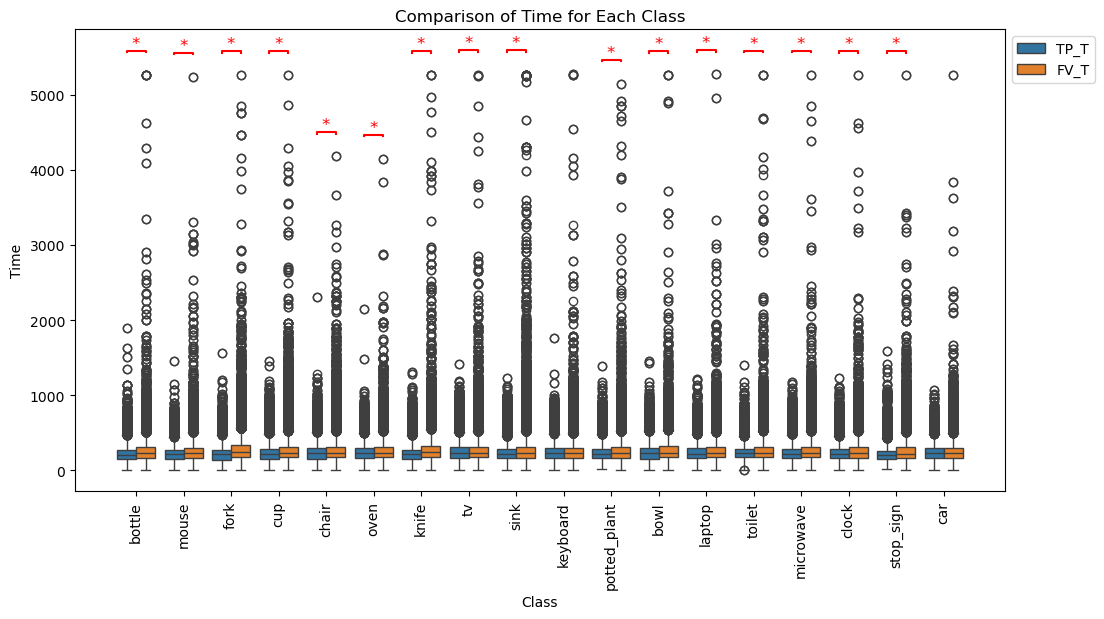

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import os

# 初始化数据结构
data = []

# 填充数据
for class_name, values in class_data.items():
    for tp_t in values['TP_T']:
        data.append({'Class': class_name, 'Condition': 'TP_T', 'Time': tp_t})
    for fv_t in values['FV_T']:
        data.append({'Class': class_name, 'Condition': 'FV_T', 'Time': fv_t})

# 转换为 DataFrame
df = pd.DataFrame(data)

# 绘制箱线图
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Class', y='Time', hue='Condition', data=df)
plt.xticks(rotation=90)
plt.title('Comparison of Time for Each Class')

# 移动图例到图外
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# 进行显著性差异检验并标注
for i, class_name in enumerate(class_data.keys()):
    tp_t = class_data[class_name]['TP_T']
    fv_t = class_data[class_name]['FV_T']
    _, p_value = mannwhitneyu(tp_t, fv_t, alternative='two-sided')
    if p_value < 0.05:
        y, h, col = max(max(tp_t), max(fv_t)) + 300, 20, 'red'
        plt.plot([i - 0.2, i - 0.2, i + 0.2, i + 0.2], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text(i, y + h, '*', ha='center', va='bottom', color=col, fontsize=12)


# 保存图片到指定文件夹
output_folder = '/home/oct/COCO_Search18-and-FV/dataset'
output_file = os.path.join(output_folder, 'time_comparison_boxplot.png')
plt.savefig(output_file, bbox_inches='tight')
print(f"图片已保存到 {output_file}")
plt.show()

In [1]:
import os
from PIL import Image

# 定义图片文件夹路径
image_folder = '/home/oct/COCO_Search18-and-FV/dataset/imgs'
output_folder = '/home/oct/COCO_Search18-and-FV/dataset/heat_compare'

# 创建输出文件夹
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 获取所有子文件夹
subfolders = [f.path for f in os.scandir(image_folder) if f.is_dir()]

# 遍历每个子文件夹
for subfolder in subfolders:
    # 获取子文件夹中的所有图片文件
    image_files = [f for f in os.listdir(subfolder) if f.endswith('.png')]
    
    # 找到TP和FV图片
    tp_image_file = next((f for f in image_files if 'TP' in f), None)
    fv_image_file = next((f for f in image_files if 'FV' in f), None)
    
    if tp_image_file and fv_image_file:
        # 读取图片
        tp_img_path = os.path.join(subfolder, tp_image_file)
        fv_img_path = os.path.join(subfolder, fv_image_file)
        tp_img = Image.open(tp_img_path)
        fv_img = Image.open(fv_img_path)
        
        # 创建新的图像，宽度为两张图片的宽度之和，高度为最大高度
        combined_width = tp_img.width + fv_img.width
        combined_height = max(tp_img.height, fv_img.height)
        combined_img = Image.new('RGBA', (combined_width, combined_height))
        
        # 将TP图片粘贴到左边，FV图片粘贴到右边
        combined_img.paste(tp_img, (0, 0))
        combined_img.paste(fv_img, (tp_img.width, 0))
        
        # 保存合成的图片
        subfolder_name = os.path.basename(subfolder)
        output_path = os.path.join(output_folder, f'{subfolder_name}_TP_vs_FV.png')
        combined_img.save(output_path)

print("图片已成功合成并保存。")

图片已成功合成并保存。


图片已保存到 /home/oct/COCO_Search18-and-FV/dataset/heatmap_TP_vs_FV.png


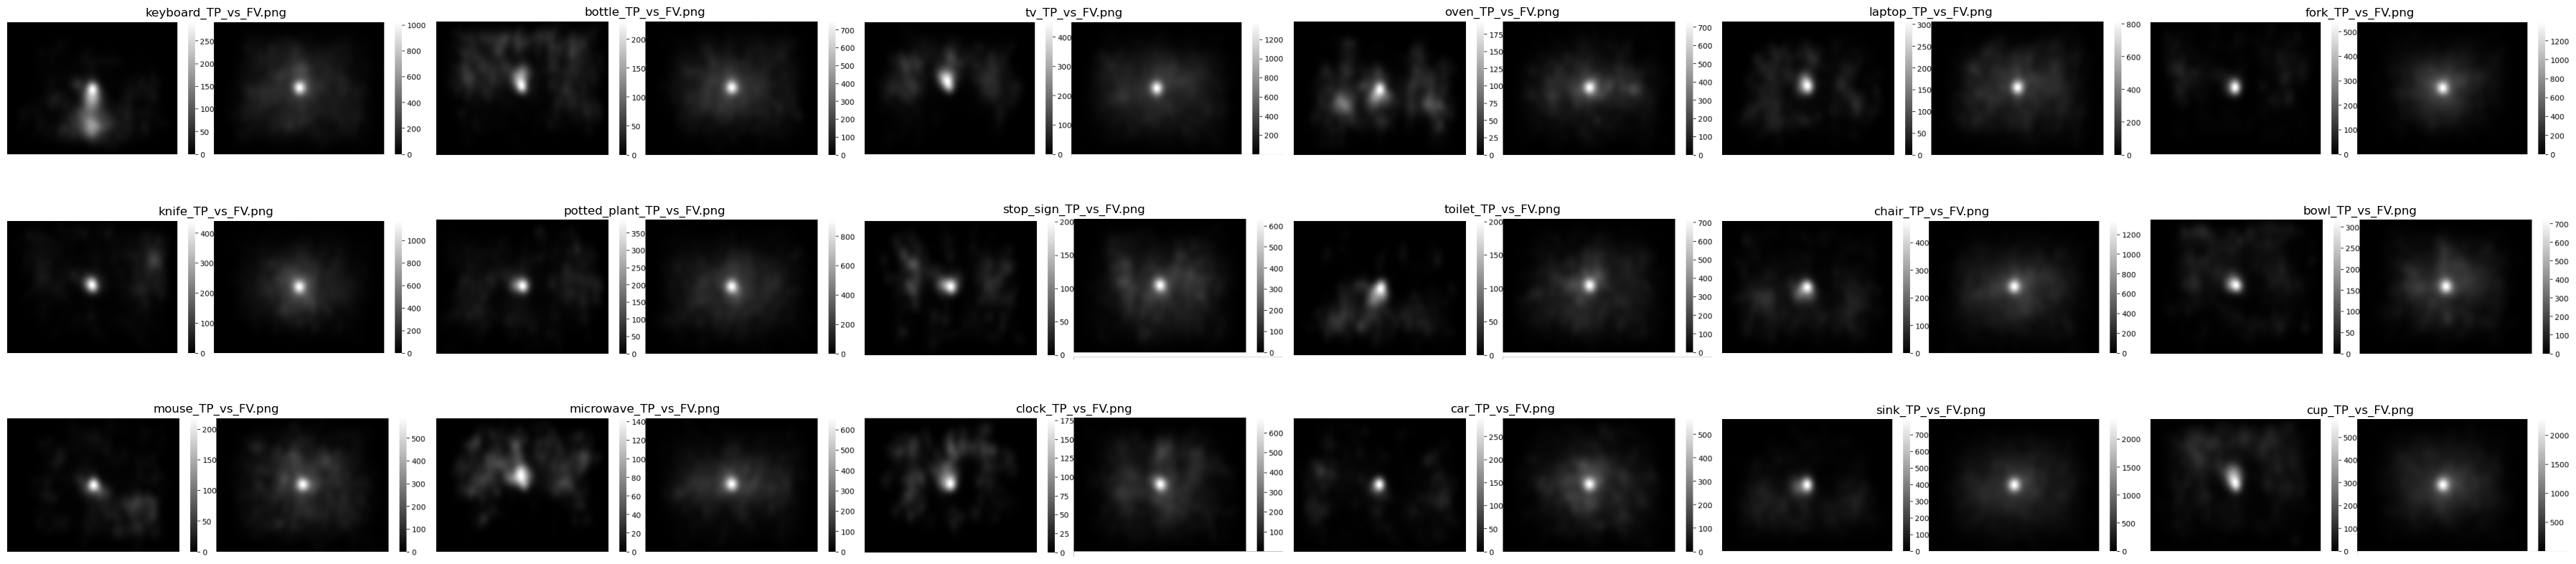

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 定义图片文件夹路径
image_folder = '/home/oct/COCO_Search18-and-FV/dataset/heat_compare'

# 获取所有图片文件
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# 设置图像显示的行数和列数
num_cols = 6  # 每行显示6个图片
num_rows = (len(image_files) + num_cols - 1) // num_cols  # 计算行数

# 创建一个新的图像，figsize根据图片数量自适应
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 3))

# 遍历每个图片文件
for i, image_file in enumerate(image_files):
    img_path = os.path.join(image_folder, image_file)
    img = Image.open(img_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"{image_file}")

# 移除多余的子图
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

# 调整布局，去掉上下行之间的空白间隙
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# 保存图片到指定文件夹
output_file = os.path.join('/home/oct/COCO_Search18-and-FV/dataset', 'heatmap_TP_vs_FV.png')
plt.savefig(output_file, bbox_inches='tight')
print(f"图片已保存到 {output_file}")

plt.show()


In [29]:
import numpy as np
from scipy.ndimage import gaussian_filter

def generate_heatmap(x, y, t, img_size=[512, 320], sigma=10):
    """
    生成热力图。

    参数:
    x (list or array): x 坐标数据
    y (list or array): y 坐标数据
    t (list or array): t 值数据
    img_size (tuple): 图片尺寸，默认为 (512, 320)
    sigma (int): 高斯滤波的标准差，默认为 10

    返回:
    heatmap (array): 生成的热力图
    """
    # 初始化热力图
    heatmap = np.zeros((img_size[1],img_size[0]))

    # 叠加 t 值到对应的 xy 位置
    for xi, yi, ti in zip(x, y, t):
        if 0 <= xi < img_size[0] and 0 <= yi < img_size[1]:
            # Ensure xi and yi are within bounds
            xi_int = int(xi)
            yi_int = int(yi)
            
            # Ensure within bounds after casting to integer
            if xi_int >= img_size[0] or yi_int >= img_size[1]:
                raise ValueError(f"Invalid coordinates after conversion: xi={xi_int}, yi={yi_int}")
            
            # Update heatmap
            heatmap[yi_int, xi_int] += ti
        #else:
        #    raise ValueError(f"Invalid coordinates: xi={xi}, yi={yi}")


    # 使用高斯滤波平滑热力图
    heatmap = gaussian_filter(heatmap, sigma=sigma)

    return heatmap




In [31]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 创建保存图片的主文件夹
output_folder = '/home/oct/COCO_Search18-and-FV/dataset/imgs'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 遍历每个 class 的数据
for class_name, values in class_data.items():
    # 创建对应的 class 子文件夹
    class_folder = os.path.join(output_folder, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    
    # 生成 TP 类数据的热力图
    tp_x = values['TP_X']
    tp_y = values['TP_Y']
    tp_t = values['TP_T']
    
    heatmap = generate_heatmap(tp_x, tp_y, tp_t, img_size=[512, 320], sigma=10)
    
    plt.figure(figsize=(5.12, 3.2), dpi=100)  # 设置图像大小为 512x320 像素
    sns.heatmap(heatmap, cmap='gray', cbar=True, xticklabels=False, yticklabels=False)
    plt.axis('off')  # 关闭坐标轴
    plt.savefig(os.path.join(class_folder, f'{class_name}_TP_heatmap.png'), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # 生成 FV 类数据的热力图
    fv_x = values['FV_X']
    fv_y = values['FV_Y']
    fv_t = values['FV_T']
    
    heatmap = generate_heatmap(fv_x, fv_y, fv_t, img_size=[512, 320], sigma=10)
    
    plt.figure(figsize=(5.12, 3.2), dpi=100)  # 设置图像大小为 512x320 像素
    sns.heatmap(heatmap, cmap='gray', cbar=True, xticklabels=False, yticklabels=False)
    plt.axis('off')  # 关闭坐标轴
    plt.savefig(os.path.join(class_folder, f'{class_name}_FV_heatmap.png'), bbox_inches='tight', pad_inches=0)
    plt.close()

print("热力图已生成并保存。")


热力图已生成并保存。


In [27]:
import path_sim as ps
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import json

In [29]:
import time

# 读取 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_matched_fixations_with_class_512x320.json', 'r') as f:
    data = json.load(f)

# 初始化进度条
total_entries = len(data)
start_time = time.time()

# 创建一个新的列表来存储分析结果
structured_results = []

def to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_serializable(v) for v in obj]
    else:
        return obj

for i, entry in enumerate(tqdm(data, desc="Processing entries", unit="entry", leave=False)):
    data1 = pd.DataFrame({'Start X': entry['FV_X'], 'Start Y': entry['FV_Y'], 'Duration ms': entry['FV_T']})
    data2 = pd.DataFrame({'Start X': entry['TP_X'], 'Start Y': entry['TP_Y'], 'Duration ms': entry['TP_T']})

    sp1 = ps.generateStructureArrayScanpath(data1)
    sp2 = ps.generateStructureArrayScanpath(data2)
    
    structured_results.append({
        'name': entry['name'],
        'subject': entry['subject'],
        'class': entry['class'],
        'FV': to_serializable(sp1),
        'TP': to_serializable(sp2)
    })

    elapsed_time = time.time() - start_time
    remaining_time = (elapsed_time / (i + 1)) * (total_entries - (i + 1))
    tqdm.write(f"Processed {i + 1}/{total_entries} entries. Estimated time remaining: {remaining_time:.2f} seconds.", end='\r')

# 保存结构化结果
save_path = '/home/oct/COCO_Search18-and-FV/dataset/structured_eye_data.json'
with open(save_path, 'w') as f:
    json.dump(structured_results, f, indent=4)

print("结构化眼动数据已成功保存。")



Processing entries:   0%|          | 31/43978 [00:00<05:19, 137.60entry/s]

Processing entries:   0%|          | 81/43978 [00:00<02:39, 275.44entry/s]

Processing entries:   0%|          | 206/43978 [00:00<01:37, 447.70entry/s]

Processing entries:   1%|          | 469/43978 [00:01<01:11, 604.49entry/s]

Processing entries:   1%|▏         | 607/43978 [00:01<01:06, 651.11entry/s]

Processing entries:   2%|▏         | 746/43978 [00:01<01:06, 653.74entry/s]

Processing entries:   2%|▏         | 880/43978 [00:01<01:06, 643.74entry/s]

Processing entries:   3%|▎         | 1154/43978 [00:02<01:04, 661.49entry/s]

Processing entries:   3%|▎         | 1457/43978 [00:02<01:01, 688.92entry/s]

Processing entries:   4%|▍         | 1805/43978 [00:03<01:07, 626.73entry/s]

Processing entries:   4%|▍         | 1935/43978 [00:03<01:08, 613.90entry/s]

Processing entries:   5%|▍         | 2075/43978 [00:03<01:04, 654.49entry/s]

Processing entries:   5%|▌         | 2206/43978 [00:03<01:05, 639.75entry/s]

Processing entries:   5%|▌         | 2271/43978 [00:03<01:12, 576.92entry/s]

Processing entries:   6%|▌         | 2529/43978 [00:04<01:07, 611.24entry/s]

Processing entries:   6%|▌         | 2652/43978 [00:04<01:08, 599.35entry/s]

Processing entries:   6%|▋         | 2787/43978 [00:04<01:04, 636.16entry/s]

Processing entries:   7%|▋         | 2922/43978 [00:04<01:04, 637.73entry/s]

Processing entries:   7%|▋         | 3066/43978 [00:05<01:00, 679.44entry/s]

Processing entries:   7%|▋         | 3209/43978 [00:05<01:01, 664.49entry/s]

Processing entries:   8%|▊         | 3343/43978 [00:05<01:06, 615.49entry/s]

Processing entries:   8%|▊         | 3420/43978 [00:05<01:01, 657.02entry/s]

Processing entries:   8%|▊         | 3563/43978 [00:05<01:02, 650.60entry/s]

Processing entries:   9%|▊         | 3845/43978 [00:06<01:03, 632.75entry/s]

Processing entries:   9%|▉         | 3982/43978 [00:06<01:04, 623.15entry/s]

Processing entries:   9%|▉         | 4063/43978 [00:06<00:59, 673.24entry/s]

Processing entries:  10%|▉         | 4213/43978 [00:06<00:58, 684.65entry/s]

Processing entries:  10%|▉         | 4356/43978 [00:07<00:59, 662.91entry/s]

Processing entries:  10%|█         | 4505/43978 [00:07<00:58, 672.09entry/s]

Processing entries:  11%|█         | 4645/43978 [00:07<00:59, 655.87entry/s]

Processing entries:  11%|█         | 4857/43978 [00:07<01:02, 624.31entry/s]

Processing entries:  11%|█▏        | 4988/43978 [00:08<01:01, 637.16entry/s]

Processing entries:  12%|█▏        | 5127/43978 [00:08<00:58, 663.87entry/s]

Processing entries:  12%|█▏        | 5194/43978 [00:08<01:02, 616.42entry/s]

Processing entries:  12%|█▏        | 5314/43978 [00:08<01:23, 460.77entry/s]

Processing entries:  12%|█▏        | 5382/43978 [00:08<01:15, 510.89entry/s]

Processing entries:  13%|█▎        | 5660/43978 [00:09<01:01, 624.01entry/s]

Processing entries:  13%|█▎        | 5804/43978 [00:09<00:57, 669.33entry/s]

Processing entries:  14%|█▎        | 5939/43978 [00:09<01:01, 614.98entry/s]

Processing entries:  14%|█▍        | 6070/43978 [00:09<01:03, 594.58entry/s]

Processing entries:  14%|█▍        | 6132/43978 [00:10<01:11, 527.18entry/s]

Processing entries:  14%|█▍        | 6239/43978 [00:10<01:15, 497.89entry/s]

Processing entries:  14%|█▍        | 6344/43978 [00:10<01:13, 510.28entry/s]

Processing entries:  15%|█▍        | 6447/43978 [00:10<01:15, 495.85entry/s]

Processing entries:  15%|█▍        | 6549/43978 [00:10<01:15, 498.01entry/s]

Processing entries:  15%|█▌        | 6614/43978 [00:11<01:09, 539.87entry/s]

Processing entries:  15%|█▌        | 6741/43978 [00:11<01:03, 585.67entry/s]

Processing entries:  16%|█▌        | 6858/43978 [00:11<01:07, 545.96entry/s]

Processing entries:  16%|█▌        | 6967/43978 [00:11<01:12, 507.65entry/s]

Processing entries:  16%|█▌        | 7093/43978 [00:11<01:11, 519.44entry/s]

Processing entries:  16%|█▋        | 7153/43978 [00:12<01:08, 538.94entry/s]

Processing entries:  17%|█▋        | 7263/43978 [00:12<01:09, 530.41entry/s]

Processing entries:  17%|█▋        | 7382/43978 [00:12<01:08, 534.88entry/s]

Processing entries:  17%|█▋        | 7493/43978 [00:12<01:09, 528.52entry/s]

Processing entries:  17%|█▋        | 7606/43978 [00:12<01:10, 515.40entry/s]

Processing entries:  18%|█▊        | 7724/43978 [00:13<01:10, 516.78entry/s]

Processing entries:  18%|█▊        | 7840/43978 [00:13<01:10, 512.96entry/s]

Processing entries:  18%|█▊        | 7900/43978 [00:13<01:07, 533.62entry/s]

Processing entries:  18%|█▊        | 8008/43978 [00:13<01:09, 520.02entry/s]

Processing entries:  18%|█▊        | 8123/43978 [00:13<01:08, 522.77entry/s]

Processing entries:  19%|█▊        | 8234/43978 [00:14<01:08, 523.01entry/s]

Processing entries:  19%|█▉        | 8357/43978 [00:14<01:02, 572.70entry/s]

Processing entries:  19%|█▉        | 8476/43978 [00:14<01:02, 569.72entry/s]

Processing entries:  20%|█▉        | 8589/43978 [00:14<01:05, 538.56entry/s]

Processing entries:  20%|█▉        | 8644/43978 [00:14<01:09, 507.56entry/s]

Processing entries:  20%|█▉        | 8746/43978 [00:15<01:17, 455.57entry/s]

Processing entries:  20%|██        | 8850/43978 [00:15<01:12, 484.99entry/s]

Processing entries:  20%|██        | 8958/43978 [00:15<01:08, 509.10entry/s]

Processing entries:  21%|██        | 9061/43978 [00:15<01:12, 480.16entry/s]

Processing entries:  21%|██        | 9173/43978 [00:15<01:08, 506.24entry/s]

Processing entries:  21%|██        | 9287/43978 [00:16<01:04, 533.81entry/s]

Processing entries:  21%|██▏       | 9355/43978 [00:16<01:00, 573.55entry/s]

Processing entries:  22%|██▏       | 9479/43978 [00:16<01:01, 560.24entry/s]

Processing entries:  23%|██▎       | 9941/43978 [00:17<01:05, 517.88entry/s]

Processing entries:  23%|██▎       | 10046/43978 [00:17<01:05, 514.83entry/s]

Processing entries:  23%|██▎       | 10110/43978 [00:17<01:01, 549.71entry/s]

Processing entries:  23%|██▎       | 10216/43978 [00:17<01:12, 467.96entry/s]

Processing entries:  23%|██▎       | 10327/43978 [00:18<01:05, 510.14entry/s]

Processing entries:  24%|██▎       | 10435/43978 [00:18<01:05, 512.03entry/s]

Processing entries:  24%|██▍       | 10549/43978 [00:18<01:02, 537.74entry/s]

Processing entries:  24%|██▍       | 10604/43978 [00:18<01:05, 508.96entry/s]

Processing entries:  24%|██▍       | 10703/43978 [00:18<01:12, 457.89entry/s]

Processing entries:  25%|██▍       | 10806/43978 [00:19<01:09, 477.82entry/s]

Processing entries:  25%|██▍       | 10912/43978 [00:19<01:07, 489.07entry/s]

Processing entries:  25%|██▌       | 11152/43978 [00:19<00:57, 566.52entry/s]

Processing entries:  26%|██▌       | 11265/43978 [00:19<01:00, 544.45entry/s]

Processing entries:  26%|██▌       | 11320/43978 [00:20<01:05, 500.71entry/s]

Processing entries:  26%|██▌       | 11433/43978 [00:20<01:41, 321.89entry/s]

Processing entries:  26%|██▌       | 11538/43978 [00:20<01:23, 389.19entry/s]

Processing entries:  26%|██▋       | 11650/43978 [00:20<01:10, 460.54entry/s]

Processing entries:  27%|██▋       | 11766/43978 [00:21<01:02, 515.93entry/s]

Processing entries:  27%|██▋       | 11983/43978 [00:21<01:02, 512.45entry/s]

Processing entries:  28%|██▊       | 12137/43978 [00:21<01:09, 461.14entry/s]

Processing entries:  28%|██▊       | 12247/43978 [00:22<01:05, 484.17entry/s]

Processing entries:  28%|██▊       | 12353/43978 [00:22<01:03, 501.92entry/s]

Processing entries:  28%|██▊       | 12472/43978 [00:22<00:57, 551.58entry/s]

Processing entries:  29%|██▊       | 12582/43978 [00:22<01:01, 514.16entry/s]

Processing entries:  29%|██▉       | 12810/43978 [00:23<00:58, 534.92entry/s]

Processing entries:  29%|██▉       | 12918/43978 [00:23<00:59, 523.15entry/s]

Processing entries:  30%|██▉       | 13070/43978 [00:23<00:48, 640.76entry/s]

Processing entries:  30%|██▉       | 13142/43978 [00:23<00:46, 661.22entry/s]

Processing entries:  30%|███       | 13269/43978 [00:23<00:56, 547.70entry/s]

Processing entries:  31%|███       | 13446/43978 [00:24<00:59, 510.28entry/s]

Processing entries:  31%|███       | 13554/43978 [00:24<01:01, 497.70entry/s]

Processing entries:  31%|███       | 13670/43978 [00:24<00:58, 518.42entry/s]

Processing entries:  31%|███▏      | 13784/43978 [00:25<00:58, 512.37entry/s]

Processing entries:  32%|███▏      | 14073/43978 [00:25<00:57, 521.44entry/s]

Processing entries:  32%|███▏      | 14188/43978 [00:25<00:54, 544.04entry/s]

Processing entries:  33%|███▎      | 14299/43978 [00:26<00:54, 542.21entry/s]

Processing entries:  33%|███▎      | 14645/43978 [00:26<00:52, 560.92entry/s]

Processing entries:  34%|███▎      | 14757/43978 [00:26<00:55, 527.82entry/s]

Processing entries:  34%|███▍      | 14934/43978 [00:27<00:53, 547.42entry/s]

Processing entries:  34%|███▍      | 15042/43978 [00:27<00:57, 501.74entry/s]

Processing entries:  34%|███▍      | 15151/43978 [00:27<00:56, 514.06entry/s]

Processing entries:  35%|███▍      | 15253/43978 [00:27<00:58, 491.12entry/s]

Processing entries:  35%|███▌      | 15410/43978 [00:28<01:00, 474.89entry/s]

Processing entries:  35%|███▌      | 15521/43978 [00:28<00:59, 476.90entry/s]

Processing entries:  36%|███▌      | 15618/43978 [00:28<01:01, 464.60entry/s]

Processing entries:  36%|███▌      | 15722/43978 [00:28<01:01, 458.87entry/s]

Processing entries:  36%|███▌      | 15835/43978 [00:29<00:54, 517.60entry/s]

Processing entries:  36%|███▋      | 15947/43978 [00:29<00:53, 521.39entry/s]

Processing entries:  37%|███▋      | 16102/43978 [00:29<01:01, 455.17entry/s]

Processing entries:  37%|███▋      | 16205/43978 [00:29<01:01, 453.21entry/s]

Processing entries:  37%|███▋      | 16300/43978 [00:30<01:03, 438.75entry/s]

Processing entries:  37%|███▋      | 16403/43978 [00:30<00:59, 466.05entry/s]

Processing entries:  38%|███▊      | 16512/43978 [00:30<00:55, 490.85entry/s]

Processing entries:  38%|███▊      | 16575/43978 [00:30<00:51, 528.79entry/s]

Processing entries:  38%|███▊      | 16680/43978 [00:30<00:54, 499.40entry/s]

Processing entries:  38%|███▊      | 16807/43978 [00:31<00:52, 518.34entry/s]

Processing entries:  38%|███▊      | 16923/43978 [00:31<00:49, 549.05entry/s]

Processing entries:  39%|███▊      | 17032/43978 [00:31<00:52, 515.24entry/s]

Processing entries:  39%|███▉      | 17246/43978 [00:31<00:52, 509.85entry/s]

Processing entries:  40%|███▉      | 17458/43978 [00:32<00:52, 501.36entry/s]

Processing entries:  40%|███▉      | 17514/43978 [00:32<00:51, 514.49entry/s]

Processing entries:  40%|████      | 17626/43978 [00:32<00:50, 522.30entry/s]

Processing entries:  40%|████      | 17733/43978 [00:32<00:51, 508.73entry/s]

Processing entries:  41%|████      | 17835/43978 [00:33<00:52, 493.47entry/s]

Processing entries:  41%|████      | 17947/43978 [00:33<00:51, 509.48entry/s]

Processing entries:  41%|████      | 18068/43978 [00:33<00:46, 561.12entry/s]

Processing entries:  41%|████▏     | 18228/43978 [00:33<00:55, 467.24entry/s]

Processing entries:  42%|████▏     | 18334/43978 [00:34<00:53, 478.14entry/s]

Processing entries:  42%|████▏     | 18453/43978 [00:34<00:48, 528.50entry/s]

Processing entries:  42%|████▏     | 18572/43978 [00:34<00:45, 558.79entry/s]

Processing entries:  42%|████▏     | 18689/43978 [00:34<00:47, 537.47entry/s]

Processing entries:  43%|████▎     | 18744/43978 [00:34<00:49, 507.61entry/s]

Processing entries:  43%|████▎     | 18968/43978 [00:35<00:54, 455.54entry/s]

Processing entries:  43%|████▎     | 19082/43978 [00:35<00:49, 501.25entry/s]

Processing entries:  44%|████▎     | 19188/43978 [00:35<00:50, 491.35entry/s]

Processing entries:  44%|████▍     | 19303/43978 [00:36<00:46, 534.45entry/s]

Processing entries:  44%|████▍     | 19413/43978 [00:36<00:45, 537.18entry/s]

Processing entries:  44%|████▍     | 19520/43978 [00:36<00:50, 485.44entry/s]

Processing entries:  45%|████▍     | 19622/43978 [00:36<00:51, 475.84entry/s]

Processing entries:  45%|████▍     | 19671/43978 [00:36<00:53, 456.50entry/s]

Processing entries:  45%|████▍     | 19783/43978 [00:37<00:47, 507.48entry/s]

Processing entries:  45%|████▌     | 19901/43978 [00:37<00:49, 489.97entry/s]

Processing entries:  46%|████▌     | 20133/43978 [00:37<00:45, 520.06entry/s]

Processing entries:  46%|████▌     | 20242/43978 [00:37<00:45, 517.58entry/s]

Processing entries:  46%|████▋     | 20355/43978 [00:38<00:44, 533.94entry/s]

Processing entries:  46%|████▋     | 20409/43978 [00:38<00:47, 492.88entry/s]

Processing entries:  47%|████▋     | 20521/43978 [00:38<00:45, 517.10entry/s]

Processing entries:  47%|████▋     | 20628/43978 [00:38<00:44, 520.27entry/s]

Processing entries:  47%|████▋     | 20742/43978 [00:38<00:44, 521.98entry/s]

Processing entries:  47%|████▋     | 20848/43978 [00:39<00:45, 505.09entry/s]

Processing entries:  48%|████▊     | 20959/43978 [00:39<00:45, 510.30entry/s]

Processing entries:  48%|████▊     | 21016/43978 [00:39<00:43, 526.84entry/s]

Processing entries:  48%|████▊     | 21230/43978 [00:39<00:47, 478.30entry/s]

Processing entries:  49%|████▊     | 21345/43978 [00:40<00:43, 516.93entry/s]

Processing entries:  49%|████▉     | 21588/43978 [00:40<00:38, 580.77entry/s]

Processing entries:  49%|████▉     | 21706/43978 [00:40<00:41, 542.69entry/s]

Processing entries:  50%|████▉     | 21818/43978 [00:40<00:40, 540.71entry/s]

Processing entries:  50%|████▉     | 21873/43978 [00:41<00:41, 531.86entry/s]

Processing entries:  50%|████▉     | 21979/43978 [00:41<00:42, 512.90entry/s]

Processing entries:  50%|█████     | 22201/43978 [00:41<00:43, 500.33entry/s]

Processing entries:  51%|█████     | 22315/43978 [00:41<00:40, 530.50entry/s]

Processing entries:  51%|█████     | 22435/43978 [00:42<00:38, 561.82entry/s]

Processing entries:  51%|█████▏    | 22547/43978 [00:42<00:40, 523.94entry/s]

Processing entries:  51%|█████▏    | 22600/43978 [00:42<00:42, 497.27entry/s]

Processing entries:  52%|█████▏    | 22716/43978 [00:42<00:42, 497.53entry/s]

Processing entries:  52%|█████▏    | 22933/43978 [00:43<00:43, 480.28entry/s]

Processing entries:  52%|█████▏    | 23042/43978 [00:43<00:41, 505.34entry/s]

Processing entries:  53%|█████▎    | 23156/43978 [00:43<00:41, 498.54entry/s]

Processing entries:  53%|█████▎    | 23213/43978 [00:43<00:40, 517.42entry/s]

Processing entries:  53%|█████▎    | 23316/43978 [00:43<00:42, 485.86entry/s]

Processing entries:  54%|█████▎    | 23531/43978 [00:44<00:39, 522.31entry/s]

Processing entries:  54%|█████▍    | 23655/43978 [00:44<00:35, 564.73entry/s]

Processing entries:  54%|█████▍    | 23767/43978 [00:44<00:37, 535.61entry/s]

Processing entries:  54%|█████▍    | 23878/43978 [00:44<00:37, 529.44entry/s]

Processing entries:  55%|█████▍    | 23998/43978 [00:45<00:36, 545.26entry/s]

Processing entries:  55%|█████▍    | 24072/43978 [00:45<00:33, 598.74entry/s]

Processing entries:  55%|█████▌    | 24189/43978 [00:45<00:36, 540.18entry/s]

Processing entries:  55%|█████▌    | 24294/43978 [00:45<00:43, 449.72entry/s]

Processing entries:  55%|█████▌    | 24394/43978 [00:45<00:41, 470.54entry/s]

Processing entries:  56%|█████▌    | 24506/43978 [00:46<00:38, 512.02entry/s]

Processing entries:  56%|█████▌    | 24619/43978 [00:46<00:36, 535.50entry/s]

Processing entries:  56%|█████▌    | 24730/43978 [00:46<00:35, 538.55entry/s]

Processing entries:  56%|█████▋    | 24788/43978 [00:46<00:34, 548.36entry/s]

Processing entries:  57%|█████▋    | 24899/43978 [00:46<00:36, 518.61entry/s]

Processing entries:  57%|█████▋    | 25224/43978 [00:47<00:36, 508.31entry/s]

Processing entries:  58%|█████▊    | 25337/43978 [00:47<00:36, 506.55entry/s]

Processing entries:  58%|█████▊    | 25452/43978 [00:47<00:35, 527.32entry/s]

Processing entries:  58%|█████▊    | 25689/43978 [00:48<00:31, 581.26entry/s]

Processing entries:  59%|█████▊    | 25748/43978 [00:48<00:35, 508.52entry/s]

Processing entries:  59%|█████▉    | 25858/43978 [00:48<00:38, 476.01entry/s]

Processing entries:  59%|█████▉    | 25966/43978 [00:48<00:35, 501.60entry/s]

Processing entries:  59%|█████▉    | 26078/43978 [00:49<00:35, 506.42entry/s]

Processing entries:  59%|█████▉    | 26130/43978 [00:49<00:35, 506.12entry/s]

Processing entries:  60%|█████▉    | 26244/43978 [00:49<00:34, 508.19entry/s]

Processing entries:  60%|█████▉    | 26353/43978 [00:49<00:36, 482.88entry/s]

Processing entries:  60%|██████    | 26454/43978 [00:49<00:36, 479.19entry/s]

Processing entries:  60%|██████    | 26552/43978 [00:50<00:36, 474.15entry/s]

Processing entries:  61%|██████    | 26666/43978 [00:50<00:34, 494.99entry/s]

Processing entries:  61%|██████    | 26767/43978 [00:50<00:34, 494.13entry/s]

Processing entries:  61%|██████    | 26880/43978 [00:50<00:32, 521.90entry/s]

Processing entries:  61%|██████▏   | 27000/43978 [00:50<00:31, 542.80entry/s]

Processing entries:  62%|██████▏   | 27055/43978 [00:51<00:31, 533.23entry/s]

Processing entries:  62%|██████▏   | 27168/43978 [00:51<00:31, 528.37entry/s]

Processing entries:  62%|██████▏   | 27286/43978 [00:51<00:32, 510.76entry/s]

Processing entries:  62%|██████▏   | 27411/43978 [00:51<00:32, 506.72entry/s]

Processing entries:  63%|██████▎   | 27527/43978 [00:52<00:30, 532.59entry/s]

Processing entries:  63%|██████▎   | 27585/43978 [00:52<00:30, 545.06entry/s]

Processing entries:  63%|██████▎   | 27702/43978 [00:52<00:29, 544.82entry/s]

Processing entries:  63%|██████▎   | 27758/43978 [00:52<00:31, 509.33entry/s]

Processing entries:  64%|██████▎   | 27979/43978 [00:53<00:36, 443.72entry/s]

Processing entries:  64%|██████▍   | 28083/43978 [00:53<00:34, 454.68entry/s]

Processing entries:  64%|██████▍   | 28197/43978 [00:53<00:32, 482.95entry/s]

Processing entries:  64%|██████▍   | 28248/43978 [00:53<00:34, 456.70entry/s]

Processing entries:  64%|██████▍   | 28351/43978 [00:53<00:32, 480.08entry/s]

Processing entries:  65%|██████▍   | 28571/43978 [00:54<00:30, 499.99entry/s]

Processing entries:  65%|██████▌   | 28683/43978 [00:54<00:29, 517.26entry/s]

Processing entries:  65%|██████▌   | 28788/43978 [00:54<00:31, 478.31entry/s]

Processing entries:  66%|██████▌   | 28837/43978 [00:54<00:33, 458.63entry/s]

Processing entries:  66%|██████▌   | 29134/43978 [00:55<00:31, 466.73entry/s]

Processing entries:  66%|██████▋   | 29235/43978 [00:55<00:31, 471.23entry/s]

Processing entries:  67%|██████▋   | 29339/43978 [00:55<00:29, 489.48entry/s]

Processing entries:  67%|██████▋   | 29454/43978 [00:56<00:27, 531.11entry/s]

Processing entries:  67%|██████▋   | 29571/43978 [00:56<00:25, 554.18entry/s]

Processing entries:  68%|██████▊   | 29852/43978 [00:56<00:29, 485.13entry/s]

Processing entries:  68%|██████▊   | 29965/43978 [00:57<00:27, 508.08entry/s]

Processing entries:  68%|██████▊   | 30078/43978 [00:57<00:25, 535.02entry/s]

Processing entries:  69%|██████▊   | 30188/43978 [00:57<00:25, 540.69entry/s]

Processing entries:  69%|██████▉   | 30302/43978 [00:57<00:24, 553.67entry/s]

Processing entries:  69%|██████▉   | 30409/43978 [00:57<00:28, 467.97entry/s]

Processing entries:  70%|██████▉   | 30699/43978 [00:58<00:24, 541.62entry/s]

Processing entries:  70%|███████   | 30821/43978 [00:58<00:24, 539.53entry/s]

Processing entries:  70%|███████   | 30935/43978 [00:58<00:24, 527.96entry/s]

Processing entries:  71%|███████   | 31052/43978 [00:59<00:23, 550.30entry/s]

Processing entries:  71%|███████   | 31168/43978 [00:59<00:22, 559.60entry/s]

Processing entries:  71%|███████   | 31286/43978 [00:59<00:22, 561.19entry/s]

Processing entries:  71%|███████▏  | 31407/43978 [00:59<00:22, 560.45entry/s]

Processing entries:  72%|███████▏  | 31529/43978 [00:59<00:21, 583.07entry/s]

Processing entries:  72%|███████▏  | 31588/43978 [01:00<00:21, 567.45entry/s]

Processing entries:  72%|███████▏  | 31710/43978 [01:00<00:22, 552.19entry/s]

Processing entries:  72%|███████▏  | 31823/43978 [01:00<00:22, 539.42entry/s]

Processing entries:  73%|███████▎  | 31943/43978 [01:00<00:23, 513.11entry/s]

Processing entries:  73%|███████▎  | 32067/43978 [01:00<00:21, 543.86entry/s]

Processing entries:  73%|███████▎  | 32179/43978 [01:01<00:21, 546.65entry/s]

Processing entries:  74%|███████▎  | 32346/43978 [01:01<00:22, 518.31entry/s]

Processing entries:  74%|███████▍  | 32461/43978 [01:01<00:21, 544.61entry/s]

Processing entries:  74%|███████▍  | 32578/43978 [01:01<00:22, 517.40entry/s]

Processing entries:  75%|███████▍  | 32806/43978 [01:02<00:22, 505.83entry/s]

Processing entries:  75%|███████▍  | 32867/43978 [01:02<00:20, 533.87entry/s]

Processing entries:  75%|███████▍  | 32982/43978 [01:02<00:20, 537.41entry/s]

Processing entries:  75%|███████▌  | 33100/43978 [01:02<00:20, 531.26entry/s]

Processing entries:  76%|███████▌  | 33211/43978 [01:03<00:21, 510.24entry/s]

Processing entries:  76%|███████▌  | 33517/43978 [01:03<00:19, 541.13entry/s]

Processing entries:  76%|███████▋  | 33633/43978 [01:04<00:19, 537.95entry/s]

Processing entries:  77%|███████▋  | 33848/43978 [01:04<00:19, 511.67entry/s]

Processing entries:  77%|███████▋  | 33956/43978 [01:04<00:19, 522.11entry/s]

Processing entries:  78%|███████▊  | 34174/43978 [01:05<00:18, 522.97entry/s]

Processing entries:  78%|███████▊  | 34380/43978 [01:05<00:19, 491.82entry/s]

Processing entries:  78%|███████▊  | 34441/43978 [01:05<00:18, 524.03entry/s]

Processing entries:  79%|███████▊  | 34548/43978 [01:05<00:19, 487.98entry/s]

Processing entries:  79%|███████▉  | 34660/43978 [01:06<00:18, 495.33entry/s]

Processing entries:  79%|███████▉  | 34895/43978 [01:06<00:17, 533.33entry/s]

Processing entries:  79%|███████▉  | 34950/43978 [01:06<00:16, 536.62entry/s]

Processing entries:  80%|████████  | 35294/43978 [01:07<00:16, 532.78entry/s]

Processing entries:  81%|████████  | 35413/43978 [01:07<00:15, 564.19entry/s]

Processing entries:  81%|████████  | 35607/43978 [01:07<00:15, 543.29entry/s]

Processing entries:  81%|████████  | 35715/43978 [01:08<00:16, 502.28entry/s]

Processing entries:  81%|████████▏ | 35817/43978 [01:08<00:17, 466.22entry/s]

Processing entries:  82%|████████▏ | 35926/43978 [01:08<00:17, 470.93entry/s]

Processing entries:  82%|████████▏ | 36100/43978 [01:08<00:15, 513.94entry/s]

Processing entries:  82%|████████▏ | 36208/43978 [01:09<00:15, 509.66entry/s]

Processing entries:  83%|████████▎ | 36329/43978 [01:09<00:14, 536.07entry/s]

Processing entries:  83%|████████▎ | 36571/43978 [01:09<00:13, 553.37entry/s]

Processing entries:  83%|████████▎ | 36691/43978 [01:09<00:13, 533.49entry/s]

Processing entries:  84%|████████▎ | 36762/43978 [01:10<00:12, 578.74entry/s]

Processing entries:  84%|████████▍ | 36893/43978 [01:10<00:11, 591.06entry/s]

Processing entries:  84%|████████▍ | 37012/43978 [01:10<00:12, 557.23entry/s]

Processing entries:  84%|████████▍ | 37128/43978 [01:10<00:12, 549.40entry/s]

Processing entries:  85%|████████▍ | 37250/43978 [01:10<00:11, 563.59entry/s]

Processing entries:  85%|████████▍ | 37372/43978 [01:11<00:12, 547.42entry/s]

Processing entries:  85%|████████▌ | 37554/43978 [01:11<00:10, 588.09entry/s]

Processing entries:  86%|████████▌ | 37671/43978 [01:11<00:11, 549.69entry/s]

Processing entries:  86%|████████▌ | 37921/43978 [01:12<00:11, 533.56entry/s]

Processing entries:  86%|████████▋ | 38040/43978 [01:12<00:10, 540.53entry/s]

Processing entries:  87%|████████▋ | 38101/43978 [01:12<00:10, 555.48entry/s]

Processing entries:  87%|████████▋ | 38217/43978 [01:12<00:10, 548.22entry/s]

Processing entries:  87%|████████▋ | 38273/43978 [01:12<00:10, 522.06entry/s]

Processing entries:  87%|████████▋ | 38419/43978 [01:13<00:13, 402.21entry/s]

Processing entries:  88%|████████▊ | 38562/43978 [01:13<00:10, 510.09entry/s]

Processing entries:  88%|████████▊ | 38798/43978 [01:13<00:10, 508.21entry/s]

Processing entries:  88%|████████▊ | 38852/43978 [01:14<00:10, 486.47entry/s]

Processing entries:  89%|████████▉ | 39080/43978 [01:14<00:08, 544.90entry/s]

Processing entries:  89%|████████▉ | 39192/43978 [01:14<00:09, 517.03entry/s]

Processing entries:  89%|████████▉ | 39320/43978 [01:14<00:08, 542.38entry/s]

Processing entries:  90%|████████▉ | 39444/43978 [01:15<00:08, 532.87entry/s]

Processing entries:  90%|█████████ | 39582/43978 [01:15<00:07, 606.98entry/s]

Processing entries:  90%|█████████ | 39644/43978 [01:15<00:08, 535.94entry/s]

Processing entries:  90%|█████████ | 39763/43978 [01:15<00:07, 535.43entry/s]

Processing entries:  91%|█████████ | 39871/43978 [01:15<00:07, 515.31entry/s]

Processing entries:  91%|█████████ | 39986/43978 [01:16<00:07, 543.08entry/s]

Processing entries:  91%|█████████ | 40105/43978 [01:16<00:07, 547.97entry/s]

Processing entries:  91%|█████████▏| 40224/43978 [01:16<00:06, 563.00entry/s]

Processing entries:  92%|█████████▏| 40337/43978 [01:16<00:06, 543.93entry/s]

Processing entries:  92%|█████████▏| 40399/43978 [01:16<00:06, 564.45entry/s]

Processing entries:  92%|█████████▏| 40630/43978 [01:17<00:06, 547.72entry/s]

Processing entries:  93%|█████████▎| 40746/43978 [01:17<00:05, 539.66entry/s]

Processing entries:  93%|█████████▎| 40871/43978 [01:17<00:05, 561.58entry/s]

Processing entries:  93%|█████████▎| 41051/43978 [01:18<00:05, 537.34entry/s]

Processing entries:  94%|█████████▍| 41277/43978 [01:18<00:04, 547.11entry/s]

Processing entries:  94%|█████████▍| 41499/43978 [01:18<00:04, 537.49entry/s]

Processing entries:  95%|█████████▍| 41611/43978 [01:19<00:04, 533.67entry/s]

Processing entries:  95%|█████████▍| 41724/43978 [01:19<00:04, 549.71entry/s]

Processing entries:  95%|█████████▌| 41849/43978 [01:19<00:03, 578.76entry/s]

Processing entries:  95%|█████████▌| 41908/43978 [01:19<00:03, 537.13entry/s]

Processing entries:  96%|█████████▌| 42025/43978 [01:19<00:03, 517.51entry/s]

Processing entries:  96%|█████████▌| 42147/43978 [01:20<00:03, 561.48entry/s]

Processing entries:  96%|█████████▌| 42261/43978 [01:20<00:03, 535.76entry/s]

Processing entries:  96%|█████████▋| 42370/43978 [01:20<00:03, 523.07entry/s]

Processing entries:  97%|█████████▋| 42487/43978 [01:20<00:02, 542.63entry/s]

Processing entries:  97%|█████████▋| 42617/43978 [01:20<00:02, 598.43entry/s]

Processing entries:  97%|█████████▋| 42742/43978 [01:21<00:02, 571.46entry/s]

Processing entries:  98%|█████████▊| 42922/43978 [01:21<00:02, 524.02entry/s]

Processing entries:  98%|█████████▊| 43030/43978 [01:21<00:01, 512.59entry/s]

Processing entries:  98%|█████████▊| 43140/43978 [01:21<00:01, 518.28entry/s]

Processing entries:  98%|█████████▊| 43266/43978 [01:22<00:01, 530.12entry/s]

Processing entries:  99%|█████████▊| 43325/43978 [01:22<00:01, 545.83entry/s]

Processing entries:  99%|█████████▉| 43437/43978 [01:22<00:01, 536.06entry/s]

Processing entries:  99%|█████████▉| 43553/43978 [01:22<00:00, 543.18entry/s]

Processing entries: 100%|█████████▉| 43790/43978 [01:23<00:00, 538.62entry/s]

Processing entries: 100%|█████████▉| 43908/43978 [01:23<00:00, 557.55entry/s]

结构化眼动数据已成功保存。78/43978 entries. Estimated time remaining: 0.00 seconds.


In [30]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# 设置样式
sns.set(style="whitegrid", font_scale=1.2)

# 读取结构化数据
with open('/home/oct/COCO_Search18-and-FV/dataset/structured_eye_data.json', 'r') as f:
    structured_data = json.load(f)

# 初始化
fv_fix_x, fv_fix_y, fv_dur, fv_sac_len, fv_sac_theta, fv_sac_dx, fv_sac_dy = [], [], [], [], [], [], []
tp_fix_x, tp_fix_y, tp_dur, tp_sac_len, tp_sac_theta, tp_sac_dx, tp_sac_dy = [], [], [], [], [], [], []

for entry in structured_data:
    fv = entry['FV']
    tp = entry['TP']

    fv_fix_x += fv['fixation']['x']
    fv_fix_y += fv['fixation']['y']
    fv_dur += fv['fixation']['dur']
    fv_sac_len += fv['saccade']['len']
    fv_sac_theta += fv['saccade']['theta']
    fv_sac_dx += fv['saccade']['lenx']
    fv_sac_dy += fv['saccade']['leny']

    tp_fix_x += tp['fixation']['x']
    tp_fix_y += tp['fixation']['y']
    tp_dur += tp['fixation']['dur']
    tp_sac_len += tp['saccade']['len']
    tp_sac_theta += tp['saccade']['theta']
    tp_sac_dx += tp['saccade']['lenx']
    tp_sac_dy += tp['saccade']['leny']



In [72]:
def plot_xy_scatter_with_marginals(
    x1, y1, x2, y2,
    label1='FV', label2='SE',
    xlabel='X', ylabel='Y', title='',
    xlim=None, ylim=None
):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(4, 4)

    ax_main = plt.subplot(gs[1:4, 0:3])
    ax_xhist = plt.subplot(gs[0, 0:3], sharex=ax_main)
    ax_yhist = plt.subplot(gs[1:4, 3], sharey=ax_main)

    # 主图（XY散点）
    ax_main.scatter(x1, y1, s=10, alpha=0.5, label=label1, color='tab:green')
    ax_main.scatter(x2, y2, s=10, alpha=0.5, label=label2, color='orange')
    ax_main.legend()
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    ax_main.set_title(title)

    # 设置坐标范围
    if xlim is not None:
        ax_main.set_xlim(xlim)
    if ylim is not None:
        ax_main.set_ylim(ylim)

    # 上侧直方图
    bins = 50
    ax_xhist.hist(x1, bins=bins, density=True, alpha=0.5, color='tab:green')
    ax_xhist.hist(x2, bins=bins, density=True, alpha=0.5, color='orange')
    ax_xhist.axis('off')

    # 右侧直方图
    ax_yhist.hist(y1, bins=bins, density=True, alpha=0.5, orientation='horizontal', color='tab:green')
    ax_yhist.hist(y2, bins=bins, density=True, alpha=0.5, orientation='horizontal', color='orange')
    ax_yhist.axis('off')

    plt.tight_layout()
    plt.show()



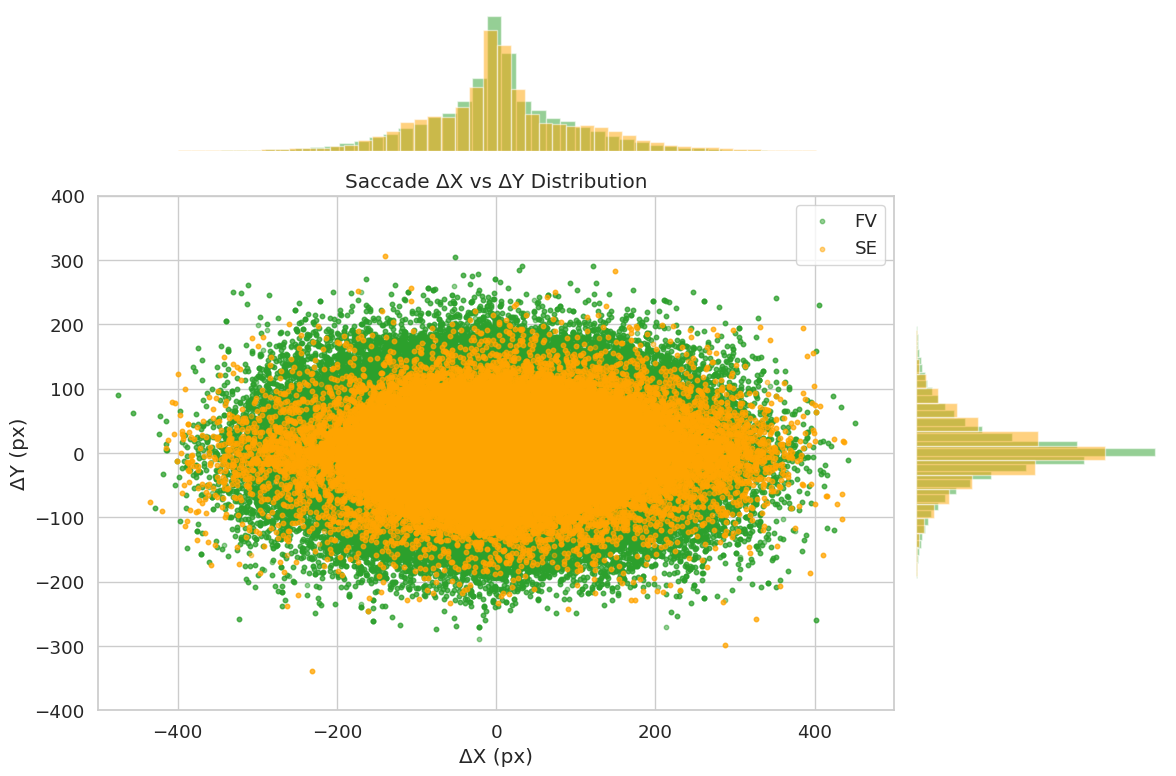

In [73]:
plot_xy_scatter_with_marginals(
    fv_sac_dx, fv_sac_dy,
    tp_sac_dx, tp_sac_dy,
    xlabel='ΔX (px)', ylabel='ΔY (px)',
    title='Saccade ΔX vs ΔY Distribution',
    xlim=(-500, 500), ylim=(-400, 400)
)


/tmp/ipykernel_907851/4229362057.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/oct/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


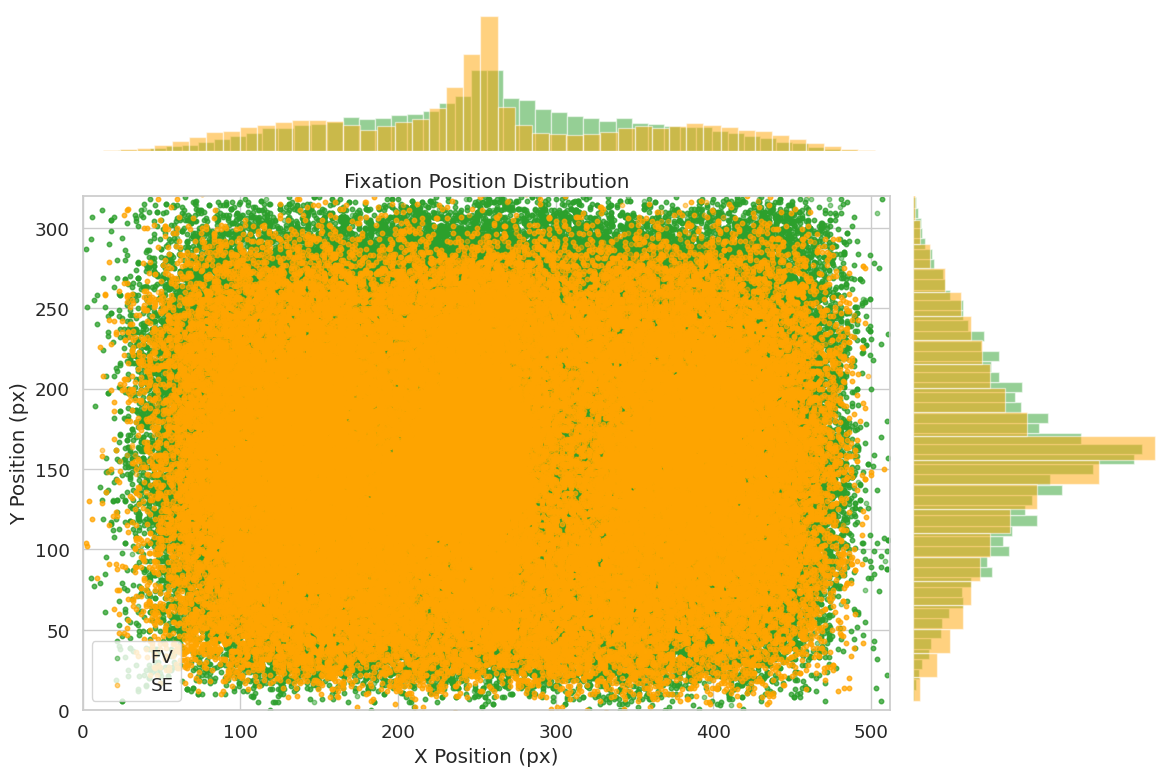

In [74]:
plot_xy_scatter_with_marginals(
    fv_fix_x, fv_fix_y,
    tp_fix_x, tp_fix_y,
    xlabel='X Position (px)', ylabel='Y Position (px)',
    title='Fixation Position Distribution',
    xlim=(0, 512), ylim=(0, 320)
)


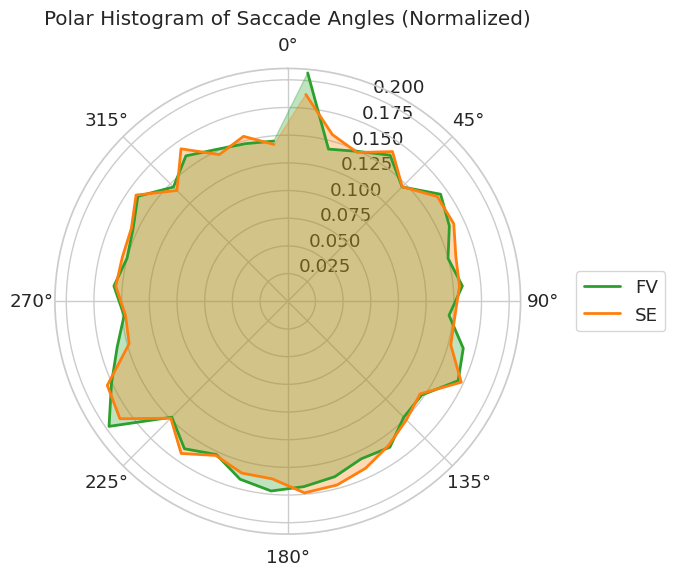

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_angle_hist_polar(angle_list1, angle_list2, label1='FV', label2='SE', bins=36):
    angle_list1 = np.mod(angle_list1, 2 * np.pi)
    angle_list2 = np.mod(angle_list2, 2 * np.pi)

    bin_edges = np.linspace(0, 2 * np.pi, bins + 1)
    hist1, _ = np.histogram(angle_list1, bins=bin_edges, density=True)
    hist2, _ = np.histogram(angle_list2, bins=bin_edges, density=True)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, polar=True)

    ax.plot(bin_centers, hist1, label=label1, color='tab:green', linewidth=2)
    ax.fill(bin_centers, hist1, alpha=0.3, color='tab:green')

    ax.plot(bin_centers, hist2, label=label2, color='tab:orange', linewidth=2)
    ax.fill(bin_centers, hist2, alpha=0.3, color='tab:orange')

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    ax.set_title("Polar Histogram of Saccade Angles (Normalized)", va='bottom')

    # 让图例靠右且不挡图，稍微往外移点
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    plt.tight_layout()
    plt.show()

# 示例调用
plot_angle_hist_polar(fv_sac_theta, tp_sac_theta)



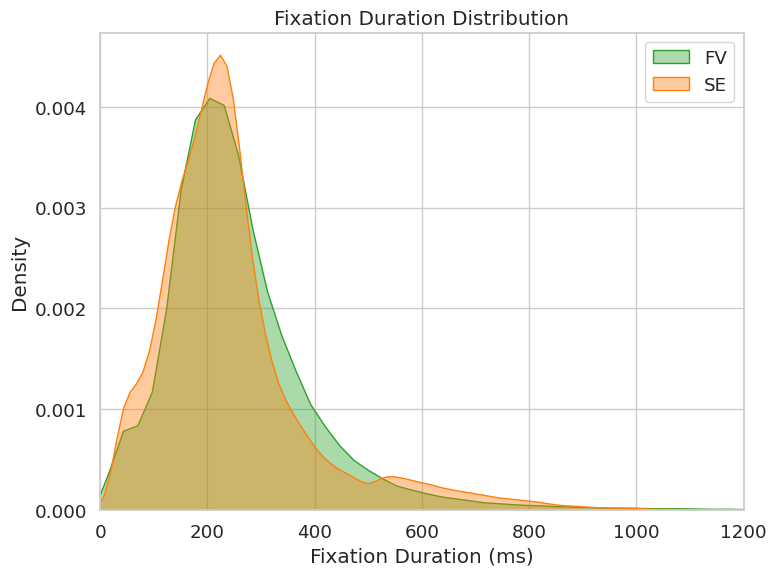

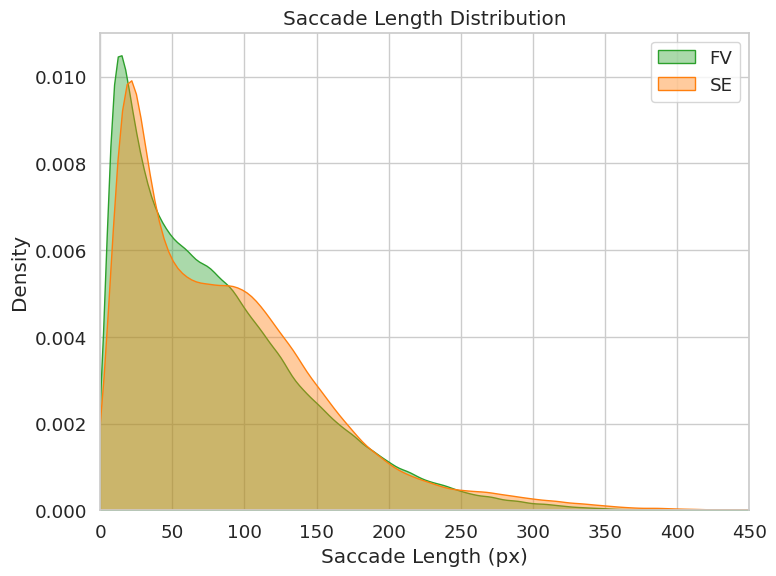

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)

# 图1：注视时间分布
plt.figure(figsize=(8, 6))
sns.kdeplot(fv_dur, label='FV', color='tab:green', fill=True, alpha=0.4)
sns.kdeplot(tp_dur, label='SE', color='tab:orange', fill=True, alpha=0.4)
plt.xlabel('Fixation Duration (ms)')
plt.title('Fixation Duration Distribution')
plt.xlim(0, 1200)
plt.legend()
plt.tight_layout()
plt.show()

# 图2：扫视长度分布
plt.figure(figsize=(8, 6))
sns.kdeplot(fv_sac_len, label='FV', color='tab:green', fill=True, alpha=0.4)
sns.kdeplot(tp_sac_len, label='SE', color='tab:orange', fill=True, alpha=0.4)
plt.xlabel('Saccade Length (px)')
plt.title('Saccade Length Distribution')
plt.xlim(0, 450)
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# 读取 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_matched_fixations_with_class_512x320.json', 'r') as f:
    data = json.load(f)

# 初始化进度条
total_entries = len(data)
start_time = time.time()

# 创建一个新的列表来存储分析结果
total_results = []

for i, entry in enumerate(tqdm(data, desc="Processing entries", unit="entry", leave=False)):
    data1 = pd.DataFrame({'Start X': entry['FV_X'], 'Start Y': entry['FV_Y'], 'Duration ms': entry['FV_T']})
    data2 = pd.DataFrame({'Start X': entry['TP_X'], 'Start Y': entry['TP_Y'], 'Duration ms': entry['TP_T']})

    sp1 = ps.generateStructureArrayScanpath(data1)
    sp2 = ps.generateStructureArrayScanpath(data2)

    
    sz = [512, 320]
    sp1_s, sp2_s, results, path, M_assignment = ps.mainProposed(sp1, sp2, 50, 30, 100, simple=False)
    analysis_result = {
        'name': entry['name'],
        'subject': entry['subject'],
        'class': entry['class'],
        'saccade_vector_diff_x': results['vector_x_diff_px'],
        'saccade_vector_diff_y': results['vector_y_diff_px'],
        'saccade_angle_diff': results['angular_diff_degree'],
        'saccade_length_diff': results['length_diff_px'],
        'position_diff': results['position_diff_px'],
        'fixation_time_diff': results['duration_diff_ms']
    }
    total_results.append(analysis_result)

    # 计算并显示剩余时间
    elapsed_time = time.time() - start_time
    remaining_time = (elapsed_time / (i + 1)) * (total_entries - (i + 1))
    tqdm.write(f"Processed {i + 1}/{total_entries} entries. Estimated time remaining: {remaining_time:.2f} seconds.", end='\r')

# 保存分析结果到新的 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_and_FV_analysis_results_512x320.json', 'w') as f:
    json.dump(total_results, f, indent=4)

print("分析结果已成功保存。")

Processing entries:   0%|          | 9/43978 [00:00<08:26, 86.78entry/s]

Processing entries:   0%|          | 18/43978 [00:00<16:04, 45.57entry/s]

Processing entries:   0%|          | 31/43978 [00:00<13:32, 54.11entry/s]

Processing entries:   0%|          | 41/43978 [00:00<12:07, 60.39entry/s]

Processing entries:   0%|          | 48/43978 [00:01<16:13, 45.13entry/s]

Processing entries:   0%|          | 67/43978 [00:01<12:58, 56.42entry/s]

Processing entries:   0%|          | 81/43978 [00:01<13:32, 54.00entry/s]

Processing entries:   0%|          | 106/43978 [00:01<08:48, 82.94entry/s]

Processing entries:   0%|          | 116/43978 [00:01<09:49, 74.43entry/s]

Processing entries:   0%|          | 176/43978 [00:02<05:35, 130.53entry/s]

Processing entries:   0%|          | 210/43978 [00:02<05:12, 139.89entry/s]

Processing entries:   1%|          | 253/43978 [00:02<04:13, 172.57entry/s]

Processing entries:   1%|          | 289/43978 [00:03<04:29, 161.86entry/s]

Processing entries:   1%|          | 325/43978 [00:03<04:39, 156.15entry/s]

Processing entries:   1%|          | 362/43978 [00:03<04:16, 169.83entry/s]

Processing entries:   1%|          | 380/43978 [00:03<04:21, 166.66entry/s]

Processing entries:   1%|          | 417/43978 [00:03<04:53, 148.55entry/s]

Processing entries:   1%|          | 465/43978 [00:04<03:52, 186.97entry/s]

Processing entries:   1%|          | 485/43978 [00:04<04:59, 145.33entry/s]

Processing entries:   1%|          | 529/43978 [00:04<04:06, 176.01entry/s]

Processing entries:   1%|▏         | 577/43978 [00:04<03:35, 201.69entry/s]

Processing entries:   1%|▏         | 622/43978 [00:04<03:25, 210.48entry/s]

Processing entries:   1%|▏         | 644/43978 [00:05<03:28, 208.25entry/s]

Processing entries:   2%|▏         | 666/43978 [00:05<04:09, 173.85entry/s]

Processing entries:   2%|▏         | 702/43978 [00:05<04:31, 159.41entry/s]

Processing entries:   2%|▏         | 774/43978 [00:05<04:29, 160.49entry/s]

Processing entries:   2%|▏         | 808/43978 [00:06<04:30, 159.34entry/s]

Processing entries:   2%|▏         | 846/43978 [00:06<04:35, 156.83entry/s]

Processing entries:   2%|▏         | 894/43978 [00:06<03:43, 192.97entry/s]

Processing entries:   2%|▏         | 914/43978 [00:06<03:48, 188.53entry/s]

Processing entries:   2%|▏         | 959/43978 [00:06<03:30, 204.73entry/s]

Processing entries:   2%|▏         | 1006/43978 [00:07<03:21, 213.50entry/s]

Processing entries:   2%|▏         | 1070/43978 [00:07<04:16, 167.55entry/s]

Processing entries:   3%|▎         | 1109/43978 [00:07<04:04, 175.32entry/s]

Processing entries:   3%|▎         | 1155/43978 [00:07<03:33, 200.68entry/s]

Processing entries:   3%|▎         | 1213/43978 [00:08<02:57, 241.41entry/s]

Error: The input matrix M must have positive dimensions.292.76 seconds.
Error: The input matrix M must have positive dimensions.287.90 seconds.


Processing entries:   3%|▎         | 1262/43978 [00:08<03:05, 230.75entry/s]

Processing entries:   3%|▎         | 1286/43978 [00:08<03:19, 214.21entry/s]

Processing entries:   3%|▎         | 1331/43978 [00:08<03:18, 214.83entry/s]

Processing entries:   3%|▎         | 1379/43978 [00:08<03:19, 213.46entry/s]

Processing entries:   3%|▎         | 1423/43978 [00:09<03:18, 214.39entry/s]

Processing entries:   3%|▎         | 1445/43978 [00:09<03:37, 195.96entry/s]

Processing entries:   3%|▎         | 1483/43978 [00:09<04:12, 168.11entry/s]

Processing entries:   3%|▎         | 1517/43978 [00:09<04:55, 143.90entry/s]

Processing entries:   3%|▎         | 1532/43978 [00:09<04:53, 144.54entry/s]

Processing entries:   4%|▎         | 1595/43978 [00:10<05:00, 141.24entry/s]

Processing entries:   4%|▎         | 1610/43978 [00:10<05:15, 134.41entry/s]

Processing entries:   4%|▎         | 1645/43978 [00:10<05:07, 137.75entry/s]

Processing entries:   4%|▍         | 1680/43978 [00:11<04:35, 153.63entry/s]

Error: The input matrix M must have positive dimensions.276.88 seconds.


Processing entries:   4%|▍         | 1716/43978 [00:11<04:37, 152.33entry/s]

Processing entries:   4%|▍         | 1753/43978 [00:11<04:32, 154.95entry/s]

Processing entries:   4%|▍         | 1786/43978 [00:11<04:41, 150.11entry/s]

Processing entries:   4%|▍         | 1802/43978 [00:11<04:49, 145.47entry/s]

Processing entries:   4%|▍         | 1836/43978 [00:12<04:35, 152.88entry/s]

Processing entries:   4%|▍         | 1866/43978 [00:12<05:35, 125.65entry/s]

Processing entries:   4%|▍         | 1883/43978 [00:12<05:17, 132.53entry/s]

Processing entries:   4%|▍         | 1948/43978 [00:12<04:53, 143.32entry/s]

Processing entries:   5%|▍         | 1988/43978 [00:13<04:14, 164.92entry/s]

Error: The input matrix M must have positive dimensions.276.02 seconds.
Error: The input matrix M must have positive dimensions.275.53 seconds.


Processing entries:   5%|▍         | 2029/43978 [00:13<03:56, 177.58entry/s]

Error: The input matrix M must have positive dimensions.274.35 seconds.


Processing entries:   5%|▍         | 2069/43978 [00:13<03:44, 186.70entry/s]

Processing entries:   5%|▍         | 2133/43978 [00:13<03:38, 191.52entry/s]

Processing entries:   5%|▍         | 2171/43978 [00:14<04:05, 170.38entry/s]

Processing entries:   5%|▌         | 2206/43978 [00:14<04:28, 155.30entry/s]

Error: The input matrix M must have positive dimensions.270.91 seconds.


Processing entries:   5%|▌         | 2246/43978 [00:14<03:56, 176.71entry/s]

Processing entries:   5%|▌         | 2264/43978 [00:14<04:34, 152.18entry/s]

Processing entries:   5%|▌         | 2299/43978 [00:14<04:21, 159.61entry/s]

Processing entries:   5%|▌         | 2336/43978 [00:15<04:02, 171.66entry/s]

Error: The input matrix M must have positive dimensions.268.10 seconds.


Processing entries:   5%|▌         | 2383/43978 [00:15<03:31, 197.11entry/s]

Processing entries:   6%|▌         | 2425/43978 [00:15<03:33, 194.31entry/s]

Processing entries:   6%|▌         | 2465/43978 [00:15<03:37, 190.91entry/s]

Processing entries:   6%|▌         | 2510/43978 [00:15<03:21, 205.46entry/s]

Processing entries:   6%|▌         | 2553/43978 [00:16<03:34, 192.74entry/s]

Processing entries:   6%|▌         | 2598/43978 [00:16<03:21, 205.26entry/s]

Processing entries:   6%|▌         | 2619/43978 [00:16<03:39, 188.81entry/s]

Processing entries:   6%|▌         | 2659/43978 [00:16<03:40, 187.46entry/s]

Processing entries:   6%|▌         | 2710/43978 [00:16<03:08, 219.06entry/s]

Error: The input matrix M must have positive dimensions.257.67 seconds.


Processing entries:   6%|▋         | 2755/43978 [00:17<03:23, 202.52entry/s]

Processing entries:   6%|▋         | 2796/43978 [00:17<03:37, 189.76entry/s]

Processing entries:   6%|▋         | 2816/43978 [00:17<03:36, 189.85entry/s]

Processing entries:   6%|▋         | 2854/43978 [00:17<04:20, 158.02entry/s]

Processing entries:   7%|▋         | 2871/43978 [00:17<05:10, 132.37entry/s]

Processing entries:   7%|▋         | 2906/43978 [00:18<06:04, 112.64entry/s]

Processing entries:   7%|▋         | 2941/43978 [00:18<05:01, 136.32entry/s]

Start or end node not found in the graph.ime remaining: 258.33 seconds.


Processing entries:   7%|▋         | 3016/43978 [00:18<04:04, 167.79entry/s]

Processing entries:   7%|▋         | 3056/43978 [00:19<03:45, 181.57entry/s]

Processing entries:   7%|▋         | 3095/43978 [00:19<03:55, 173.28entry/s]

Processing entries:   7%|▋         | 3134/43978 [00:19<03:47, 179.24entry/s]

Processing entries:   7%|▋         | 3153/43978 [00:19<03:47, 179.79entry/s]

Processing entries:   7%|▋         | 3189/43978 [00:20<04:29, 151.12entry/s]

Error: The input matrix M must have positive dimensions.255.89 seconds.


Error: The input matrix M must have positive dimensions.255.48 seconds.


Processing entries:   7%|▋         | 3241/43978 [00:20<04:50, 140.03entry/s]

Processing entries:   7%|▋         | 3258/43978 [00:20<04:37, 146.89entry/s]

Processing entries:   7%|▋         | 3289/43978 [00:20<05:31, 122.83entry/s]

Processing entries:   8%|▊         | 3303/43978 [00:21<05:26, 124.54entry/s]

Processing entries:   8%|▊         | 3329/43978 [00:21<07:09, 94.68entry/s] 

Processing entries:   8%|▊         | 3346/43978 [00:21<06:07, 110.62entry/s]

Error: The input matrix M must have positive dimensions.259.76 seconds.


Processing entries:   8%|▊         | 3371/43978 [00:21<07:36, 88.91entry/s] 

Processing entries:   8%|▊         | 3392/43978 [00:21<05:57, 113.64entry/s]

Processing entries:   8%|▊         | 3418/43978 [00:22<06:06, 110.57entry/s]

Processing entries:   8%|▊         | 3447/43978 [00:22<05:52, 114.91entry/s]

Processing entries:   8%|▊         | 3477/43978 [00:22<05:18, 127.18entry/s]

Processing entries:   8%|▊         | 3491/43978 [00:22<05:26, 124.18entry/s]

Processing entries:   8%|▊         | 3525/43978 [00:22<04:37, 145.65entry/s]

Error: The input matrix M must have positive dimensions.262.76 seconds.


Processing entries:   8%|▊         | 3569/43978 [00:23<03:41, 182.75entry/s]

Error: The input matrix M must have positive dimensions.261.63 seconds.
Error: The input matrix M must have positive dimensions.260.97 seconds.


Processing entries:   8%|▊         | 3621/43978 [00:23<03:07, 214.67entry/s]

Processing entries:   8%|▊         | 3665/43978 [00:23<03:21, 200.54entry/s]

Processing entries:   8%|▊         | 3717/43978 [00:23<02:57, 227.08entry/s]

Error: The input matrix M must have positive dimensions.256.93 seconds.
Error: The input matrix M must have positive dimensions.256.77 seconds.


Processing entries:   9%|▊         | 3767/43978 [00:23<02:50, 235.19entry/s]

Error: The input matrix M must have positive dimensions.256.65 seconds.
Error: The input matrix M must have positive dimensions.256.42 seconds.
Error: The input matrix M must have positive dimensions.256.31 seconds.
Error: The input matrix M must have positive dimensions.256.25 seconds.
Error: The input matrix M must have positive dimensions.256.19 seconds.
Error: The input matrix M must have positive dimensions.255.98 seconds.
Error: The input matrix M must have positive dimensions.255.54 seconds.


Processing entries:   9%|▊         | 3817/43978 [00:24<02:56, 227.65entry/s]

Error: The input matrix M must have positive dimensions.255.32 seconds.
Error: The input matrix M must have positive dimensions.255.28 seconds.
Error: The input matrix M must have positive dimensions.255.17 seconds.
Error: The input matrix M must have positive dimensions.255.01 seconds.
Error: The input matrix M must have positive dimensions.254.91 seconds.
Error: The input matrix M must have positive dimensions.254.70 seconds.
Error: The input matrix M must have positive dimensions.254.65 seconds.
Error: The input matrix M must have positive dimensions.254.51 seconds.
Error: The input matrix M must have positive dimensions.254.42 seconds.


Processing entries:   9%|▊         | 3840/43978 [00:24<03:11, 209.82entry/s]

Processing entries:   9%|▉         | 3883/43978 [00:24<03:31, 189.71entry/s]

Processing entries:   9%|▉         | 3929/43978 [00:24<03:22, 198.21entry/s]

Processing entries:   9%|▉         | 3972/43978 [00:24<03:23, 197.03entry/s]

Processing entries:   9%|▉         | 3992/43978 [00:25<03:22, 197.73entry/s]

Processing entries:   9%|▉         | 4013/43978 [00:25<03:29, 191.21entry/s]

Processing entries:   9%|▉         | 4033/43978 [00:25<04:40, 142.46entry/s]

Processing entries:   9%|▉         | 4064/43978 [00:25<05:58, 111.20entry/s]

Processing entries:   9%|▉         | 4077/43978 [00:25<06:17, 105.84entry/s]

Processing entries:   9%|▉         | 4101/43978 [00:26<07:02, 94.31entry/s] 

Processing entries:   9%|▉         | 4153/43978 [00:26<04:40, 142.10entry/s]

Processing entries:  10%|▉         | 4191/43978 [00:26<04:04, 162.73entry/s]

Processing entries:  10%|▉         | 4234/43978 [00:27<03:57, 167.00entry/s]

Processing entries:  10%|▉         | 4270/43978 [00:27<03:56, 167.79entry/s]

Processing entries:  10%|▉         | 4306/43978 [00:27<04:10, 158.06entry/s]

Processing entries:  10%|▉         | 4341/43978 [00:27<04:09, 159.10entry/s]

Processing entries:  10%|▉         | 4358/43978 [00:27<04:15, 154.83entry/s]

Processing entries:  10%|▉         | 4394/43978 [00:28<04:09, 158.75entry/s]

Processing entries:  10%|█         | 4430/43978 [00:28<03:55, 168.09entry/s]

Processing entries:  10%|█         | 4463/43978 [00:28<04:29, 146.64entry/s]

Processing entries:  10%|█         | 4496/43978 [00:28<04:17, 153.30entry/s]

Processing entries:  10%|█         | 4528/43978 [00:28<04:29, 146.14entry/s]

Processing entries:  10%|█         | 4561/43978 [00:29<04:15, 154.11entry/s]

Processing entries:  10%|█         | 4577/43978 [00:29<04:24, 149.22entry/s]

Processing entries:  10%|█         | 4612/43978 [00:29<04:12, 155.89entry/s]

Processing entries:  11%|█         | 4648/43978 [00:29<04:15, 153.97entry/s]

Processing entries:  11%|█         | 4681/43978 [00:29<04:14, 154.23entry/s]

Processing entries:  11%|█         | 4716/43978 [00:30<04:17, 152.44entry/s]

Processing entries:  11%|█         | 4755/43978 [00:30<03:49, 170.99entry/s]

Processing entries:  11%|█         | 4791/43978 [00:30<03:57, 165.25entry/s]

Processing entries:  11%|█         | 4899/43978 [00:31<03:57, 164.28entry/s]

Processing entries:  11%|█▏        | 4974/43978 [00:31<03:38, 178.26entry/s]

Processing entries:  11%|█▏        | 4993/43978 [00:31<03:46, 171.79entry/s]

Processing entries:  11%|█▏        | 5035/43978 [00:31<03:37, 179.43entry/s]

Processing entries:  12%|█▏        | 5073/43978 [00:32<03:53, 166.39entry/s]

Processing entries:  12%|█▏        | 5107/43978 [00:32<03:54, 165.72entry/s]

Processing entries:  12%|█▏        | 5146/43978 [00:32<03:43, 173.68entry/s]

Processing entries:  12%|█▏        | 5188/43978 [00:32<03:25, 188.99entry/s]

Processing entries:  12%|█▏        | 5226/43978 [00:32<03:36, 179.27entry/s]

Processing entries:  12%|█▏        | 5265/43978 [00:33<03:30, 183.70entry/s]

Processing entries:  12%|█▏        | 5284/43978 [00:33<03:30, 183.98entry/s]

Processing entries:  12%|█▏        | 5322/43978 [00:33<03:33, 181.29entry/s]

Processing entries:  12%|█▏        | 5365/43978 [00:33<03:55, 164.19entry/s]

Processing entries:  12%|█▏        | 5404/43978 [00:33<03:42, 173.50entry/s]

Processing entries:  12%|█▏        | 5422/43978 [00:34<03:55, 163.53entry/s]

Processing entries:  12%|█▏        | 5455/43978 [00:34<04:39, 137.63entry/s]

Processing entries:  12%|█▏        | 5493/43978 [00:34<04:04, 157.34entry/s]

Processing entries:  13%|█▎        | 5528/43978 [00:34<03:55, 163.09entry/s]

Processing entries:  13%|█▎        | 5567/43978 [00:34<03:34, 179.03entry/s]

Processing entries:  13%|█▎        | 5586/43978 [00:35<03:42, 172.29entry/s]

Processing entries:  13%|█▎        | 5621/43978 [00:35<04:01, 158.55entry/s]

Processing entries:  13%|█▎        | 5657/43978 [00:35<04:05, 156.20entry/s]

Processing entries:  13%|█▎        | 5699/43978 [00:35<03:32, 180.21entry/s]

Processing entries:  13%|█▎        | 5719/43978 [00:35<03:28, 183.55entry/s]

Processing entries:  13%|█▎        | 5756/43978 [00:36<04:18, 147.94entry/s]

Processing entries:  13%|█▎        | 5772/43978 [00:36<04:24, 144.54entry/s]

Processing entries:  13%|█▎        | 5805/43978 [00:36<04:16, 148.75entry/s]

Processing entries:  13%|█▎        | 5842/43978 [00:36<04:04, 155.83entry/s]

Processing entries:  13%|█▎        | 5874/43978 [00:37<04:27, 142.29entry/s]

Processing entries:  13%|█▎        | 5912/43978 [00:37<03:53, 162.83entry/s]

Processing entries:  14%|█▎        | 5948/43978 [00:37<03:50, 165.35entry/s]

Processing entries:  14%|█▎        | 5988/43978 [00:37<03:29, 181.70entry/s]

Processing entries:  14%|█▎        | 6007/43978 [00:37<03:34, 176.69entry/s]

Processing entries:  14%|█▍        | 6048/43978 [00:38<03:30, 180.28entry/s]

Processing entries:  14%|█▍        | 6088/43978 [00:38<03:22, 187.47entry/s]

Processing entries:  14%|█▍        | 6129/43978 [00:38<03:18, 190.62entry/s]

Processing entries:  14%|█▍        | 6170/43978 [00:38<03:15, 193.83entry/s]

Processing entries:  14%|█▍        | 6218/43978 [00:38<02:58, 211.80entry/s]

Processing entries:  14%|█▍        | 6264/43978 [00:39<02:57, 212.64entry/s]

Processing entries:  14%|█▍        | 6333/43978 [00:39<03:24, 184.03entry/s]

Processing entries:  14%|█▍        | 6371/43978 [00:39<04:04, 154.06entry/s]

Processing entries:  15%|█▍        | 6406/43978 [00:39<03:56, 159.14entry/s]

Processing entries:  15%|█▍        | 6423/43978 [00:40<03:57, 158.16entry/s]

Processing entries:  15%|█▍        | 6462/43978 [00:40<03:36, 173.44entry/s]

Processing entries:  15%|█▍        | 6497/43978 [00:40<03:58, 157.26entry/s]

Processing entries:  15%|█▍        | 6532/43978 [00:40<03:56, 158.13entry/s]

Processing entries:  15%|█▍        | 6573/43978 [00:40<03:29, 178.42entry/s]

Processing entries:  15%|█▌        | 6609/43978 [00:41<03:44, 166.57entry/s]

Processing entries:  15%|█▌        | 6626/43978 [00:41<03:44, 166.61entry/s]

Processing entries:  15%|█▌        | 6660/43978 [00:41<03:55, 158.72entry/s]

Processing entries:  15%|█▌        | 6732/43978 [00:41<03:47, 163.72entry/s]

Processing entries:  15%|█▌        | 6765/43978 [00:42<04:01, 154.12entry/s]

Processing entries:  15%|█▌        | 6802/43978 [00:42<03:39, 169.31entry/s]

Processing entries:  16%|█▌        | 6820/43978 [00:42<03:50, 161.44entry/s]

Processing entries:  16%|█▌        | 6894/43978 [00:42<03:38, 169.60entry/s]

Processing entries:  16%|█▌        | 6930/43978 [00:43<03:37, 170.01entry/s]

Processing entries:  16%|█▌        | 6972/43978 [00:43<03:21, 183.82entry/s]

Processing entries:  16%|█▌        | 7016/43978 [00:43<03:08, 196.58entry/s]

Error: The input matrix M must have positive dimensions.230.03 seconds.
Error: The input matrix M must have positive dimensions.229.93 seconds.
Error: The input matrix M must have positive dimensions.229.87 seconds.
Error: The input matrix M must have positive dimensions.229.65 seconds.


Processing entries:  16%|█▌        | 7036/43978 [00:43<03:12, 192.16entry/s]

Processing entries:  16%|█▌        | 7077/43978 [00:43<03:08, 195.58entry/s]

Processing entries:  16%|█▌        | 7117/43978 [00:44<03:11, 192.74entry/s]

Error: The input matrix M must have positive dimensions.228.27 seconds.


Processing entries:  16%|█▋        | 7158/43978 [00:44<03:16, 187.70entry/s]

Processing entries:  16%|█▋        | 7198/43978 [00:44<03:15, 187.76entry/s]

Processing entries:  16%|█▋        | 7237/43978 [00:44<03:21, 181.91entry/s]

Processing entries:  17%|█▋        | 7280/43978 [00:44<03:23, 180.75entry/s]

Processing entries:  17%|█▋        | 7388/43978 [00:45<03:02, 200.85entry/s]

Error: The input matrix M must have positive dimensions.225.30 seconds.


Processing entries:  17%|█▋        | 7430/43978 [00:45<03:06, 195.98entry/s]

Processing entries:  17%|█▋        | 7477/43978 [00:45<02:51, 213.17entry/s]

Processing entries:  17%|█▋        | 7542/43978 [00:46<03:28, 174.56entry/s]

Processing entries:  17%|█▋        | 7580/43978 [00:46<03:27, 175.64entry/s]

Processing entries:  17%|█▋        | 7618/43978 [00:46<03:29, 173.41entry/s]

Error: The input matrix M must have positive dimensions.223.46 seconds.


Processing entries:  17%|█▋        | 7655/43978 [00:46<03:32, 171.29entry/s]

Processing entries:  17%|█▋        | 7692/43978 [00:47<03:27, 175.02entry/s]

Processing entries:  18%|█▊        | 7728/43978 [00:47<03:45, 161.09entry/s]

Processing entries:  18%|█▊        | 7772/43978 [00:47<03:17, 183.22entry/s]

Processing entries:  18%|█▊        | 7791/43978 [00:47<03:30, 172.19entry/s]

Processing entries:  18%|█▊        | 7831/43978 [00:48<03:25, 176.24entry/s]

Processing entries:  18%|█▊        | 7871/43978 [00:48<03:37, 166.29entry/s]

Processing entries:  18%|█▊        | 7911/43978 [00:48<03:22, 178.15entry/s]

Processing entries:  18%|█▊        | 7930/43978 [00:48<03:24, 175.93entry/s]

Processing entries:  18%|█▊        | 7970/43978 [00:48<03:37, 165.52entry/s]

Processing entries:  18%|█▊        | 8004/43978 [00:49<03:47, 158.25entry/s]

Processing entries:  18%|█▊        | 8021/43978 [00:49<03:58, 150.55entry/s]

Processing entries:  18%|█▊        | 8056/43978 [00:49<03:47, 158.22entry/s]

Processing entries:  19%|█▊        | 8139/43978 [00:49<03:19, 179.93entry/s]

Processing entries:  19%|█▊        | 8177/43978 [00:50<03:16, 182.23entry/s]

Processing entries:  19%|█▊        | 8196/43978 [00:50<03:21, 177.82entry/s]

Processing entries:  19%|█▊        | 8231/43978 [00:50<03:52, 154.06entry/s]

Processing entries:  19%|█▉        | 8279/43978 [00:50<03:07, 190.72entry/s]

Processing entries:  19%|█▉        | 8328/43978 [00:50<02:44, 216.14entry/s]

Processing entries:  19%|█▉        | 8376/43978 [00:51<02:38, 224.90entry/s]

Processing entries:  19%|█▉        | 8472/43978 [00:51<02:49, 208.98entry/s]

Processing entries:  19%|█▉        | 8494/43978 [00:51<02:56, 201.40entry/s]

Processing entries:  19%|█▉        | 8537/43978 [00:51<02:59, 197.65entry/s]

Processing entries:  20%|█▉        | 8583/43978 [00:52<02:47, 211.63entry/s]

Error: The input matrix M must have positive dimensions.214.62 seconds.
Error: The input matrix M must have positive dimensions.214.58 seconds.


Processing entries:  20%|█▉        | 8627/43978 [00:52<02:54, 202.56entry/s]

Processing entries:  20%|█▉        | 8651/43978 [00:52<02:47, 210.62entry/s]

Error: The input matrix M must have positive dimensions.213.83 seconds.


Processing entries:  20%|█▉        | 8673/43978 [00:52<03:30, 167.66entry/s]

Processing entries:  20%|█▉        | 8708/43978 [00:53<06:09, 95.50entry/s] 

Processing entries:  20%|█▉        | 8740/43978 [00:53<05:28, 107.39entry/s]

Processing entries:  20%|█▉        | 8740/43978 [00:53<05:28, 107.39entry/s]

Processing entries:  20%|█▉        | 8764/43978 [00:53<07:11, 81.67entry/s] 

Processing entries:  20%|█▉        | 8775/43978 [00:54<08:59, 65.23entry/s]

Processing entries:  20%|█▉        | 8784/43978 [00:54<11:54, 49.26entry/s]

Processing entries:  20%|██        | 8801/43978 [00:54<08:49, 66.42entry/s]

Processing entries:  20%|██        | 8820/43978 [00:55<20:39, 28.36entry/s]

Processing entries:  20%|██        | 8854/43978 [00:56<10:23, 56.35entry/s]

Error: The input matrix M must have positive dimensions.222.58 seconds.


Processing entries:  20%|██        | 8871/43978 [00:56<08:03, 72.56entry/s]

Processing entries:  20%|██        | 8909/43978 [00:56<05:15, 111.02entry/s]

Processing entries:  20%|██        | 8944/43978 [00:56<04:22, 133.58entry/s]

Processing entries:  20%|██        | 8980/43978 [00:56<03:55, 148.33entry/s]

Processing entries:  20%|██        | 9002/43978 [00:57<03:55, 148.72entry/s]

Processing entries:  21%|██        | 9018/43978 [00:57<05:34, 104.43entry/s]

Processing entries:  21%|██        | 9043/43978 [00:57<05:39, 102.82entry/s]

Processing entries:  21%|██        | 9055/43978 [00:57<06:17, 92.57entry/s] 

Processing entries:  21%|██        | 9077/43978 [00:57<06:33, 88.61entry/s]

Processing entries:  21%|██        | 9102/43978 [00:58<05:40, 102.30entry/s]

Error: The input matrix M must have positive dimensions.222.85 seconds.


Processing entries:  21%|██        | 9113/43978 [00:58<06:30, 89.20entry/s] 

Processing entries:  21%|██        | 9123/43978 [00:58<09:09, 63.38entry/s]

Processing entries:  21%|██        | 9139/43978 [00:58<10:03, 57.73entry/s]

Processing entries:  21%|██        | 9146/43978 [00:59<10:33, 55.00entry/s]

Processing entries:  21%|██        | 9164/43978 [00:59<09:52, 58.77entry/s]

Processing entries:  21%|██        | 9171/43978 [00:59<13:13, 43.87entry/s]

Processing entries:  21%|██        | 9195/43978 [00:59<09:19, 62.13entry/s]

Processing entries:  21%|██        | 9215/43978 [01:00<07:39, 75.60entry/s]

Processing entries:  21%|██        | 9259/43978 [01:00<06:02, 95.84entry/s]

Error: The input matrix M must have positive dimensions.227.21 seconds.


Processing entries:  21%|██        | 9270/43978 [01:00<07:22, 78.35entry/s]

Processing entries:  21%|██        | 9287/43978 [01:01<07:58, 72.54entry/s]

Processing entries:  21%|██        | 9304/43978 [01:01<07:59, 72.26entry/s]

Processing entries:  21%|██        | 9334/43978 [01:01<05:50, 98.71entry/s]

Processing entries:  21%|██▏       | 9380/43978 [01:01<03:39, 157.37entry/s]

Error: The input matrix M must have positive dimensions.227.81 seconds.


Processing entries:  21%|██▏       | 9418/43978 [01:01<03:21, 171.23entry/s]

Error: The input matrix M must have positive dimensions.227.53 seconds.


Processing entries:  21%|██▏       | 9436/43978 [01:02<03:53, 147.77entry/s]

Processing entries:  22%|██▏       | 9469/43978 [01:02<04:08, 138.95entry/s]

Processing entries:  22%|██▏       | 9507/43978 [01:02<03:35, 159.82entry/s]

Processing entries:  22%|██▏       | 9524/43978 [01:02<03:40, 156.35entry/s]

Processing entries:  22%|██▏       | 9556/43978 [01:02<04:15, 134.90entry/s]

Processing entries:  22%|██▏       | 9587/43978 [01:03<04:07, 139.07entry/s]

Processing entries:  22%|██▏       | 9603/43978 [01:03<04:18, 132.99entry/s]

Error: The input matrix M must have positive dimensions.226.59 seconds.


Processing entries:  22%|██▏       | 9618/43978 [01:03<04:10, 137.43entry/s]

Processing entries:  22%|██▏       | 9633/43978 [01:03<06:07, 93.48entry/s] 

Processing entries:  22%|██▏       | 9633/43978 [01:04<06:07, 93.48entry/s]

Processing entries:  22%|██▏       | 9645/43978 [01:04<09:42, 58.97entry/s]

Processing entries:  22%|██▏       | 9662/43978 [01:04<10:38, 53.74entry/s]

Processing entries:  22%|██▏       | 9678/43978 [01:04<09:21, 61.03entry/s]

Error: The input matrix M must have positive dimensions.229.21 seconds.


Processing entries:  22%|██▏       | 9701/43978 [01:04<07:57, 71.71entry/s]

Processing entries:  22%|██▏       | 9731/43978 [01:05<05:36, 101.82entry/s]

Processing entries:  22%|██▏       | 9764/43978 [01:05<04:27, 128.09entry/s]

Error: The input matrix M must have positive dimensions.229.29 seconds.


Processing entries:  22%|██▏       | 9805/43978 [01:05<03:29, 162.88entry/s]

Processing entries:  22%|██▏       | 9844/43978 [01:05<03:12, 177.03entry/s]

Error: The input matrix M must have positive dimensions.228.48 seconds.
Error: The input matrix M must have positive dimensions.228.36 seconds.
Error: The input matrix M must have positive dimensions.228.35 seconds.


Processing entries:  22%|██▏       | 9863/43978 [01:05<03:23, 167.47entry/s]

Processing entries:  23%|██▎       | 9900/43978 [01:06<03:20, 169.67entry/s]

Processing entries:  23%|██▎       | 9936/43978 [01:06<03:15, 174.29entry/s]

Processing entries:  23%|██▎       | 9974/43978 [01:06<03:14, 174.70entry/s]

Processing entries:  23%|██▎       | 9993/43978 [01:06<03:10, 178.34entry/s]

Processing entries:  23%|██▎       | 10027/43978 [01:07<04:22, 129.21entry/s]

Processing entries:  23%|██▎       | 10054/43978 [01:07<04:41, 120.47entry/s]

Processing entries:  23%|██▎       | 10067/43978 [01:07<04:45, 118.59entry/s]

Processing entries:  23%|██▎       | 10093/43978 [01:07<05:24, 104.57entry/s]

Processing entries:  23%|██▎       | 10127/43978 [01:07<04:16, 131.79entry/s]

Processing entries:  23%|██▎       | 10161/43978 [01:08<04:08, 136.33entry/s]

Processing entries:  23%|██▎       | 10176/43978 [01:08<04:05, 137.60entry/s]

Processing entries:  23%|██▎       | 10206/43978 [01:08<04:10, 134.57entry/s]

Processing entries:  23%|██▎       | 10237/43978 [01:08<04:19, 129.97entry/s]

Processing entries:  23%|██▎       | 10268/43978 [01:08<03:59, 140.86entry/s]

Processing entries:  23%|██▎       | 10312/43978 [01:09<03:07, 179.23entry/s]

Error: The input matrix M must have positive dimensions. 226.08 seconds.
Error: The input matrix M must have positive dimensions. 225.83 seconds.
Error: The input matrix M must have positive dimensions. 225.64 seconds.


Processing entries:  24%|██▎       | 10364/43978 [01:09<02:38, 212.40entry/s]

Error: The input matrix M must have positive dimensions. 225.35 seconds.
Error: The input matrix M must have positive dimensions. 225.31 seconds.


Processing entries:  24%|██▎       | 10410/43978 [01:09<02:35, 216.39entry/s]

Error: The input matrix M must have positive dimensions. 224.67 seconds.
Error: The input matrix M must have positive dimensions. 224.60 seconds.


Processing entries:  24%|██▎       | 10432/43978 [01:09<02:36, 214.35entry/s]

Error: The input matrix M must have positive dimensions. 224.29 seconds.
Error: The input matrix M must have positive dimensions. 224.25 seconds.
Error: The input matrix M must have positive dimensions. 224.22 seconds.


Processing entries:  24%|██▍       | 10474/43978 [01:09<03:00, 185.93entry/s]

Processing entries:  24%|██▍       | 10512/43978 [01:10<03:12, 174.21entry/s]

Processing entries:  24%|██▍       | 10551/43978 [01:10<03:12, 173.26entry/s]

Processing entries:  24%|██▍       | 10607/43978 [01:10<03:36, 154.26entry/s]

Processing entries:  24%|██▍       | 10644/43978 [01:10<03:31, 157.52entry/s]

Processing entries:  24%|██▍       | 10678/43978 [01:11<03:26, 160.97entry/s]

Processing entries:  24%|██▍       | 10711/43978 [01:11<03:33, 155.99entry/s]

Error: The input matrix M must have positive dimensions. 222.00 seconds.


Processing entries:  24%|██▍       | 10727/43978 [01:11<03:35, 154.29entry/s]

Error: The input matrix M must have positive dimensions. 221.58 seconds.
Error: The input matrix M must have positive dimensions. 221.46 seconds.


Processing entries:  25%|██▍       | 10775/43978 [01:11<03:06, 177.84entry/s]

Error: The input matrix M must have positive dimensions. 221.26 seconds.


Processing entries:  25%|██▍       | 10793/43978 [01:12<03:48, 145.29entry/s]

Error: The input matrix M must have positive dimensions. 221.22 seconds.


Processing entries:  25%|██▍       | 10823/43978 [01:12<04:48, 115.01entry/s]

Processing entries:  25%|██▍       | 10842/43978 [01:12<04:14, 130.36entry/s]

Processing entries:  25%|██▍       | 10869/43978 [01:12<04:40, 117.84entry/s]

Processing entries:  25%|██▍       | 10882/43978 [01:12<04:58, 110.95entry/s]

Processing entries:  25%|██▍       | 10915/43978 [01:13<04:28, 122.93entry/s]

Processing entries:  25%|██▍       | 10948/43978 [01:13<04:43, 116.58entry/s]

Error: The input matrix M must have positive dimensions. 221.22 seconds.


Processing entries:  25%|██▍       | 10993/43978 [01:13<03:28, 158.29entry/s]

Error: The input matrix M must have positive dimensions. 220.83 seconds.


Processing entries:  25%|██▌       | 11040/43978 [01:13<02:55, 188.14entry/s]

Start or end node not found in the graph.time remaining: 220.50 seconds.


Processing entries:  25%|██▌       | 11085/43978 [01:13<02:43, 201.21entry/s]

Processing entries:  25%|██▌       | 11106/43978 [01:14<02:55, 187.24entry/s]

Processing entries:  25%|██▌       | 11153/43978 [01:14<02:37, 208.72entry/s]

Error: The input matrix M must have positive dimensions. 218.91 seconds.
Error: The input matrix M must have positive dimensions. 218.69 seconds.


Processing entries:  25%|██▌       | 11203/43978 [01:14<02:24, 227.56entry/s]

Processing entries:  26%|██▌       | 11249/43978 [01:14<02:28, 220.58entry/s]

Error: The input matrix M must have positive dimensions. 217.81 seconds.
Error: The input matrix M must have positive dimensions. 217.27 seconds.


Processing entries:  26%|██▌       | 11300/43978 [01:14<02:17, 237.17entry/s]

Processing entries:  26%|██▌       | 11351/43978 [01:15<02:12, 246.51entry/s]

Processing entries:  26%|██▌       | 11376/43978 [01:15<03:00, 180.87entry/s]

Processing entries:  26%|██▌       | 11397/43978 [01:15<03:01, 179.26entry/s]

Processing entries:  26%|██▌       | 11417/43978 [01:15<04:06, 131.89entry/s]

Processing entries:  26%|██▌       | 11450/43978 [01:15<04:17, 126.57entry/s]

Processing entries:  26%|██▌       | 11465/43978 [01:16<05:03, 107.24entry/s]

Processing entries:  26%|██▌       | 11498/43978 [01:16<04:10, 129.55entry/s]

Processing entries:  26%|██▌       | 11540/43978 [01:16<03:18, 163.56entry/s]

Processing entries:  26%|██▋       | 11558/43978 [01:16<03:47, 142.73entry/s]

Processing entries:  26%|██▋       | 11621/43978 [01:17<03:37, 149.09entry/s]

Processing entries:  27%|██▋       | 11663/43978 [01:17<03:21, 160.08entry/s]

Processing entries:  27%|██▋       | 11734/43978 [01:17<03:18, 162.83entry/s]

Processing entries:  27%|██▋       | 11775/43978 [01:18<02:56, 182.56entry/s]

Error: The input matrix M must have positive dimensions. 213.85 seconds.


Processing entries:  27%|██▋       | 11817/43978 [01:18<02:46, 193.57entry/s]

Processing entries:  27%|██▋       | 11858/43978 [01:18<02:45, 193.63entry/s]

Processing entries:  27%|██▋       | 11878/43978 [01:18<03:31, 151.62entry/s]

Processing entries:  27%|██▋       | 11925/43978 [01:18<02:53, 184.95entry/s]

Error: The input matrix M must have positive dimensions. 212.41 seconds.
Error: The input matrix M must have positive dimensions. 212.06 seconds.


Processing entries:  27%|██▋       | 11945/43978 [01:19<02:50, 188.06entry/s]

Processing entries:  27%|██▋       | 11984/43978 [01:19<03:25, 156.00entry/s]

Processing entries:  27%|██▋       | 12001/43978 [01:19<03:32, 150.22entry/s]

Error: The input matrix M must have positive dimensions. 211.66 seconds.
Error: The input matrix M must have positive dimensions. 211.55 seconds.


Processing entries:  27%|██▋       | 12032/43978 [01:19<03:51, 138.24entry/s]

Processing entries:  27%|██▋       | 12066/43978 [01:19<03:29, 152.17entry/s]

Processing entries:  27%|██▋       | 12082/43978 [01:20<04:00, 132.86entry/s]

Processing entries:  28%|██▊       | 12114/43978 [01:20<04:11, 126.77entry/s]

Error: The input matrix M must have positive dimensions. 211.02 seconds.


Processing entries:  28%|██▊       | 12137/43978 [01:20<03:30, 151.49entry/s]

Processing entries:  28%|██▊       | 12168/43978 [01:20<04:26, 119.52entry/s]

Processing entries:  28%|██▊       | 12181/43978 [01:20<05:21, 98.82entry/s] 

Processing entries:  28%|██▊       | 12204/43978 [01:21<04:13, 125.57entry/s]

Processing entries:  28%|██▊       | 12235/43978 [01:21<04:19, 122.51entry/s]

Processing entries:  28%|██▊       | 12271/43978 [01:21<03:45, 140.39entry/s]

Processing entries:  28%|██▊       | 12309/43978 [01:21<03:47, 138.93entry/s]

Processing entries:  28%|██▊       | 12354/43978 [01:21<03:00, 175.40entry/s]

Processing entries:  28%|██▊       | 12373/43978 [01:22<03:14, 162.59entry/s]

Start or end node not found in the graph.time remaining: 209.67 seconds.


Processing entries:  28%|██▊       | 12486/43978 [01:22<03:08, 167.16entry/s]

Processing entries:  29%|██▊       | 12540/43978 [01:23<02:28, 211.97entry/s]

Error: The input matrix M must have positive dimensions. 208.85 seconds.
Error: The input matrix M must have positive dimensions. 208.52 seconds.


Processing entries:  29%|██▊       | 12593/43978 [01:23<02:13, 234.81entry/s]

Error: The input matrix M must have positive dimensions. 208.14 seconds.
Error: The input matrix M must have positive dimensions. 207.97 seconds.
Error: The input matrix M must have positive dimensions. 207.95 seconds.
Error: The input matrix M must have positive dimensions. 207.89 seconds.
Error: The input matrix M must have positive dimensions. 207.87 seconds.
Error: The input matrix M must have positive dimensions. 207.83 seconds.
Error: The input matrix M must have positive dimensions. 207.72 seconds.
Error: The input matrix M must have positive dimensions. 207.65 seconds.


Processing entries:  29%|██▊       | 12617/43978 [01:23<02:29, 210.45entry/s]

Error: The input matrix M must have positive dimensions. 207.11 seconds.


Processing entries:  29%|██▉       | 12673/43978 [01:23<02:15, 231.50entry/s]

Processing entries:  29%|██▉       | 12723/43978 [01:23<02:12, 236.65entry/s]

Processing entries:  29%|██▉       | 12771/43978 [01:24<02:15, 230.94entry/s]

Processing entries:  29%|██▉       | 12820/43978 [01:24<02:16, 227.44entry/s]

Processing entries:  29%|██▉       | 12866/43978 [01:24<02:18, 224.02entry/s]

Error: The input matrix M must have positive dimensions. 204.51 seconds.


Processing entries:  29%|██▉       | 12917/43978 [01:24<02:13, 232.42entry/s]

Error: The input matrix M must have positive dimensions. 204.06 seconds.
Error: The input matrix M must have positive dimensions. 203.96 seconds.


Processing entries:  29%|██▉       | 12966/43978 [01:24<02:14, 230.91entry/s]

Error: The input matrix M must have positive dimensions. 203.57 seconds.
Error: The input matrix M must have positive dimensions. 203.45 seconds.
Error: The input matrix M must have positive dimensions. 203.31 seconds.


Processing entries:  30%|██▉       | 12990/43978 [01:25<02:17, 225.13entry/s]

Processing entries:  30%|██▉       | 13035/43978 [01:25<02:34, 199.79entry/s]

Processing entries:  30%|██▉       | 13056/43978 [01:25<02:46, 185.37entry/s]

Processing entries:  30%|██▉       | 13097/43978 [01:25<03:07, 164.74entry/s]

Processing entries:  30%|██▉       | 13132/43978 [01:25<03:24, 150.52entry/s]

Error: The input matrix M must have positive dimensions. 201.92 seconds.


Processing entries:  30%|██▉       | 13170/43978 [01:26<03:04, 167.23entry/s]

Error: The input matrix M must have positive dimensions. 201.67 seconds.


Processing entries:  30%|███       | 13194/43978 [01:26<02:45, 185.81entry/s]

Start or end node not found in the graph.time remaining: 201.43 seconds.


Processing entries:  30%|███       | 13231/43978 [01:26<02:59, 171.30entry/s]

Start or end node not found in the graph.time remaining: 201.05 seconds.


Processing entries:  30%|███       | 13268/43978 [01:26<03:02, 168.34entry/s]

Processing entries:  30%|███       | 13312/43978 [01:26<02:41, 189.85entry/s]

Processing entries:  30%|███       | 13352/43978 [01:27<02:49, 180.92entry/s]

Processing entries:  30%|███       | 13398/43978 [01:27<02:30, 202.56entry/s]

Processing entries:  31%|███       | 13440/43978 [01:27<02:29, 204.84entry/s]

Processing entries:  31%|███       | 13463/43978 [01:27<02:25, 209.31entry/s]

Processing entries:  31%|███       | 13507/43978 [01:27<02:29, 203.79entry/s]

Processing entries:  31%|███       | 13554/43978 [01:28<02:25, 209.37entry/s]

Error: The input matrix M must have positive dimensions. 197.94 seconds.
Error: The input matrix M must have positive dimensions. 197.80 seconds.
Error: The input matrix M must have positive dimensions. 197.65 seconds.


Processing entries:  31%|███       | 13599/43978 [01:28<02:30, 202.43entry/s]

Error: The input matrix M must have positive dimensions. 197.56 seconds.


Processing entries:  31%|███       | 13647/43978 [01:28<02:24, 210.50entry/s]

Error: The input matrix M must have positive dimensions. 197.12 seconds.
Error: The input matrix M must have positive dimensions. 196.88 seconds.


Processing entries:  31%|███       | 13669/43978 [01:28<02:49, 179.09entry/s]

Processing entries:  31%|███       | 13717/43978 [01:28<02:27, 205.14entry/s]

Error: The input matrix M must have positive dimensions. 196.46 seconds.
Error: The input matrix M must have positive dimensions. 196.45 seconds.
Error: The input matrix M must have positive dimensions. 196.34 seconds.


Processing entries:  31%|███▏      | 13759/43978 [01:29<02:49, 178.56entry/s]

Processing entries:  31%|███▏      | 13783/43978 [01:29<02:37, 191.42entry/s]

Processing entries:  31%|███▏      | 13822/43978 [01:29<02:58, 168.95entry/s]

Processing entries:  32%|███▏      | 13858/43978 [01:29<03:09, 158.65entry/s]

Start or end node not found in the graph.time remaining: 195.29 seconds.


Processing entries:  32%|███▏      | 13858/43978 [01:30<03:09, 158.65entry/s]

Processing entries:  32%|███▏      | 13893/43978 [01:30<04:20, 115.68entry/s]

Processing entries:  32%|███▏      | 13910/43978 [01:30<03:57, 126.72entry/s]

Error: The input matrix M must have positive dimensions. 195.37 seconds.


Processing entries:  32%|███▏      | 13946/43978 [01:30<03:42, 134.84entry/s]

Processing entries:  32%|███▏      | 13991/43978 [01:30<02:52, 174.27entry/s]

Processing entries:  32%|███▏      | 14034/43978 [01:31<02:38, 189.22entry/s]

Processing entries:  32%|███▏      | 14075/43978 [01:31<02:37, 190.23entry/s]

Processing entries:  32%|███▏      | 14095/43978 [01:31<02:47, 178.63entry/s]

Processing entries:  32%|███▏      | 14131/43978 [01:31<03:13, 154.04entry/s]

Error: The input matrix M must have positive dimensions. 193.61 seconds.


Processing entries:  32%|███▏      | 14166/43978 [01:31<03:25, 145.24entry/s]

Processing entries:  32%|███▏      | 14204/43978 [01:32<03:11, 155.83entry/s]

Processing entries:  32%|███▏      | 14242/43978 [01:32<03:03, 161.77entry/s]

Processing entries:  32%|███▏      | 14283/43978 [01:32<02:46, 177.97entry/s]

Processing entries:  33%|███▎      | 14302/43978 [01:32<03:05, 160.40entry/s]

Processing entries:  33%|███▎      | 14341/43978 [01:32<02:49, 175.10entry/s]

Error: The input matrix M must have positive dimensions. 191.89 seconds.


Processing entries:  33%|███▎      | 14383/43978 [01:33<02:39, 185.62entry/s]

Processing entries:  33%|███▎      | 14426/43978 [01:33<02:30, 195.73entry/s]

Processing entries:  33%|███▎      | 14446/43978 [01:33<02:30, 195.76entry/s]

Processing entries:  33%|███▎      | 14483/43978 [01:33<03:21, 146.09entry/s]

Processing entries:  33%|███▎      | 14524/43978 [01:33<02:53, 169.82entry/s]

Processing entries:  33%|███▎      | 14567/43978 [01:34<02:32, 192.32entry/s]

Error: The input matrix M must have positive dimensions. 190.60 seconds.


Processing entries:  33%|███▎      | 14588/43978 [01:34<02:41, 182.27entry/s]

Processing entries:  33%|███▎      | 14626/43978 [01:34<02:50, 172.08entry/s]

Processing entries:  33%|███▎      | 14662/43978 [01:34<02:52, 170.16entry/s]

Processing entries:  33%|███▎      | 14699/43978 [01:35<02:50, 171.67entry/s]

Processing entries:  34%|███▎      | 14742/43978 [01:35<02:33, 189.94entry/s]

Processing entries:  34%|███▎      | 14762/43978 [01:35<03:04, 158.05entry/s]

Error: The input matrix M must have positive dimensions. 188.54 seconds.
Error: The input matrix M must have positive dimensions. 188.52 seconds.


Processing entries:  34%|███▍      | 14846/43978 [01:35<02:34, 188.73entry/s]

Error: The input matrix M must have positive dimensions. 188.31 seconds.
Error: The input matrix M must have positive dimensions. 188.28 seconds.
Error: The input matrix M must have positive dimensions. 188.27 seconds.
Error: The input matrix M must have positive dimensions. 188.24 seconds.


Processing entries:  34%|███▍      | 14888/43978 [01:36<02:28, 195.68entry/s]

Processing entries:  34%|███▍      | 14938/43978 [01:36<02:13, 217.56entry/s]

Processing entries:  34%|███▍      | 14982/43978 [01:36<02:18, 209.31entry/s]

Processing entries:  34%|███▍      | 15004/43978 [01:36<02:35, 186.29entry/s]

Processing entries:  34%|███▍      | 15050/43978 [01:36<02:27, 195.96entry/s]

Error: The input matrix M must have positive dimensions. 186.37 seconds.
Error: The input matrix M must have positive dimensions. 186.27 seconds.
Error: The input matrix M must have positive dimensions. 186.17 seconds.
Error: The input matrix M must have positive dimensions. 186.13 seconds.
Error: The input matrix M must have positive dimensions. 186.10 seconds.
Error: The input matrix M must have positive dimensions. 186.06 seconds.


Processing entries:  34%|███▍      | 15093/43978 [01:37<02:38, 182.01entry/s]

Processing entries:  34%|███▍      | 15133/43978 [01:37<02:36, 183.87entry/s]

Processing entries:  34%|███▍      | 15152/43978 [01:37<02:47, 172.21entry/s]

Processing entries:  35%|███▍      | 15188/43978 [01:37<02:53, 165.97entry/s]

Processing entries:  35%|███▍      | 15232/43978 [01:37<02:34, 185.96entry/s]

Processing entries:  35%|███▍      | 15276/43978 [01:38<02:20, 203.96entry/s]

Error: The input matrix M must have positive dimensions. 184.45 seconds.
Error: The input matrix M must have positive dimensions. 184.41 seconds.
Error: The input matrix M must have positive dimensions. 184.33 seconds.
Error: The input matrix M must have positive dimensions. 184.25 seconds.
Error: The input matrix M must have positive dimensions. 184.24 seconds.
Start or end node not found in the graph.time remaining: 184.21 seconds.
Error: The input matrix M must have positive dimensions. 184.19 seconds.


Processing entries:  35%|███▍      | 15323/43978 [01:38<02:11, 217.65entry/s]

Error: The input matrix M must have positive dimensions. 183.93 seconds.
Error: The input matrix M must have positive dimensions. 183.88 seconds.
Error: The input matrix M must have positive dimensions. 183.86 seconds.
Error: The input matrix M must have positive dimensions. 183.83 seconds.


Processing entries:  35%|███▍      | 15367/43978 [01:38<02:17, 208.16entry/s]

Processing entries:  35%|███▌      | 15411/43978 [01:38<02:19, 204.12entry/s]

Processing entries:  35%|███▌      | 15453/43978 [01:38<02:23, 198.71entry/s]

Error: The input matrix M must have positive dimensions. 182.86 seconds.
Error: The input matrix M must have positive dimensions. 182.83 seconds.
Error: The input matrix M must have positive dimensions. 182.78 seconds.
Error: The input matrix M must have positive dimensions. 182.76 seconds.
Error: The input matrix M must have positive dimensions. 182.74 seconds.
Error: The input matrix M must have positive dimensions. 182.69 seconds.


Processing entries:  35%|███▌      | 15496/43978 [01:39<02:19, 204.13entry/s]

Error: The input matrix M must have positive dimensions. 182.36 seconds.


Processing entries:  35%|███▌      | 15520/43978 [01:39<02:12, 214.04entry/s]

Processing entries:  35%|███▌      | 15563/43978 [01:39<02:48, 168.14entry/s]

Error: The input matrix M must have positive dimensions. 181.55 seconds.


Processing entries:  36%|███▌      | 15661/43978 [01:40<02:47, 169.54entry/s]

Processing entries:  36%|███▌      | 15696/43978 [01:40<02:53, 163.36entry/s]

Processing entries:  36%|███▌      | 15730/43978 [01:40<02:59, 157.74entry/s]

Processing entries:  36%|███▌      | 15773/43978 [01:40<02:34, 182.54entry/s]

Processing entries:  36%|███▌      | 15817/43978 [01:41<02:23, 196.33entry/s]

Processing entries:  36%|███▌      | 15837/43978 [01:41<02:44, 171.42entry/s]

Processing entries:  36%|███▌      | 15875/43978 [01:41<02:55, 160.00entry/s]

Start or end node not found in the graph.time remaining: 179.57 seconds.


Processing entries:  36%|███▌      | 15892/43978 [01:41<03:32, 132.44entry/s]

Processing entries:  36%|███▌      | 15907/43978 [01:41<03:58, 117.62entry/s]

Processing entries:  36%|███▌      | 15933/43978 [01:42<04:37, 100.89entry/s]

Processing entries:  36%|███▋      | 15955/43978 [01:42<03:41, 126.76entry/s]

Start or end node not found in the graph.time remaining: 179.63 seconds.


Processing entries:  36%|███▋      | 15989/43978 [01:42<03:35, 129.79entry/s]

Processing entries:  36%|███▋      | 16027/43978 [01:42<03:06, 149.66entry/s]

Processing entries:  37%|███▋      | 16059/43978 [01:42<03:02, 153.08entry/s]

Processing entries:  37%|███▋      | 16075/43978 [01:43<03:12, 144.82entry/s]

Error: The input matrix M must have positive dimensions. 178.79 seconds.
Error: The input matrix M must have positive dimensions. 178.79 seconds.


Processing entries:  37%|███▋      | 16104/43978 [01:43<03:51, 120.47entry/s]

Processing entries:  37%|███▋      | 16131/43978 [01:43<03:45, 123.61entry/s]

Processing entries:  37%|███▋      | 16160/43978 [01:43<03:33, 130.30entry/s]

Processing entries:  37%|███▋      | 16193/43978 [01:43<03:12, 144.58entry/s]

Processing entries:  37%|███▋      | 16212/43978 [01:44<02:58, 155.15entry/s]

Processing entries:  37%|███▋      | 16243/43978 [01:44<03:59, 115.57entry/s]

Processing entries:  37%|███▋      | 16256/43978 [01:44<04:46, 96.67entry/s] 

Processing entries:  37%|███▋      | 16288/43978 [01:44<03:52, 119.10entry/s]

Processing entries:  37%|███▋      | 16301/43978 [01:44<03:59, 115.38entry/s]

Processing entries:  37%|███▋      | 16333/43978 [01:45<03:42, 124.40entry/s]

Processing entries:  37%|███▋      | 16360/43978 [01:45<04:05, 112.54entry/s]

Processing entries:  37%|███▋      | 16377/43978 [01:45<03:37, 126.74entry/s]

Processing entries:  37%|███▋      | 16407/43978 [01:45<03:57, 115.99entry/s]

Processing entries:  37%|███▋      | 16451/43978 [01:45<02:49, 162.85entry/s]

Error: The input matrix M must have positive dimensions. 177.57 seconds.
Error: The input matrix M must have positive dimensions. 177.55 seconds.


Processing entries:  38%|███▊      | 16493/43978 [01:46<02:28, 185.07entry/s]

Error: The input matrix M must have positive dimensions. 177.30 seconds.
Error: The input matrix M must have positive dimensions. 177.01 seconds.


Processing entries:  38%|███▊      | 16538/43978 [01:46<02:14, 203.31entry/s]

Processing entries:  38%|███▊      | 16580/43978 [01:46<02:17, 199.33entry/s]

Error: The input matrix M must have positive dimensions. 176.26 seconds.


Processing entries:  38%|███▊      | 16601/43978 [01:46<02:31, 180.99entry/s]

Processing entries:  38%|███▊      | 16694/43978 [01:47<02:08, 212.05entry/s]

Error: The input matrix M must have positive dimensions. 175.07 seconds.


Processing entries:  38%|███▊      | 16793/43978 [01:47<01:52, 241.95entry/s]

Error: The input matrix M must have positive dimensions. 174.55 seconds.
Error: The input matrix M must have positive dimensions. 174.51 seconds.
Error: The input matrix M must have positive dimensions. 174.17 seconds.
Error: The input matrix M must have positive dimensions. 174.12 seconds.


Processing entries:  38%|███▊      | 16893/43978 [01:47<01:59, 226.22entry/s]

Processing entries:  38%|███▊      | 16917/43978 [01:48<02:01, 221.93entry/s]

Processing entries:  39%|███▊      | 16962/43978 [01:48<02:09, 207.87entry/s]

Processing entries:  39%|███▊      | 17009/43978 [01:48<02:05, 215.61entry/s]

Processing entries:  39%|███▉      | 17055/43978 [01:48<02:03, 218.19entry/s]

Error: The input matrix M must have positive dimensions. 171.78 seconds.


Processing entries:  39%|███▉      | 17098/43978 [01:49<02:09, 206.80entry/s]

Processing entries:  39%|███▉      | 17143/43978 [01:49<02:09, 207.23entry/s]

Processing entries:  39%|███▉      | 17187/43978 [01:49<02:10, 205.41entry/s]

Error: The input matrix M must have positive dimensions. 170.61 seconds.


Processing entries:  39%|███▉      | 17209/43978 [01:49<02:08, 208.19entry/s]

Processing entries:  39%|███▉      | 17250/43978 [01:49<02:22, 187.96entry/s]

Processing entries:  39%|███▉      | 17295/43978 [01:50<02:12, 200.85entry/s]

Error: The input matrix M must have positive dimensions. 169.84 seconds.
Error: The input matrix M must have positive dimensions. 169.75 seconds.
Error: The input matrix M must have positive dimensions. 169.73 seconds.


Processing entries:  39%|███▉      | 17338/43978 [01:50<02:15, 196.37entry/s]

Processing entries:  40%|███▉      | 17381/43978 [01:50<02:11, 201.56entry/s]

Processing entries:  40%|███▉      | 17428/43978 [01:50<02:02, 216.10entry/s]

Error: The input matrix M must have positive dimensions. 168.89 seconds.


Processing entries:  40%|███▉      | 17473/43978 [01:50<02:12, 199.73entry/s]

Processing entries:  40%|███▉      | 17516/43978 [01:51<02:24, 182.56entry/s]

Processing entries:  40%|███▉      | 17560/43978 [01:51<02:13, 198.05entry/s]

Error: The input matrix M must have positive dimensions. 167.54 seconds.
Error: The input matrix M must have positive dimensions. 167.47 seconds.


Processing entries:  40%|████      | 17614/43978 [01:51<01:53, 232.00entry/s]

Error: The input matrix M must have positive dimensions. 167.44 seconds.
Error: The input matrix M must have positive dimensions. 166.96 seconds.


Processing entries:  40%|████      | 17663/43978 [01:51<01:51, 236.56entry/s]

Processing entries:  40%|████      | 17687/43978 [01:51<01:58, 221.65entry/s]

Processing entries:  40%|████      | 17732/43978 [01:52<02:09, 202.18entry/s]

Processing entries:  40%|████      | 17778/43978 [01:52<02:05, 208.27entry/s]

Processing entries:  41%|████      | 17825/43978 [01:52<01:59, 218.48entry/s]

Error: The input matrix M must have positive dimensions. 165.04 seconds.


Processing entries:  41%|████      | 17876/43978 [01:52<01:51, 233.75entry/s]

Error: The input matrix M must have positive dimensions. 164.78 seconds.
Error: The input matrix M must have positive dimensions. 164.65 seconds.
Start or end node not found in the graph.time remaining: 164.55 seconds.


Processing entries:  41%|████      | 17925/43978 [01:52<01:54, 227.57entry/s]

Error: The input matrix M must have positive dimensions. 164.35 seconds.


Processing entries:  41%|████      | 17978/43978 [01:53<01:47, 242.22entry/s]

Processing entries:  41%|████      | 18032/43978 [01:53<01:42, 252.62entry/s]

Error: The input matrix M must have positive dimensions. 163.41 seconds.
Error: The input matrix M must have positive dimensions. 163.32 seconds.
Error: The input matrix M must have positive dimensions. 163.29 seconds.
Error: The input matrix M must have positive dimensions. 163.27 seconds.
Error: The input matrix M must have positive dimensions. 163.25 seconds.
Error: The input matrix M must have positive dimensions. 163.21 seconds.
Error: The input matrix M must have positive dimensions. 163.19 seconds.


Processing entries:  41%|████      | 18086/43978 [01:53<01:43, 250.18entry/s]

Error: The input matrix M must have positive dimensions. 162.90 seconds.


Processing entries:  41%|████      | 18138/43978 [01:53<01:42, 251.37entry/s]

Error: The input matrix M must have positive dimensions. 162.52 seconds.


Processing entries:  41%|████▏     | 18190/43978 [01:53<01:42, 251.63entry/s]

Error: The input matrix M must have positive dimensions. 161.80 seconds.
Error: The input matrix M must have positive dimensions. 161.79 seconds.
Error: The input matrix M must have positive dimensions. 161.70 seconds.
Error: The input matrix M must have positive dimensions. 161.64 seconds.


Error: The input matrix M must have positive dimensions. 161.58 seconds.
Error: The input matrix M must have positive dimensions. 161.50 seconds.
Error: The input matrix M must have positive dimensions. 161.45 seconds.
Error: The input matrix M must have positive dimensions. 161.44 seconds.
Error: The input matrix M must have positive dimensions. 161.38 seconds.
Error: The input matrix M must have positive dimensions. 161.24 seconds.
Error: The input matrix M must have positive dimensions. 161.09 seconds.


Error: The input matrix M must have positive dimensions. 160.91 seconds.
Error: The input matrix M must have positive dimensions. 160.61 seconds.


Processing entries:  42%|████▏     | 18356/43978 [01:54<01:34, 271.29entry/s]

Processing entries:  42%|████▏     | 18384/43978 [01:54<01:38, 259.38entry/s]

Processing entries:  42%|████▏     | 18411/43978 [01:55<02:12, 193.11entry/s]

Processing entries:  42%|████▏     | 18455/43978 [01:55<02:14, 190.27entry/s]

Processing entries:  42%|████▏     | 18476/43978 [01:55<02:17, 185.23entry/s]

Error: The input matrix M must have positive dimensions. 159.07 seconds.


Processing entries:  42%|████▏     | 18515/43978 [01:55<02:32, 166.99entry/s]

Start or end node not found in the graph.time remaining: 158.99 seconds.


Processing entries:  42%|████▏     | 18561/43978 [01:55<02:10, 194.49entry/s]

Error: The input matrix M must have positive dimensions. 158.67 seconds.


Processing entries:  42%|████▏     | 18603/43978 [01:56<02:17, 185.11entry/s]

Error: The input matrix M must have positive dimensions. 158.30 seconds.


Processing entries:  42%|████▏     | 18648/43978 [01:56<02:08, 197.23entry/s]

Error: The input matrix M must have positive dimensions. 158.10 seconds.


Processing entries:  43%|████▎     | 18692/43978 [01:56<02:03, 205.23entry/s]

Error: The input matrix M must have positive dimensions. 157.73 seconds.
Error: The input matrix M must have positive dimensions. 157.55 seconds.


Processing entries:  43%|████▎     | 18741/43978 [01:56<01:59, 210.99entry/s]

Error: The input matrix M must have positive dimensions. 157.35 seconds.
Error: The input matrix M must have positive dimensions. 157.23 seconds.
Error: The input matrix M must have positive dimensions. 157.13 seconds.
Error: The input matrix M must have positive dimensions. 157.08 seconds.


Processing entries:  43%|████▎     | 18763/43978 [01:56<01:59, 210.78entry/s]

Error: The input matrix M must have positive dimensions. 156.96 seconds.
Error: The input matrix M must have positive dimensions. 156.95 seconds.


Processing entries:  43%|████▎     | 18806/43978 [01:57<02:05, 200.58entry/s]

Error: The input matrix M must have positive dimensions. 156.49 seconds.
Error: The input matrix M must have positive dimensions. 156.48 seconds.
Error: The input matrix M must have positive dimensions. 156.46 seconds.
Error: The input matrix M must have positive dimensions. 156.45 seconds.


Processing entries:  43%|████▎     | 18863/43978 [01:57<01:45, 238.41entry/s]

Error: The input matrix M must have positive dimensions. 156.30 seconds.
Error: The input matrix M must have positive dimensions. 156.29 seconds.
Error: The input matrix M must have positive dimensions. 156.28 seconds.
Error: The input matrix M must have positive dimensions. 156.27 seconds.
Error: The input matrix M must have positive dimensions. 156.24 seconds.


Processing entries:  43%|████▎     | 18911/43978 [01:57<02:00, 208.79entry/s]

Processing entries:  43%|████▎     | 18956/43978 [01:57<01:57, 212.30entry/s]

Processing entries:  43%|████▎     | 19002/43978 [01:57<01:56, 215.05entry/s]

Processing entries:  43%|████▎     | 19050/43978 [01:58<01:51, 223.63entry/s]

Processing entries:  43%|████▎     | 19073/43978 [01:58<02:06, 197.44entry/s]

Processing entries:  43%|████▎     | 19073/43978 [01:58<02:06, 197.44entry/s]

Processing entries:  43%|████▎     | 19111/43978 [01:58<02:58, 139.12entry/s]

Processing entries:  43%|████▎     | 19128/43978 [01:58<02:56, 140.88entry/s]

Processing entries:  44%|████▎     | 19168/43978 [01:59<02:46, 148.75entry/s]

Processing entries:  44%|████▎     | 19211/43978 [01:59<02:43, 151.54entry/s]

Processing entries:  44%|████▍     | 19253/43978 [01:59<02:21, 174.26entry/s]

Processing entries:  44%|████▍     | 19291/43978 [01:59<02:25, 169.80entry/s]

Processing entries:  44%|████▍     | 19336/43978 [01:59<02:08, 191.84entry/s]

Processing entries:  44%|████▍     | 19356/43978 [02:00<02:16, 180.61entry/s]

Processing entries:  44%|████▍     | 19400/43978 [02:00<02:19, 175.86entry/s]

Processing entries:  44%|████▍     | 19419/43978 [02:00<02:39, 153.90entry/s]

Processing entries:  44%|████▍     | 19419/43978 [02:00<02:39, 153.90entry/s]

Processing entries:  44%|████▍     | 19436/43978 [02:00<04:54, 83.21entry/s] 

Processing entries:  44%|████▍     | 19449/43978 [02:01<04:56, 82.67entry/s]

Processing entries:  44%|████▍     | 19449/43978 [02:01<04:56, 82.67entry/s]

Processing entries:  44%|████▍     | 19472/43978 [02:01<06:43, 60.78entry/s]

Processing entries:  44%|████▍     | 19482/43978 [02:01<06:49, 59.85entry/s]

Processing entries:  44%|████▍     | 19503/43978 [02:02<05:56, 68.58entry/s]

Processing entries:  44%|████▍     | 19524/43978 [02:02<04:56, 82.35entry/s]

Processing entries:  44%|████▍     | 19550/43978 [02:02<03:56, 103.34entry/s]

Processing entries:  45%|████▍     | 19584/43978 [02:02<03:16, 124.38entry/s]

Processing entries:  45%|████▍     | 19618/43978 [02:02<02:50, 142.95entry/s]

Processing entries:  45%|████▍     | 19655/43978 [02:03<02:37, 154.47entry/s]

Processing entries:  45%|████▍     | 19671/43978 [02:03<02:52, 141.32entry/s]

Processing entries:  45%|████▍     | 19705/43978 [02:03<02:50, 142.15entry/s]

Processing entries:  45%|████▍     | 19735/43978 [02:03<02:54, 139.12entry/s]

Processing entries:  45%|████▍     | 19769/43978 [02:04<02:43, 148.05entry/s]

Processing entries:  45%|████▍     | 19784/43978 [02:04<02:42, 148.45entry/s]

Processing entries:  45%|████▌     | 19819/43978 [02:04<02:51, 141.01entry/s]

Processing entries:  45%|████▌     | 19858/43978 [02:04<02:27, 163.17entry/s]

Processing entries:  45%|████▌     | 19898/43978 [02:04<02:48, 142.56entry/s]

Processing entries:  45%|████▌     | 19937/43978 [02:05<02:24, 166.27entry/s]

Processing entries:  45%|████▌     | 19978/43978 [02:05<02:11, 181.89entry/s]

Processing entries:  46%|████▌     | 20018/43978 [02:05<02:05, 190.25entry/s]

Processing entries:  46%|████▌     | 20038/43978 [02:05<02:07, 187.47entry/s]

Processing entries:  46%|████▌     | 20058/43978 [02:05<02:38, 151.11entry/s]

Processing entries:  46%|████▌     | 20091/43978 [02:06<02:48, 141.45entry/s]

Processing entries:  46%|████▌     | 20123/43978 [02:06<02:44, 145.34entry/s]

Processing entries:  46%|████▌     | 20155/43978 [02:06<02:50, 139.54entry/s]

Processing entries:  46%|████▌     | 20188/43978 [02:06<02:43, 145.69entry/s]

Processing entries:  46%|████▌     | 20203/43978 [02:06<03:11, 124.37entry/s]

Processing entries:  46%|████▌     | 20240/43978 [02:07<02:35, 153.03entry/s]

Processing entries:  46%|████▌     | 20273/43978 [02:07<02:33, 154.14entry/s]

Processing entries:  46%|████▌     | 20310/43978 [02:07<02:23, 165.25entry/s]

Processing entries:  46%|████▋     | 20351/43978 [02:07<02:18, 170.20entry/s]

Processing entries:  46%|████▋     | 20390/43978 [02:07<02:08, 183.26entry/s]

Processing entries:  46%|████▋     | 20390/43978 [02:08<02:08, 183.26entry/s]

Processing entries:  46%|████▋     | 20427/43978 [02:08<02:43, 143.93entry/s]

Processing entries:  47%|████▋     | 20463/43978 [02:08<02:28, 158.31entry/s]

Processing entries:  47%|████▋     | 20507/43978 [02:08<02:04, 188.67entry/s]

Error: The input matrix M must have positive dimensions. 147.19 seconds.


Processing entries:  47%|████▋     | 20559/43978 [02:08<01:46, 219.37entry/s]

Error: The input matrix M must have positive dimensions. 146.87 seconds.


Processing entries:  47%|████▋     | 20605/43978 [02:09<01:48, 215.09entry/s]

Processing entries:  47%|████▋     | 20648/43978 [02:09<01:58, 196.19entry/s]

Processing entries:  47%|████▋     | 20694/43978 [02:09<01:50, 210.22entry/s]

Processing entries:  47%|████▋     | 20716/43978 [02:09<01:59, 194.36entry/s]

Processing entries:  47%|████▋     | 20758/43978 [02:09<02:03, 187.98entry/s]

Processing entries:  47%|████▋     | 20801/43978 [02:10<02:09, 179.08entry/s]

Processing entries:  47%|████▋     | 20801/43978 [02:10<02:09, 179.08entry/s]

Processing entries:  47%|████▋     | 20835/43978 [02:10<03:12, 119.99entry/s]

Processing entries:  47%|████▋     | 20864/43978 [02:10<03:08, 122.72entry/s]

Processing entries:  48%|████▊     | 20892/43978 [02:11<03:07, 123.12entry/s]

Processing entries:  48%|████▊     | 20905/43978 [02:11<03:26, 111.77entry/s]

Processing entries:  48%|████▊     | 20936/43978 [02:11<02:58, 129.05entry/s]

Processing entries:  48%|████▊     | 20964/43978 [02:11<03:26, 111.71entry/s]

Processing entries:  48%|████▊     | 20998/43978 [02:11<02:49, 135.67entry/s]

Processing entries:  48%|████▊     | 21033/43978 [02:12<02:31, 151.33entry/s]

Error: The input matrix M must have positive dimensions. 144.21 seconds.


Processing entries:  48%|████▊     | 21065/43978 [02:12<02:34, 148.40entry/s]

Processing entries:  48%|████▊     | 21098/43978 [02:12<02:26, 155.99entry/s]

Processing entries:  48%|████▊     | 21114/43978 [02:12<02:40, 142.68entry/s]

Processing entries:  48%|████▊     | 21146/43978 [02:12<02:50, 134.06entry/s]

Processing entries:  48%|████▊     | 21161/43978 [02:13<02:48, 135.16entry/s]

Processing entries:  48%|████▊     | 21189/43978 [02:13<03:07, 121.73entry/s]

Processing entries:  48%|████▊     | 21217/43978 [02:13<03:06, 122.00entry/s]

Processing entries:  48%|████▊     | 21249/43978 [02:13<02:41, 140.51entry/s]

Processing entries:  48%|████▊     | 21289/43978 [02:13<02:14, 168.88entry/s]

Error: The input matrix M must have positive dimensions. 142.83 seconds.


Processing entries:  48%|████▊     | 21328/43978 [02:14<02:05, 180.55entry/s]

Error: The input matrix M must have positive dimensions. 142.68 seconds.


Processing entries:  49%|████▊     | 21347/43978 [02:14<02:21, 159.75entry/s]

Error: The input matrix M must have positive dimensions. 142.43 seconds.


Processing entries:  49%|████▊     | 21388/43978 [02:14<02:09, 174.49entry/s]

Processing entries:  49%|████▊     | 21429/43978 [02:14<02:01, 186.35entry/s]

Processing entries:  49%|████▉     | 21448/43978 [02:14<02:28, 151.35entry/s]

Processing entries:  49%|████▉     | 21484/43978 [02:15<02:24, 155.51entry/s]

Processing entries:  49%|████▉     | 21518/43978 [02:15<02:27, 152.12entry/s]

Error: The input matrix M must have positive dimensions. 141.40 seconds.


Processing entries:  49%|████▉     | 21557/43978 [02:15<02:12, 168.94entry/s]

Processing entries:  49%|████▉     | 21591/43978 [02:15<02:35, 143.84entry/s]

Processing entries:  49%|████▉     | 21622/43978 [02:16<02:33, 145.79entry/s]

Processing entries:  49%|████▉     | 21638/43978 [02:16<02:29, 149.05entry/s]

Error: The input matrix M must have positive dimensions. 140.50 seconds.


Processing entries:  49%|████▉     | 21676/43978 [02:16<02:15, 164.17entry/s]

Processing entries:  49%|████▉     | 21709/43978 [02:16<02:22, 156.31entry/s]

Processing entries:  49%|████▉     | 21754/43978 [02:16<02:01, 183.32entry/s]

Processing entries:  50%|████▉     | 21794/43978 [02:17<02:01, 182.76entry/s]

Processing entries:  50%|████▉     | 21831/43978 [02:17<02:12, 167.71entry/s]

Processing entries:  50%|████▉     | 21848/43978 [02:17<02:24, 153.05entry/s]

Processing entries:  50%|████▉     | 21889/43978 [02:17<02:09, 170.78entry/s]

Processing entries:  50%|████▉     | 21929/43978 [02:17<02:02, 180.12entry/s]

Processing entries:  50%|████▉     | 21970/43978 [02:18<01:55, 191.18entry/s]

Error: The input matrix M must have positive dimensions. 138.23 seconds.


Processing entries:  50%|█████     | 22017/43978 [02:18<02:05, 174.83entry/s]

Processing entries:  50%|█████     | 22036/43978 [02:18<02:03, 177.85entry/s]

Processing entries:  50%|█████     | 22073/43978 [02:18<02:13, 164.24entry/s]

Processing entries:  50%|█████     | 22109/43978 [02:18<02:20, 155.70entry/s]

Processing entries:  50%|█████     | 22125/43978 [02:19<02:32, 142.94entry/s]

Processing entries:  50%|█████     | 22156/43978 [02:19<03:11, 113.87entry/s]

Processing entries:  50%|█████     | 22156/43978 [02:19<03:11, 113.87entry/s]

Processing entries:  50%|█████     | 22186/43978 [02:19<03:47, 95.88entry/s] 

Processing entries:  51%|█████     | 22215/43978 [02:20<03:11, 113.56entry/s]

Processing entries:  51%|█████     | 22252/43978 [02:20<02:31, 143.11entry/s]

Start or end node not found in the graph.time remaining: 136.88 seconds.


Processing entries:  51%|█████     | 22284/43978 [02:20<02:24, 150.05entry/s]

Processing entries:  51%|█████     | 22325/43978 [02:20<02:05, 173.13entry/s]

Processing entries:  51%|█████     | 22362/43978 [02:20<02:04, 173.80entry/s]

Processing entries:  51%|█████     | 22403/43978 [02:21<01:55, 186.06entry/s]

Error: The input matrix M must have positive dimensions. 135.89 seconds.


Processing entries:  51%|█████     | 22446/43978 [02:21<01:48, 198.92entry/s]

Processing entries:  51%|█████     | 22466/43978 [02:21<02:00, 178.96entry/s]

Error: The input matrix M must have positive dimensions. 135.34 seconds.


Processing entries:  51%|█████     | 22503/43978 [02:21<02:16, 157.39entry/s]

Error: The input matrix M must have positive dimensions. 135.21 seconds.


Processing entries:  51%|█████     | 22520/43978 [02:21<02:52, 124.71entry/s]

Processing entries:  51%|█████▏    | 22547/43978 [02:22<03:07, 114.31entry/s]

Processing entries:  51%|█████▏    | 22573/43978 [02:22<03:21, 106.04entry/s]

Processing entries:  51%|█████▏    | 22585/43978 [02:22<03:33, 100.31entry/s]

Processing entries:  51%|█████▏    | 22596/43978 [02:22<04:48, 74.18entry/s] 

Processing entries:  51%|█████▏    | 22624/43978 [02:23<03:48, 93.61entry/s]

Error: The input matrix M must have positive dimensions. 134.97 seconds.


Processing entries:  51%|█████▏    | 22648/43978 [02:23<04:11, 84.83entry/s]

Processing entries:  52%|█████▏    | 22658/43978 [02:23<04:36, 77.04entry/s]

Processing entries:  52%|█████▏    | 22687/43978 [02:23<03:30, 101.11entry/s]

Processing entries:  52%|█████▏    | 22699/43978 [02:23<03:39, 97.09entry/s] 

Processing entries:  52%|█████▏    | 22724/43978 [02:24<03:38, 97.36entry/s]

Processing entries:  52%|█████▏    | 22753/43978 [02:24<03:01, 116.79entry/s]

Processing entries:  52%|█████▏    | 22780/43978 [02:24<02:53, 122.08entry/s]

Processing entries:  52%|█████▏    | 22806/43978 [02:24<02:51, 123.44entry/s]

Error: The input matrix M must have positive dimensions. 134.40 seconds.


Processing entries:  52%|█████▏    | 22844/43978 [02:24<02:18, 152.36entry/s]

Error: The input matrix M must have positive dimensions. 134.07 seconds.


Processing entries:  52%|█████▏    | 22885/43978 [02:25<01:59, 176.49entry/s]

Error: The input matrix M must have positive dimensions. 133.92 seconds.


Processing entries:  52%|█████▏    | 22925/43978 [02:25<02:02, 171.21entry/s]

Processing entries:  52%|█████▏    | 22971/43978 [02:25<01:47, 195.17entry/s]

Processing entries:  52%|█████▏    | 23016/43978 [02:25<01:40, 208.43entry/s]

Error: The input matrix M must have positive dimensions. 132.90 seconds.
Error: The input matrix M must have positive dimensions. 132.85 seconds.
Error: The input matrix M must have positive dimensions. 132.80 seconds.


Error: The input matrix M must have positive dimensions. 132.78 seconds.
Error: The input matrix M must have positive dimensions. 132.77 seconds.
Error: The input matrix M must have positive dimensions. 132.76 seconds.
Error: The input matrix M must have positive dimensions. 132.59 seconds.
Error: The input matrix M must have positive dimensions. 132.49 seconds.
Error: The input matrix M must have positive dimensions. 132.48 seconds.
Error: The input matrix M must have positive dimensions. 132.43 seconds.


Processing entries:  52%|█████▏    | 23088/43978 [02:26<01:36, 216.85entry/s]

Error: The input matrix M must have positive dimensions. 132.39 seconds.
Error: The input matrix M must have positive dimensions. 132.37 seconds.
Error: The input matrix M must have positive dimensions. 132.31 seconds.
Error: The input matrix M must have positive dimensions. 132.30 seconds.
Error: The input matrix M must have positive dimensions. 132.25 seconds.


Processing entries:  53%|█████▎    | 23131/43978 [02:26<01:42, 202.63entry/s]

Processing entries:  53%|█████▎    | 23172/43978 [02:26<01:48, 191.12entry/s]

Processing entries:  53%|█████▎    | 23216/43978 [02:26<01:42, 201.83entry/s]

Processing entries:  53%|█████▎    | 23262/43978 [02:27<01:42, 201.76entry/s]

Processing entries:  53%|█████▎    | 23283/43978 [02:27<01:48, 191.11entry/s]

Processing entries:  53%|█████▎    | 23303/43978 [02:27<02:24, 143.16entry/s]

Processing entries:  53%|█████▎    | 23335/43978 [02:27<02:33, 134.88entry/s]

Processing entries:  53%|█████▎    | 23350/43978 [02:27<02:53, 118.82entry/s]

Processing entries:  53%|█████▎    | 23363/43978 [02:28<02:58, 115.73entry/s]

Processing entries:  53%|█████▎    | 23390/43978 [02:28<03:09, 108.40entry/s]

Processing entries:  53%|█████▎    | 23432/43978 [02:28<02:12, 154.59entry/s]

Processing entries:  53%|█████▎    | 23474/43978 [02:28<01:56, 176.17entry/s]

Processing entries:  53%|█████▎    | 23511/43978 [02:28<02:04, 164.95entry/s]

Processing entries:  54%|█████▎    | 23546/43978 [02:29<02:01, 167.83entry/s]

Processing entries:  54%|█████▎    | 23564/43978 [02:29<02:08, 158.73entry/s]

Processing entries:  54%|█████▎    | 23598/43978 [02:29<02:08, 158.24entry/s]

Processing entries:  54%|█████▍    | 23667/43978 [02:29<02:04, 162.52entry/s]

Processing entries:  54%|█████▍    | 23701/43978 [02:30<02:03, 164.19entry/s]

Processing entries:  54%|█████▍    | 23734/43978 [02:30<02:16, 148.69entry/s]

Processing entries:  54%|█████▍    | 23752/43978 [02:30<02:19, 144.48entry/s]

Processing entries:  54%|█████▍    | 23784/43978 [02:30<02:18, 146.11entry/s]

Processing entries:  54%|█████▍    | 23849/43978 [02:31<02:18, 145.65entry/s]

Processing entries:  54%|█████▍    | 23884/43978 [02:31<02:15, 148.36entry/s]

Processing entries:  54%|█████▍    | 23919/43978 [02:31<02:06, 158.23entry/s]

Processing entries:  54%|█████▍    | 23936/43978 [02:31<02:04, 161.23entry/s]

Processing entries:  55%|█████▍    | 23975/43978 [02:31<02:01, 164.88entry/s]

Processing entries:  55%|█████▍    | 24011/43978 [02:32<02:01, 163.99entry/s]

Processing entries:  55%|█████▍    | 24053/43978 [02:32<01:47, 185.90entry/s]

Processing entries:  55%|█████▍    | 24100/43978 [02:32<01:48, 183.99entry/s]

Processing entries:  55%|█████▍    | 24119/43978 [02:32<02:01, 163.58entry/s]

Processing entries:  55%|█████▍    | 24156/43978 [02:32<01:55, 171.69entry/s]

Processing entries:  55%|█████▌    | 24235/43978 [02:33<01:45, 186.94entry/s]

Processing entries:  55%|█████▌    | 24273/43978 [02:33<01:50, 178.79entry/s]

Processing entries:  55%|█████▌    | 24310/43978 [02:33<02:01, 161.31entry/s]

Processing entries:  55%|█████▌    | 24348/43978 [02:33<01:55, 169.48entry/s]

Processing entries:  55%|█████▌    | 24385/43978 [02:34<01:53, 172.92entry/s]

Processing entries:  56%|█████▌    | 24423/43978 [02:34<01:48, 180.13entry/s]

Processing entries:  56%|█████▌    | 24442/43978 [02:34<01:58, 165.19entry/s]

Processing entries:  56%|█████▌    | 24479/43978 [02:34<01:56, 167.48entry/s]

Processing entries:  56%|█████▌    | 24520/43978 [02:34<01:51, 175.12entry/s]

Processing entries:  56%|█████▌    | 24560/43978 [02:35<01:45, 184.33entry/s]

Processing entries:  56%|█████▌    | 24599/43978 [02:35<01:54, 169.29entry/s]

Processing entries:  56%|█████▌    | 24635/43978 [02:35<01:54, 169.36entry/s]

Processing entries:  56%|█████▌    | 24653/43978 [02:35<02:10, 148.37entry/s]

Processing entries:  56%|█████▌    | 24687/43978 [02:36<02:03, 156.22entry/s]

Processing entries:  56%|█████▌    | 24730/43978 [02:36<01:49, 175.64entry/s]

Processing entries:  56%|█████▋    | 24767/43978 [02:36<01:52, 171.34entry/s]

Processing entries:  56%|█████▋    | 24803/43978 [02:36<01:55, 165.55entry/s]

Processing entries:  56%|█████▋    | 24820/43978 [02:36<02:01, 157.28entry/s]

Processing entries:  57%|█████▋    | 24859/43978 [02:37<02:09, 147.57entry/s]

Processing entries:  57%|█████▋    | 24901/43978 [02:37<01:51, 170.92entry/s]

Processing entries:  57%|█████▋    | 24937/43978 [02:37<01:49, 174.46entry/s]

Processing entries:  57%|█████▋    | 24973/43978 [02:37<02:09, 147.16entry/s]

Processing entries:  57%|█████▋    | 25005/43978 [02:37<02:07, 148.44entry/s]

Processing entries:  57%|█████▋    | 25024/43978 [02:38<01:59, 158.54entry/s]

Processing entries:  57%|█████▋    | 25059/43978 [02:38<01:57, 160.86entry/s]

Processing entries:  57%|█████▋    | 25093/43978 [02:38<01:59, 158.52entry/s]

Processing entries:  57%|█████▋    | 25127/43978 [02:38<01:57, 160.08entry/s]

Processing entries:  57%|█████▋    | 25167/43978 [02:39<01:47, 174.45entry/s]

Processing entries:  57%|█████▋    | 25209/43978 [02:39<01:43, 180.83entry/s]

Processing entries:  57%|█████▋    | 25253/43978 [02:39<01:36, 194.42entry/s]

Processing entries:  58%|█████▊    | 25334/43978 [02:39<01:36, 192.24entry/s]

Processing entries:  58%|█████▊    | 25377/43978 [02:40<01:32, 201.50entry/s]

Processing entries:  58%|█████▊    | 25425/43978 [02:40<01:25, 217.31entry/s]

Processing entries:  58%|█████▊    | 25473/43978 [02:40<01:22, 223.94entry/s]

Processing entries:  58%|█████▊    | 25496/43978 [02:40<01:38, 187.71entry/s]

Processing entries:  58%|█████▊    | 25535/43978 [02:40<01:43, 178.41entry/s]

Processing entries:  58%|█████▊    | 25554/43978 [02:41<01:55, 159.67entry/s]

Processing entries:  58%|█████▊    | 25591/43978 [02:41<01:49, 167.35entry/s]

Processing entries:  58%|█████▊    | 25632/43978 [02:41<01:40, 182.36entry/s]

Processing entries:  58%|█████▊    | 25671/43978 [02:41<01:47, 169.66entry/s]

Processing entries:  58%|█████▊    | 25711/43978 [02:41<01:43, 177.07entry/s]

Processing entries:  59%|█████▊    | 25729/43978 [02:42<01:43, 176.66entry/s]

Processing entries:  59%|█████▊    | 25766/43978 [02:42<01:44, 175.02entry/s]

Processing entries:  59%|█████▊    | 25803/43978 [02:42<01:48, 167.43entry/s]

Processing entries:  59%|█████▊    | 25837/43978 [02:42<01:50, 164.33entry/s]

Processing entries:  59%|█████▉    | 25870/43978 [02:42<02:06, 142.63entry/s]

Processing entries:  59%|█████▉    | 25890/43978 [02:43<01:55, 157.28entry/s]

Processing entries:  59%|█████▉    | 25923/43978 [02:43<01:57, 153.31entry/s]

Processing entries:  59%|█████▉    | 25959/43978 [02:43<01:52, 160.07entry/s]

Processing entries:  59%|█████▉    | 25993/43978 [02:43<01:51, 161.68entry/s]

Processing entries:  59%|█████▉    | 26029/43978 [02:43<01:50, 161.92entry/s]

Processing entries:  59%|█████▉    | 26071/43978 [02:44<01:40, 177.50entry/s]

Processing entries:  59%|█████▉    | 26159/43978 [02:44<01:26, 205.72entry/s]

Error: The input matrix M must have positive dimensions. 112.31 seconds.
Error: The input matrix M must have positive dimensions. 112.26 seconds.
Error: The input matrix M must have positive dimensions. 112.19 seconds.


Processing entries:  60%|█████▉    | 26202/43978 [02:44<01:29, 198.20entry/s]

Processing entries:  60%|█████▉    | 26243/43978 [02:44<01:29, 198.17entry/s]

Processing entries:  60%|█████▉    | 26283/43978 [02:45<01:32, 191.70entry/s]

Error: The input matrix M must have positive dimensions. 111.24 seconds.


Processing entries:  60%|█████▉    | 26343/43978 [02:45<01:37, 180.43entry/s]

Processing entries:  60%|█████▉    | 26382/43978 [02:45<01:38, 178.19entry/s]

Processing entries:  60%|██████    | 26422/43978 [02:45<01:40, 175.54entry/s]

Processing entries:  60%|██████    | 26468/43978 [02:46<01:27, 199.70entry/s]

Processing entries:  60%|██████    | 26512/43978 [02:46<01:27, 198.83entry/s]

Processing entries:  60%|██████    | 26534/43978 [02:46<01:25, 204.69entry/s]

Processing entries:  60%|██████    | 26576/43978 [02:46<01:29, 193.64entry/s]

Processing entries:  61%|██████    | 26671/43978 [02:47<01:24, 204.72entry/s]

Processing entries:  61%|██████    | 26712/43978 [02:47<01:28, 194.29entry/s]

Processing entries:  61%|██████    | 26732/43978 [02:47<01:39, 172.59entry/s]

Error: The input matrix M must have positive dimensions. 108.09 seconds.


Processing entries:  61%|██████    | 26772/43978 [02:47<01:33, 183.33entry/s]

Processing entries:  61%|██████    | 26812/43978 [02:47<01:38, 175.02entry/s]

Processing entries:  61%|██████    | 26852/43978 [02:48<01:34, 180.30entry/s]

Processing entries:  61%|██████    | 26895/43978 [02:48<01:27, 194.49entry/s]

Processing entries:  61%|██████    | 26936/43978 [02:48<01:29, 190.00entry/s]

Processing entries:  61%|██████▏   | 26976/43978 [02:48<01:29, 189.36entry/s]

Processing entries:  61%|██████▏   | 26996/43978 [02:48<01:35, 178.28entry/s]

Processing entries:  61%|██████▏   | 27034/43978 [02:49<01:32, 182.64entry/s]

Processing entries:  62%|██████▏   | 27071/43978 [02:49<01:38, 171.25entry/s]

Processing entries:  62%|██████▏   | 27106/43978 [02:49<01:46, 159.06entry/s]

Processing entries:  62%|██████▏   | 27144/43978 [02:49<01:41, 165.16entry/s]

Processing entries:  62%|██████▏   | 27161/43978 [02:50<01:43, 163.13entry/s]

Processing entries:  62%|██████▏   | 27200/43978 [02:50<01:34, 176.72entry/s]

Processing entries:  62%|██████▏   | 27241/43978 [02:50<01:30, 184.94entry/s]

Processing entries:  62%|██████▏   | 27282/43978 [02:50<01:29, 186.51entry/s]

Processing entries:  62%|██████▏   | 27324/43978 [02:50<01:30, 184.43entry/s]

Processing entries:  62%|██████▏   | 27375/43978 [02:51<01:17, 214.94entry/s]

Processing entries:  62%|██████▏   | 27418/43978 [02:51<01:21, 203.90entry/s]

Processing entries:  62%|██████▏   | 27466/43978 [02:51<01:14, 220.16entry/s]

Processing entries:  63%|██████▎   | 27518/43978 [02:51<01:08, 240.94entry/s]

Processing entries:  63%|██████▎   | 27543/43978 [02:51<01:10, 231.50entry/s]

Processing entries:  63%|██████▎   | 27589/43978 [02:52<01:19, 205.11entry/s]

Processing entries:  63%|██████▎   | 27630/43978 [02:52<01:27, 187.31entry/s]

Processing entries:  63%|██████▎   | 27674/43978 [02:52<01:20, 202.76entry/s]

Error: The input matrix M must have positive dimensions. 101.58 seconds.


Processing entries:  63%|██████▎   | 27722/43978 [02:52<01:16, 212.32entry/s]

Error: The input matrix M must have positive dimensions. 101.56 seconds.


Processing entries:  63%|██████▎   | 27744/43978 [02:52<01:19, 205.35entry/s]

Error: The input matrix M must have positive dimensions. 101.02 seconds.


Processing entries:  63%|██████▎   | 27765/43978 [02:53<01:23, 193.78entry/s]

Processing entries:  63%|██████▎   | 27785/43978 [02:53<01:50, 146.71entry/s]

Processing entries:  63%|██████▎   | 27802/43978 [02:53<02:15, 119.35entry/s]

Processing entries:  63%|██████▎   | 27832/43978 [02:53<02:20, 114.80entry/s]

Processing entries:  63%|██████▎   | 27846/43978 [02:53<02:34, 104.11entry/s]

Processing entries:  63%|██████▎   | 27858/43978 [02:54<03:32, 76.01entry/s] 

Processing entries:  63%|██████▎   | 27871/43978 [02:54<04:03, 66.26entry/s]

Processing entries:  63%|██████▎   | 27886/43978 [02:54<05:14, 51.11entry/s]

Processing entries:  63%|██████▎   | 27901/43978 [02:54<03:57, 67.58entry/s]

Processing entries:  63%|██████▎   | 27919/43978 [02:56<09:49, 27.23entry/s]

Processing entries:  64%|██████▎   | 27950/43978 [02:56<05:00, 53.37entry/s]

Error: The input matrix M must have positive dimensions. 101.25 seconds.


Processing entries:  64%|██████▎   | 27983/43978 [02:56<03:06, 85.68entry/s]

Processing entries:  64%|██████▎   | 28020/43978 [02:56<02:11, 121.57entry/s]

Processing entries:  64%|██████▍   | 28055/43978 [02:57<01:50, 143.58entry/s]

Processing entries:  64%|██████▍   | 28072/43978 [02:57<01:48, 147.12entry/s]

Processing entries:  64%|██████▍   | 28094/43978 [02:57<01:35, 165.62entry/s]

Processing entries:  64%|██████▍   | 28112/43978 [02:57<02:41, 98.06entry/s] 

Processing entries:  64%|██████▍   | 28126/43978 [02:57<02:42, 97.44entry/s]

Processing entries:  64%|██████▍   | 28151/43978 [02:58<02:49, 93.41entry/s]

Processing entries:  64%|██████▍   | 28173/43978 [02:58<02:58, 88.49entry/s]

Processing entries:  64%|██████▍   | 28185/43978 [02:58<02:45, 95.31entry/s]

Error: The input matrix M must have positive dimensions. 100.01 seconds.


Processing entries:  64%|██████▍   | 28211/43978 [02:58<02:41, 97.34entry/s]

Processing entries:  64%|██████▍   | 28222/43978 [02:59<03:54, 67.25entry/s]

Processing entries:  64%|██████▍   | 28231/43978 [02:59<04:51, 54.01entry/s]

Processing entries:  64%|██████▍   | 28245/43978 [02:59<03:51, 67.92entry/s]

Processing entries:  64%|██████▍   | 28254/43978 [02:59<04:43, 55.51entry/s]

Processing entries:  64%|██████▍   | 28269/43978 [03:00<05:08, 50.85entry/s]

Processing entries:  64%|██████▍   | 28288/43978 [03:00<04:08, 63.10entry/s]

Processing entries:  64%|██████▍   | 28310/43978 [03:00<03:28, 75.27entry/s]

Processing entries:  64%|██████▍   | 28324/43978 [03:00<02:54, 89.74entry/s]

Processing entries:  64%|██████▍   | 28348/43978 [03:00<02:45, 94.24entry/s]

Error: The input matrix M must have positive dimensions. 99.78 seconds.


Processing entries:  64%|██████▍   | 28359/43978 [03:01<03:12, 81.34entry/s]

Processing entries:  65%|██████▍   | 28377/43978 [03:01<03:31, 73.88entry/s]

Processing entries:  65%|██████▍   | 28396/43978 [03:01<03:18, 78.43entry/s]

Processing entries:  65%|██████▍   | 28424/43978 [03:01<02:34, 100.55entry/s]

Processing entries:  65%|██████▍   | 28465/43978 [03:01<01:44, 149.04entry/s]

Error: The input matrix M must have positive dimensions. 99.23 seconds.


Processing entries:  65%|██████▍   | 28503/43978 [03:02<01:32, 167.32entry/s]

Error: The input matrix M must have positive dimensions. 99.10 seconds.


Processing entries:  65%|██████▍   | 28521/43978 [03:02<01:44, 148.56entry/s]

Processing entries:  65%|██████▍   | 28553/43978 [03:02<01:49, 140.93entry/s]

Processing entries:  65%|██████▌   | 28605/43978 [03:02<01:37, 157.05entry/s]

Processing entries:  65%|██████▌   | 28635/43978 [03:03<02:00, 127.14entry/s]

Processing entries:  65%|██████▌   | 28666/43978 [03:03<01:56, 131.88entry/s]

Processing entries:  65%|██████▌   | 28710/43978 [03:03<01:51, 136.61entry/s]

Error: The input matrix M must have positive dimensions. 97.82 seconds.


Processing entries:  65%|██████▌   | 28710/43978 [03:04<01:51, 136.61entry/s]

Processing entries:  65%|██████▌   | 28724/43978 [03:04<03:50, 66.21entry/s] 

Processing entries:  65%|██████▌   | 28735/43978 [03:04<04:16, 59.39entry/s]

Processing entries:  65%|██████▌   | 28744/43978 [03:04<05:10, 49.02entry/s]

Processing entries:  65%|██████▌   | 28764/43978 [03:05<04:10, 60.72entry/s]

Error: The input matrix M must have positive dimensions. 97.87 seconds.


Processing entries:  65%|██████▌   | 28787/43978 [03:05<03:47, 66.82entry/s]

Processing entries:  66%|██████▌   | 28818/43978 [03:05<02:31, 100.16entry/s]

Processing entries:  66%|██████▌   | 28850/43978 [03:05<02:01, 124.95entry/s]

Error: The input matrix M must have positive dimensions. 97.51 seconds.


Processing entries:  66%|██████▌   | 28871/43978 [03:05<01:42, 147.46entry/s]

Processing entries:  66%|██████▌   | 28911/43978 [03:06<01:40, 150.29entry/s]

Error: The input matrix M must have positive dimensions. 97.08 seconds.
Error: The input matrix M must have positive dimensions. 97.03 seconds.


Processing entries:  66%|██████▌   | 28947/43978 [03:06<01:34, 159.59entry/s]

Processing entries:  66%|██████▌   | 28982/43978 [03:06<01:34, 158.63entry/s]

Processing entries:  66%|██████▌   | 29052/43978 [03:06<01:31, 163.57entry/s]

Processing entries:  66%|██████▌   | 29069/43978 [03:07<01:31, 162.15entry/s]

Processing entries:  66%|██████▌   | 29086/43978 [03:07<02:09, 115.25entry/s]

Processing entries:  66%|██████▌   | 29115/43978 [03:07<02:04, 119.21entry/s]

Processing entries:  66%|██████▌   | 29130/43978 [03:07<02:29, 99.10entry/s] 

Processing entries:  66%|██████▋   | 29167/43978 [03:08<01:54, 129.86entry/s]

Processing entries:  66%|██████▋   | 29196/43978 [03:08<02:01, 121.72entry/s]

Processing entries:  66%|██████▋   | 29230/43978 [03:08<01:47, 137.56entry/s]

Processing entries:  67%|██████▋   | 29247/43978 [03:08<01:41, 145.46entry/s]

Processing entries:  67%|██████▋   | 29277/43978 [03:08<01:57, 125.11entry/s]

Processing entries:  67%|██████▋   | 29314/43978 [03:09<01:38, 149.53entry/s]

Error: The input matrix M must have positive dimensions. 94.49 seconds.


Processing entries:  67%|██████▋   | 29365/43978 [03:09<01:13, 198.75entry/s]

Error: The input matrix M must have positive dimensions. 94.37 seconds.
Error: The input matrix M must have positive dimensions. 94.29 seconds.
Error: The input matrix M must have positive dimensions. 94.18 seconds.
Error: The input matrix M must have positive dimensions. 94.17 seconds.


Processing entries:  67%|██████▋   | 29408/43978 [03:09<01:14, 196.77entry/s]

Error: The input matrix M must have positive dimensions. 93.87 seconds.
Error: The input matrix M must have positive dimensions. 93.82 seconds.


Processing entries:  67%|██████▋   | 29458/43978 [03:09<01:05, 220.01entry/s]

Error: The input matrix M must have positive dimensions. 93.67 seconds.
Error: The input matrix M must have positive dimensions. 93.66 seconds.
Error: The input matrix M must have positive dimensions. 93.64 seconds.


Processing entries:  67%|██████▋   | 29502/43978 [03:09<01:12, 200.76entry/s]

Processing entries:  67%|██████▋   | 29523/43978 [03:10<01:12, 198.51entry/s]

Processing entries:  67%|██████▋   | 29567/43978 [03:10<01:20, 179.97entry/s]

Processing entries:  67%|██████▋   | 29604/43978 [03:10<01:25, 168.88entry/s]

Processing entries:  67%|██████▋   | 29640/43978 [03:10<01:24, 170.38entry/s]

Processing entries:  67%|██████▋   | 29680/43978 [03:10<01:19, 179.47entry/s]

Error: The input matrix M must have positive dimensions. 92.06 seconds.


Processing entries:  68%|██████▊   | 29699/43978 [03:11<01:23, 172.02entry/s]

Processing entries:  68%|██████▊   | 29739/43978 [03:11<01:17, 183.33entry/s]

Error: The input matrix M must have positive dimensions. 91.73 seconds.
Error: The input matrix M must have positive dimensions. 91.56 seconds.


Processing entries:  68%|██████▊   | 29777/43978 [03:11<01:28, 159.62entry/s]

Processing entries:  68%|██████▊   | 29794/43978 [03:11<01:57, 120.83entry/s]

Processing entries:  68%|██████▊   | 29812/43978 [03:11<01:46, 132.80entry/s]

Processing entries:  68%|██████▊   | 29827/43978 [03:12<02:00, 117.62entry/s]

Processing entries:  68%|██████▊   | 29858/43978 [03:12<02:01, 116.58entry/s]

Processing entries:  68%|██████▊   | 29884/43978 [03:12<02:11, 107.42entry/s]

Error: The input matrix M must have positive dimensions. 90.73 seconds.


Processing entries:  68%|██████▊   | 29954/43978 [03:13<01:25, 163.82entry/s]

Error: The input matrix M must have positive dimensions. 90.47 seconds.
Start or end node not found in the graph.time remaining: 90.31 seconds.


Processing entries:  68%|██████▊   | 29998/43978 [03:13<01:14, 187.98entry/s]

Processing entries:  68%|██████▊   | 30042/43978 [03:13<01:09, 200.05entry/s]

Processing entries:  68%|██████▊   | 30063/43978 [03:13<01:15, 185.07entry/s]

Error: The input matrix M must have positive dimensions. 89.44 seconds.


Processing entries:  68%|██████▊   | 30113/43978 [03:13<01:04, 214.16entry/s]

Error: The input matrix M must have positive dimensions. 89.33 seconds.


Processing entries:  69%|██████▊   | 30161/43978 [03:14<01:04, 214.31entry/s]

Error: The input matrix M must have positive dimensions. 88.86 seconds.


Processing entries:  69%|██████▊   | 30212/43978 [03:14<01:01, 224.96entry/s]

Error: The input matrix M must have positive dimensions. 88.61 seconds.


Processing entries:  69%|██████▉   | 30292/43978 [03:14<00:54, 248.86entry/s]

Processing entries:  69%|██████▉   | 30318/43978 [03:14<01:16, 178.32entry/s]

Processing entries:  69%|██████▉   | 30356/43978 [03:15<01:44, 130.83entry/s]

Processing entries:  69%|██████▉   | 30374/43978 [03:15<01:37, 139.89entry/s]

Processing entries:  69%|██████▉   | 30391/43978 [03:15<01:45, 128.22entry/s]

Processing entries:  69%|██████▉   | 30423/43978 [03:15<01:47, 126.59entry/s]

Processing entries:  69%|██████▉   | 30464/43978 [03:15<01:27, 153.63entry/s]

Processing entries:  69%|██████▉   | 30502/43978 [03:16<01:25, 157.58entry/s]

Processing entries:  69%|██████▉   | 30555/43978 [03:16<01:35, 141.18entry/s]

Processing entries:  70%|██████▉   | 30591/43978 [03:16<01:27, 153.42entry/s]

Processing entries:  70%|██████▉   | 30627/43978 [03:16<01:26, 155.21entry/s]

Processing entries:  70%|██████▉   | 30664/43978 [03:17<01:20, 165.17entry/s]

Processing entries:  70%|██████▉   | 30698/43978 [03:17<01:24, 158.04entry/s]

Error: The input matrix M must have positive dimensions. 85.52 seconds.


Processing entries:  70%|██████▉   | 30746/43978 [03:17<01:08, 193.32entry/s]

Processing entries:  70%|███████   | 30788/43978 [03:17<01:09, 188.60entry/s]

Processing entries:  70%|███████   | 30832/43978 [03:18<01:04, 203.83entry/s]

Error: The input matrix M must have positive dimensions. 84.44 seconds.


Processing entries:  70%|███████   | 30853/43978 [03:18<01:06, 197.44entry/s]

Error: The input matrix M must have positive dimensions. 84.24 seconds.


Processing entries:  70%|███████   | 30896/43978 [03:18<01:11, 184.05entry/s]

Processing entries:  70%|███████   | 30915/43978 [03:18<01:15, 172.95entry/s]

Processing entries:  70%|███████   | 30950/43978 [03:18<01:22, 157.74entry/s]

Error: The input matrix M must have positive dimensions.
Error: The input matrix M must have positive dimensions. 83.68 seconds.


Processing entries:  70%|███████   | 30986/43978 [03:19<01:24, 152.94entry/s]

Processing entries:  70%|███████   | 31003/43978 [03:19<01:22, 156.55entry/s]

Processing entries:  71%|███████   | 31035/43978 [03:19<01:35, 136.19entry/s]

Processing entries:  71%|███████   | 31064/43978 [03:19<01:33, 138.13entry/s]

Error: The input matrix M must have positive dimensions. 82.98 seconds.


Processing entries:  71%|███████   | 31087/43978 [03:19<01:19, 162.31entry/s]

Processing entries:  71%|███████   | 31104/43978 [03:20<01:53, 113.71entry/s]

Processing entries:  71%|███████   | 31140/43978 [03:20<01:47, 119.15entry/s]

Processing entries:  71%|███████   | 31161/43978 [03:20<01:32, 138.99entry/s]

Processing entries:  71%|███████   | 31198/43978 [03:20<01:35, 134.29entry/s]

Processing entries:  71%|███████   | 31236/43978 [03:20<01:31, 139.94entry/s]

Processing entries:  71%|███████   | 31278/43978 [03:21<01:14, 170.84entry/s]

Processing entries:  71%|███████   | 31299/43978 [03:21<01:10, 180.81entry/s]

Processing entries:  71%|███████   | 31318/43978 [03:21<01:17, 163.31entry/s]

Start or end node not found in the graph.time remaining: 81.41 seconds.


Processing entries:  71%|███████▏  | 31389/43978 [03:21<01:26, 146.15entry/s]

Processing entries:  71%|███████▏  | 31428/43978 [03:22<01:16, 164.02entry/s]

Processing entries:  72%|███████▏  | 31479/43978 [03:22<01:00, 205.59entry/s]

Error: The input matrix M must have positive dimensions. 80.63 seconds.
Error: The input matrix M must have positive dimensions. 80.46 seconds.


Processing entries:  72%|███████▏  | 31528/43978 [03:22<00:55, 223.55entry/s]

Error: The input matrix M must have positive dimensions. 80.24 seconds.
Error: The input matrix M must have positive dimensions. 80.15 seconds.
Error: The input matrix M must have positive dimensions. 80.15 seconds.
Error: The input matrix M must have positive dimensions. 80.11 seconds.
Error: The input matrix M must have positive dimensions. 80.11 seconds.
Error: The input matrix M must have positive dimensions. 80.09 seconds.
Error: The input matrix M must have positive dimensions. 80.04 seconds.
Error: The input matrix M must have positive dimensions. 79.99 seconds.


Processing entries:  72%|███████▏  | 31577/43978 [03:22<00:53, 233.40entry/s]

Error: The input matrix M must have positive dimensions. 79.64 seconds.


Processing entries:  72%|███████▏  | 31626/43978 [03:22<00:52, 235.69entry/s]

Processing entries:  72%|███████▏  | 31650/43978 [03:23<00:54, 226.00entry/s]

Processing entries:  72%|███████▏  | 31699/43978 [03:23<00:54, 224.78entry/s]

Processing entries:  72%|███████▏  | 31748/43978 [03:23<00:55, 221.30entry/s]

Processing entries:  72%|███████▏  | 31798/43978 [03:23<00:54, 221.80entry/s]

Error: The input matrix M must have positive dimensions. 78.08 seconds.


Processing entries:  72%|███████▏  | 31847/43978 [03:24<00:53, 228.13entry/s]

Error: The input matrix M must have positive dimensions. 77.92 seconds.
Error: The input matrix M must have positive dimensions. 77.79 seconds.
Error: The input matrix M must have positive dimensions. 77.73 seconds.


Processing entries:  73%|███████▎  | 31898/43978 [03:24<00:50, 238.11entry/s]

Error: The input matrix M must have positive dimensions. 77.49 seconds.
Error: The input matrix M must have positive dimensions. 77.42 seconds.
Error: The input matrix M must have positive dimensions. 77.34 seconds.


Processing entries:  73%|███████▎  | 31945/43978 [03:24<00:54, 219.15entry/s]

Processing entries:  73%|███████▎  | 31968/43978 [03:24<01:04, 186.60entry/s]

Processing entries:  73%|███████▎  | 32008/43978 [03:24<01:07, 178.47entry/s]

Processing entries:  73%|███████▎  | 32045/43978 [03:25<01:12, 164.30entry/s]

Processing entries:  73%|███████▎  | 32062/43978 [03:25<01:15, 157.23entry/s]

Error: The input matrix M must have positive dimensions. 76.23 seconds.


Processing entries:  73%|███████▎  | 32098/43978 [03:25<01:21, 145.18entry/s]

Processing entries:  73%|███████▎  | 32135/43978 [03:25<01:16, 155.25entry/s]

Start or end node not found in the graph.time remaining: 75.92 seconds.


Processing entries:  73%|███████▎  | 32174/43978 [03:25<01:09, 169.57entry/s]

Start or end node not found in the graph.time remaining: 75.65 seconds.


Processing entries:  73%|███████▎  | 32192/43978 [03:26<01:08, 171.72entry/s]

Processing entries:  73%|███████▎  | 32235/43978 [03:26<01:01, 192.12entry/s]

Processing entries:  73%|███████▎  | 32275/43978 [03:26<01:04, 180.59entry/s]

Processing entries:  73%|███████▎  | 32323/43978 [03:26<00:56, 206.79entry/s]

Processing entries:  74%|███████▎  | 32411/43978 [03:27<00:57, 200.58entry/s]

Processing entries:  74%|███████▍  | 32461/43978 [03:27<00:51, 224.49entry/s]

Error: The input matrix M must have positive dimensions. 73.79 seconds.
Error: The input matrix M must have positive dimensions. 73.72 seconds.
Error: The input matrix M must have positive dimensions. 73.66 seconds.
Error: The input matrix M must have positive dimensions. 73.60 seconds.


Error: The input matrix M must have positive dimensions. 73.29 seconds.


Processing entries:  74%|███████▍  | 32536/43978 [03:27<00:53, 215.42entry/s]

Error: The input matrix M must have positive dimensions. 73.15 seconds.


Processing entries:  74%|███████▍  | 32586/43978 [03:27<00:53, 211.93entry/s]

Error: The input matrix M must have positive dimensions. 72.77 seconds.


Processing entries:  74%|███████▍  | 32609/43978 [03:28<01:04, 174.98entry/s]

Processing entries:  74%|███████▍  | 32647/43978 [03:28<01:09, 164.21entry/s]

Processing entries:  74%|███████▍  | 32669/43978 [03:28<01:04, 175.59entry/s]

Processing entries:  74%|███████▍  | 32706/43978 [03:28<01:16, 146.94entry/s]

Processing entries:  74%|███████▍  | 32723/43978 [03:28<01:14, 151.98entry/s]

Start or end node not found in the graph.time remaining: 71.87 seconds.


Processing entries:  74%|███████▍  | 32739/43978 [03:29<01:46, 105.82entry/s]

Processing entries:  75%|███████▍  | 32771/43978 [03:29<01:40, 111.39entry/s]

Error: The input matrix M must have positive dimensions. 71.60 seconds.


Processing entries:  75%|███████▍  | 32788/43978 [03:29<01:30, 124.18entry/s]

Processing entries:  75%|███████▍  | 32825/43978 [03:29<01:21, 137.22entry/s]

Processing entries:  75%|███████▍  | 32868/43978 [03:30<01:04, 173.25entry/s]

Processing entries:  75%|███████▍  | 32909/43978 [03:30<01:03, 174.76entry/s]

Processing entries:  75%|███████▍  | 32954/43978 [03:30<00:56, 193.57entry/s]

Processing entries:  75%|███████▍  | 32974/43978 [03:30<00:56, 193.27entry/s]

Processing entries:  75%|███████▌  | 33015/43978 [03:30<01:05, 168.46entry/s]

Error: The input matrix M must have positive dimensions. 70.04 seconds.


Processing entries:  75%|███████▌  | 33051/43978 [03:31<01:07, 162.77entry/s]

Processing entries:  75%|███████▌  | 33083/43978 [03:31<01:20, 134.53entry/s]

Processing entries:  75%|███████▌  | 33106/43978 [03:31<01:09, 156.78entry/s]

Processing entries:  75%|███████▌  | 33141/43978 [03:31<01:08, 158.98entry/s]

Processing entries:  75%|███████▌  | 33180/43978 [03:31<01:08, 158.30entry/s]

Processing entries:  76%|███████▌  | 33216/43978 [03:32<01:04, 166.90entry/s]

Processing entries:  76%|███████▌  | 33256/43978 [03:32<01:01, 173.21entry/s]

Error: The input matrix M must have positive dimensions. 68.63 seconds.


Processing entries:  76%|███████▌  | 33302/43978 [03:32<00:53, 199.35entry/s]

Processing entries:  76%|███████▌  | 33302/43978 [03:32<00:53, 199.35entry/s]

Processing entries:  76%|███████▌  | 33343/43978 [03:32<01:21, 130.69entry/s]

Processing entries:  76%|███████▌  | 33383/43978 [03:33<01:07, 156.78entry/s]

Error: The input matrix M must have positive dimensions. 67.62 seconds.


Processing entries:  76%|███████▌  | 33431/43978 [03:33<00:54, 191.81entry/s]

Processing entries:  76%|███████▌  | 33452/43978 [03:33<00:58, 179.38entry/s]

Processing entries:  76%|███████▌  | 33490/43978 [03:33<01:05, 161.17entry/s]

Processing entries:  76%|███████▌  | 33528/43978 [03:33<01:00, 172.88entry/s]

Processing entries:  76%|███████▋  | 33569/43978 [03:34<00:58, 179.29entry/s]

Processing entries:  76%|███████▋  | 33588/43978 [03:34<00:57, 180.61entry/s]

Processing entries:  76%|███████▋  | 33626/43978 [03:34<01:05, 157.49entry/s]

Processing entries:  77%|███████▋  | 33667/43978 [03:34<00:59, 174.49entry/s]

Error: The input matrix M must have positive dimensions. 65.99 seconds.
Error: The input matrix M must have positive dimensions. 65.98 seconds.
Error: The input matrix M must have positive dimensions. 65.84 seconds.
Error: The input matrix M must have positive dimensions. 65.84 seconds.
Error: The input matrix M must have positive dimensions. 65.83 seconds.
Error: The input matrix M must have positive dimensions. 65.81 seconds.


Processing entries:  77%|███████▋  | 33714/43978 [03:34<00:50, 201.28entry/s]

Processing entries:  77%|███████▋  | 33735/43978 [03:35<00:51, 200.73entry/s]

Processing entries:  77%|███████▋  | 33785/43978 [03:35<00:58, 174.09entry/s]

Processing entries:  77%|███████▋  | 33809/43978 [03:35<00:54, 188.01entry/s]

Processing entries:  77%|███████▋  | 33849/43978 [03:35<01:01, 164.44entry/s]

Processing entries:  77%|███████▋  | 33894/43978 [03:35<00:53, 190.09entry/s]

Error: The input matrix M must have positive dimensions. 64.52 seconds.
Error: The input matrix M must have positive dimensions. 64.46 seconds.
Error: The input matrix M must have positive dimensions. 64.40 seconds.
Error: The input matrix M must have positive dimensions. 64.37 seconds.
Error: The input matrix M must have positive dimensions. 64.35 seconds.
Error: The input matrix M must have positive dimensions. 64.33 seconds.


Processing entries:  77%|███████▋  | 33933/43978 [03:36<00:56, 176.25entry/s]

Processing entries:  77%|███████▋  | 33992/43978 [03:36<00:56, 176.49entry/s]

Processing entries:  77%|███████▋  | 34031/43978 [03:36<00:55, 179.83entry/s]

Processing entries:  77%|███████▋  | 34078/43978 [03:36<00:49, 201.82entry/s]

Processing entries:  78%|███████▊  | 34126/43978 [03:37<00:44, 219.08entry/s]

Error: The input matrix M must have positive dimensions. 62.96 seconds.
Error: The input matrix M must have positive dimensions. 62.94 seconds.
Error: The input matrix M must have positive dimensions. 62.88 seconds.
Error: The input matrix M must have positive dimensions. 62.83 seconds.
Error: The input matrix M must have positive dimensions. 62.83 seconds.
Start or end node not found in the graph.time remaining: 62.78 seconds.
Error: The input matrix M must have positive dimensions. 62.78 seconds.


Processing entries:  78%|███████▊  | 34149/43978 [03:37<00:50, 194.46entry/s]

Error: The input matrix M must have positive dimensions. 62.60 seconds.
Error: The input matrix M must have positive dimensions. 62.56 seconds.
Error: The input matrix M must have positive dimensions. 62.55 seconds.
Error: The input matrix M must have positive dimensions. 62.52 seconds.


Processing entries:  78%|███████▊  | 34191/43978 [03:37<00:49, 197.21entry/s]

Processing entries:  78%|███████▊  | 34233/43978 [03:37<00:50, 191.26entry/s]

Processing entries:  78%|███████▊  | 34274/43978 [03:38<00:50, 192.15entry/s]

Error: The input matrix M must have positive dimensions. 61.74 seconds.
Error: The input matrix M must have positive dimensions. 61.72 seconds.
Error: The input matrix M must have positive dimensions. 61.69 seconds.
Error: The input matrix M must have positive dimensions. 61.68 seconds.
Error: The input matrix M must have positive dimensions. 61.66 seconds.
Error: The input matrix M must have positive dimensions. 61.63 seconds.


Processing entries:  78%|███████▊  | 34314/43978 [03:38<00:52, 183.62entry/s]

Error: The input matrix M must have positive dimensions. 61.60 seconds.
Error: The input matrix M must have positive dimensions. 61.43 seconds.


Processing entries:  78%|███████▊  | 34364/43978 [03:38<00:45, 210.14entry/s]

Error: The input matrix M must have positive dimensions. 61.35 seconds.
Error: The input matrix M must have positive dimensions. 61.30 seconds.


Processing entries:  78%|███████▊  | 34388/43978 [03:38<00:44, 217.20entry/s]

Processing entries:  78%|███████▊  | 34429/43978 [03:38<00:57, 165.91entry/s]

Processing entries:  78%|███████▊  | 34467/43978 [03:39<00:57, 164.65entry/s]

Error: The input matrix M must have positive dimensions. 60.44 seconds.


Processing entries:  78%|███████▊  | 34507/43978 [03:39<00:53, 176.07entry/s]

Processing entries:  79%|███████▊  | 34545/43978 [03:39<00:53, 175.47entry/s]

Processing entries:  79%|███████▊  | 34582/43978 [03:39<00:54, 171.11entry/s]

Processing entries:  79%|███████▊  | 34626/43978 [03:39<00:48, 194.17entry/s]

Processing entries:  79%|███████▉  | 34666/43978 [03:40<00:48, 193.30entry/s]

Processing entries:  79%|███████▉  | 34686/43978 [03:40<00:57, 161.99entry/s]

Processing entries:  79%|███████▉  | 34704/43978 [03:40<00:59, 155.89entry/s]

Start or end node not found in the graph.time remaining: 58.85 seconds.


Processing entries:  79%|███████▉  | 34737/43978 [03:40<01:13, 126.29entry/s]

Processing entries:  79%|███████▉  | 34751/43978 [03:40<01:21, 112.95entry/s]

Processing entries:  79%|███████▉  | 34774/43978 [03:41<01:38, 93.50entry/s] 

Processing entries:  79%|███████▉  | 34805/43978 [03:41<01:16, 120.28entry/s]

Start or end node not found in the graph.time remaining: 58.49 seconds.


Processing entries:  79%|███████▉  | 34837/43978 [03:41<01:09, 132.04entry/s]

Processing entries:  79%|███████▉  | 34872/43978 [03:41<01:00, 150.58entry/s]

Processing entries:  79%|███████▉  | 34891/43978 [03:42<00:56, 161.37entry/s]

Processing entries:  79%|███████▉  | 34925/43978 [03:42<01:01, 147.69entry/s]

Error: The input matrix M must have positive dimensions. 57.57 seconds.


Processing entries:  79%|███████▉  | 34956/43978 [03:42<01:12, 125.16entry/s]

Error: The input matrix M must have positive dimensions. 57.53 seconds.


Processing entries:  80%|███████▉  | 34985/43978 [03:42<01:08, 131.05entry/s]

Processing entries:  80%|███████▉  | 34999/43978 [03:42<01:11, 126.34entry/s]

Processing entries:  80%|███████▉  | 35028/43978 [03:43<01:07, 133.03entry/s]

Processing entries:  80%|███████▉  | 35062/43978 [03:43<01:01, 144.13entry/s]

Processing entries:  80%|███████▉  | 35091/43978 [03:43<01:15, 118.01entry/s]

Processing entries:  80%|███████▉  | 35104/43978 [03:43<01:18, 112.81entry/s]

Processing entries:  80%|███████▉  | 35132/43978 [03:43<01:11, 123.20entry/s]

Processing entries:  80%|███████▉  | 35158/43978 [03:44<01:13, 119.85entry/s]

Processing entries:  80%|████████  | 35187/43978 [03:44<01:11, 123.39entry/s]

Processing entries:  80%|████████  | 35213/43978 [03:44<01:15, 116.76entry/s]

Processing entries:  80%|████████  | 35258/43978 [03:44<01:21, 106.94entry/s]

Processing entries:  80%|████████  | 35296/43978 [03:45<01:00, 143.75entry/s]

Error: The input matrix M must have positive dimensions. 55.41 seconds.
Error: The input matrix M must have positive dimensions. 55.40 seconds.


Processing entries:  80%|████████  | 35342/43978 [03:45<00:47, 183.11entry/s]

Error: The input matrix M must have positive dimensions. 55.22 seconds.


Processing entries:  80%|████████  | 35387/43978 [03:45<00:42, 200.71entry/s]

Error: The input matrix M must have positive dimensions. 55.04 seconds.


Processing entries:  81%|████████  | 35429/43978 [03:45<00:42, 199.80entry/s]

Error: The input matrix M must have positive dimensions. 54.52 seconds.


Processing entries:  81%|████████  | 35450/43978 [03:45<00:47, 179.77entry/s]

Processing entries:  81%|████████  | 35495/43978 [03:46<00:42, 199.42entry/s]

Processing entries:  81%|████████  | 35537/43978 [03:46<00:42, 198.33entry/s]

Error: The input matrix M must have positive dimensions. 53.71 seconds.


Processing entries:  81%|████████  | 35581/43978 [03:46<00:41, 204.40entry/s]

Processing entries:  81%|████████  | 35631/43978 [03:46<00:37, 225.28entry/s]

Error: The input matrix M must have positive dimensions. 53.37 seconds.
Error: The input matrix M must have positive dimensions. 53.35 seconds.
Error: The input matrix M must have positive dimensions. 53.16 seconds.
Error: The input matrix M must have positive dimensions. 53.12 seconds.


Processing entries:  81%|████████  | 35678/43978 [03:46<00:37, 220.95entry/s]

Processing entries:  81%|████████  | 35728/43978 [03:47<00:36, 227.79entry/s]

Processing entries:  81%|████████▏ | 35778/43978 [03:47<00:34, 237.14entry/s]

Processing entries:  81%|████████▏ | 35802/43978 [03:47<00:36, 221.07entry/s]

Processing entries:  82%|████████▏ | 35850/43978 [03:47<00:36, 225.58entry/s]

Processing entries:  82%|████████▏ | 35903/43978 [03:48<00:36, 223.24entry/s]

Error: The input matrix M must have positive dimensions. 51.48 seconds.


Processing entries:  82%|████████▏ | 35952/43978 [03:48<00:34, 233.47entry/s]

Processing entries:  82%|████████▏ | 36002/43978 [03:48<00:34, 232.06entry/s]

Processing entries:  82%|████████▏ | 36026/43978 [03:48<00:37, 211.48entry/s]

Processing entries:  82%|████████▏ | 36069/43978 [03:48<00:40, 194.87entry/s]

Error: The input matrix M must have positive dimensions. 50.02 seconds.
Error: The input matrix M must have positive dimensions. 49.96 seconds.
Error: The input matrix M must have positive dimensions. 49.95 seconds.


Processing entries:  82%|████████▏ | 36153/43978 [03:49<00:39, 198.97entry/s]

Processing entries:  82%|████████▏ | 36194/43978 [03:49<00:41, 189.14entry/s]

Error: The input matrix M must have positive dimensions. 49.36 seconds.


Processing entries:  82%|████████▏ | 36213/43978 [03:49<00:43, 179.77entry/s]

Processing entries:  82%|████████▏ | 36260/43978 [03:49<00:42, 179.77entry/s]

Processing entries:  82%|████████▏ | 36280/43978 [03:50<00:41, 184.15entry/s]

Processing entries:  83%|████████▎ | 36322/43978 [03:50<00:41, 184.50entry/s]

Processing entries:  83%|████████▎ | 36363/43978 [03:50<00:39, 190.87entry/s]

Error: The input matrix M must have positive dimensions.
Error: The input matrix M must have positive dimensions. 48.35 seconds.
Error: The input matrix M must have positive dimensions. 48.33 seconds.


Processing entries:  83%|████████▎ | 36454/43978 [03:50<00:37, 202.32entry/s]

Processing entries:  83%|████████▎ | 36495/43978 [03:51<00:39, 189.42entry/s]

Processing entries:  83%|████████▎ | 36588/43978 [03:51<00:33, 222.57entry/s]

Error: The input matrix M must have positive dimensions. 46.73 seconds.


Processing entries:  83%|████████▎ | 36644/43978 [03:51<00:29, 249.30entry/s]

Error: The input matrix M must have positive dimensions. 46.55 seconds.
Error: The input matrix M must have positive dimensions. 46.46 seconds.
Start or end node not found in the graph.time remaining: 46.38 seconds.


Processing entries:  83%|████████▎ | 36699/43978 [03:51<00:28, 253.67entry/s]

Error: The input matrix M must have positive dimensions. 46.23 seconds.


Processing entries:  84%|████████▎ | 36725/43978 [03:52<00:29, 242.34entry/s]

Processing entries:  84%|████████▎ | 36780/43978 [03:52<00:28, 255.37entry/s]

Error: The input matrix M must have positive dimensions. 45.60 seconds.
Error: The input matrix M must have positive dimensions. 45.54 seconds.
Error: The input matrix M must have positive dimensions. 45.52 seconds.
Error: The input matrix M must have positive dimensions. 45.51 seconds.
Error: The input matrix M must have positive dimensions. 45.48 seconds.


Processing entries:  84%|████████▎ | 36831/43978 [03:52<00:29, 239.25entry/s]

Error: The input matrix M must have positive dimensions. 45.29 seconds.
Error: The input matrix M must have positive dimensions. 45.05 seconds.


Processing entries:  84%|████████▍ | 36883/43978 [03:52<00:28, 246.69entry/s]

Processing entries:  84%|████████▍ | 36937/43978 [03:52<00:27, 253.88entry/s]

Error: The input matrix M must have positive dimensions. 44.56 seconds.
Error: The input matrix M must have positive dimensions. 44.54 seconds.
Error: The input matrix M must have positive dimensions. 44.50 seconds.
Error: The input matrix M must have positive dimensions. 44.46 seconds.
Error: The input matrix M must have positive dimensions. 44.42 seconds.
Error: The input matrix M must have positive dimensions. 44.37 seconds.
Error: The input matrix M must have positive dimensions. 44.34 seconds.
Error: The input matrix M must have positive dimensions. 44.33 seconds.
Error: The input matrix M must have positive dimensions. 44.29 seconds.


Processing entries:  84%|████████▍ | 36989/43978 [03:53<00:28, 246.83entry/s]

Error: The input matrix M must have positive dimensions. 44.20 seconds.
Error: The input matrix M must have positive dimensions. 44.10 seconds.
Error: The input matrix M must have positive dimensions. 43.97 seconds.


Processing entries:  84%|████████▍ | 37041/43978 [03:53<00:28, 246.85entry/s]

Error: The input matrix M must have positive dimensions. 43.77 seconds.


Processing entries:  84%|████████▍ | 37097/43978 [03:53<00:26, 261.92entry/s]

Processing entries:  84%|████████▍ | 37124/43978 [03:53<00:27, 246.14entry/s]

Processing entries:  84%|████████▍ | 37149/43978 [03:53<00:33, 201.16entry/s]

Processing entries:  85%|████████▍ | 37191/43978 [03:54<00:37, 180.58entry/s]

Processing entries:  85%|████████▍ | 37211/43978 [03:54<00:36, 185.27entry/s]

Error: The input matrix M must have positive dimensions. 42.52 seconds.


Processing entries:  85%|████████▍ | 37250/43978 [03:54<00:41, 162.02entry/s]

Start or end node not found in the graph.time remaining: 42.41 seconds.


Processing entries:  85%|████████▍ | 37294/43978 [03:54<00:35, 186.55entry/s]

Error: The input matrix M must have positive dimensions. 42.13 seconds.


Processing entries:  85%|████████▍ | 37335/43978 [03:54<00:36, 181.92entry/s]

Error: The input matrix M must have positive dimensions. 41.81 seconds.


Processing entries:  85%|████████▍ | 37379/43978 [03:55<00:33, 196.33entry/s]

Error: The input matrix M must have positive dimensions. 41.66 seconds.


Processing entries:  85%|████████▌ | 37426/43978 [03:55<00:32, 204.13entry/s]

Error: The input matrix M must have positive dimensions. 41.36 seconds.
Error: The input matrix M must have positive dimensions. 41.22 seconds.


Processing entries:  85%|████████▌ | 37469/43978 [03:55<00:33, 193.62entry/s]

Error: The input matrix M must have positive dimensions. 41.09 seconds.
Error: The input matrix M must have positive dimensions. 41.00 seconds.
Error: The input matrix M must have positive dimensions. 40.90 seconds.


Processing entries:  85%|████████▌ | 37509/43978 [03:55<00:34, 187.75entry/s]

Error: The input matrix M must have positive dimensions. 40.87 seconds.
Error: The input matrix M must have positive dimensions. 40.78 seconds.
Error: The input matrix M must have positive dimensions. 40.77 seconds.


Processing entries:  85%|████████▌ | 37557/43978 [03:55<00:30, 209.21entry/s]

Error: The input matrix M must have positive dimensions. 40.38 seconds.
Error: The input matrix M must have positive dimensions. 40.37 seconds.
Error: The input matrix M must have positive dimensions. 40.37 seconds.
Error: The input matrix M must have positive dimensions. 40.36 seconds.


Processing entries:  85%|████████▌ | 37586/43978 [03:56<00:27, 231.48entry/s]

Error: The input matrix M must have positive dimensions. 40.26 seconds.
Error: The input matrix M must have positive dimensions. 40.25 seconds.
Error: The input matrix M must have positive dimensions. 40.24 seconds.
Error: The input matrix M must have positive dimensions. 40.23 seconds.
Error: The input matrix M must have positive dimensions. 40.22 seconds.


Processing entries:  86%|████████▌ | 37633/43978 [03:56<00:28, 218.92entry/s]

Processing entries:  86%|████████▌ | 37676/43978 [03:56<00:34, 183.28entry/s]

Processing entries:  86%|████████▌ | 37715/43978 [03:56<00:33, 184.49entry/s]

Processing entries:  86%|████████▌ | 37757/43978 [03:56<00:32, 189.43entry/s]

Processing entries:  86%|████████▌ | 37779/43978 [03:57<00:31, 195.02entry/s]

Processing entries:  86%|████████▌ | 37799/43978 [03:57<00:31, 195.21entry/s]

Processing entries:  86%|████████▌ | 37836/43978 [03:57<00:43, 142.44entry/s]

Processing entries:  86%|████████▌ | 37853/43978 [03:57<00:41, 147.97entry/s]

Processing entries:  86%|████████▌ | 37888/43978 [03:58<00:45, 134.99entry/s]

Processing entries:  86%|████████▌ | 37928/43978 [03:58<00:38, 156.25entry/s]

Processing entries:  86%|████████▋ | 37966/43978 [03:58<00:38, 155.66entry/s]

Processing entries:  86%|████████▋ | 37988/43978 [03:58<00:43, 139.25entry/s]

Processing entries:  86%|████████▋ | 38026/43978 [03:58<00:37, 158.47entry/s]

Processing entries:  87%|████████▋ | 38069/43978 [03:59<00:34, 173.05entry/s]

Processing entries:  87%|████████▋ | 38106/43978 [03:59<00:33, 174.76entry/s]

Processing entries:  87%|████████▋ | 38143/43978 [03:59<00:36, 161.58entry/s]

Processing entries:  87%|████████▋ | 38160/43978 [03:59<00:45, 128.79entry/s]

Processing entries:  87%|████████▋ | 38175/43978 [03:59<00:45, 127.24entry/s]

Processing entries:  87%|████████▋ | 38206/43978 [04:00<00:43, 132.09entry/s]

Processing entries:  87%|████████▋ | 38247/43978 [04:00<00:36, 158.99entry/s]

Processing entries:  87%|████████▋ | 38282/43978 [04:00<00:34, 165.63entry/s]

Processing entries:  87%|████████▋ | 38324/43978 [04:00<00:31, 181.89entry/s]

Processing entries:  87%|████████▋ | 38343/43978 [04:00<00:34, 163.70entry/s]

Processing entries:  87%|████████▋ | 38360/43978 [04:01<00:39, 143.40entry/s]

Processing entries:  87%|████████▋ | 38389/43978 [04:01<00:49, 112.74entry/s]

Processing entries:  87%|████████▋ | 38421/43978 [04:01<00:43, 129.09entry/s]

Processing entries:  87%|████████▋ | 38455/43978 [04:01<00:37, 147.30entry/s]

Processing entries:  87%|████████▋ | 38471/43978 [04:01<00:41, 131.69entry/s]

Processing entries:  88%|████████▊ | 38501/43978 [04:02<00:40, 134.31entry/s]

Processing entries:  88%|████████▊ | 38545/43978 [04:02<00:31, 172.68entry/s]

Processing entries:  88%|████████▊ | 38581/43978 [04:02<00:33, 160.86entry/s]

Processing entries:  88%|████████▊ | 38618/43978 [04:02<00:31, 172.19entry/s]

Error: The input matrix M must have positive dimensions. 33.77 seconds.


Processing entries:  88%|████████▊ | 38636/43978 [04:02<00:36, 145.37entry/s]

Processing entries:  88%|████████▊ | 38652/43978 [04:03<00:44, 120.65entry/s]

Processing entries:  88%|████████▊ | 38683/43978 [04:03<00:39, 133.21entry/s]

Processing entries:  88%|████████▊ | 38723/43978 [04:03<00:32, 162.22entry/s]

Error: The input matrix M must have positive dimensions. 33.11 seconds.
Error: The input matrix M must have positive dimensions. 33.10 seconds.


Processing entries:  88%|████████▊ | 38760/43978 [04:03<00:34, 152.13entry/s]

Processing entries:  88%|████████▊ | 38796/43978 [04:04<00:31, 162.40entry/s]

Error: The input matrix M must have positive dimensions. 32.72 seconds.


Processing entries:  88%|████████▊ | 38829/43978 [04:04<00:33, 152.26entry/s]

Processing entries:  88%|████████▊ | 38845/43978 [04:04<00:34, 148.53entry/s]

Processing entries:  88%|████████▊ | 38883/43978 [04:04<00:30, 166.04entry/s]

Processing entries:  89%|████████▊ | 38925/43978 [04:04<00:29, 172.01entry/s]

Processing entries:  89%|████████▊ | 38964/43978 [04:05<00:28, 175.70entry/s]

Processing entries:  89%|████████▊ | 39003/43978 [04:05<00:27, 180.18entry/s]

Processing entries:  89%|████████▉ | 39043/43978 [04:05<00:27, 177.45entry/s]

Processing entries:  89%|████████▉ | 39101/43978 [04:05<00:27, 175.09entry/s]

Processing entries:  89%|████████▉ | 39137/43978 [04:06<00:29, 166.03entry/s]

Processing entries:  89%|████████▉ | 39174/43978 [04:06<00:30, 159.72entry/s]

Processing entries:  89%|████████▉ | 39214/43978 [04:06<00:27, 175.47entry/s]

Processing entries:  89%|████████▉ | 39253/43978 [04:06<00:26, 179.92entry/s]

Processing entries:  89%|████████▉ | 39272/43978 [04:06<00:25, 181.51entry/s]

Error: The input matrix M must have positive dimensions. 29.61 seconds.


Processing entries:  89%|████████▉ | 39311/43978 [04:07<00:25, 181.01entry/s]

Processing entries:  89%|████████▉ | 39352/43978 [04:07<00:27, 168.29entry/s]

Processing entries:  90%|████████▉ | 39387/43978 [04:07<00:28, 161.32entry/s]

Processing entries:  90%|████████▉ | 39431/43978 [04:07<00:24, 185.24entry/s]

Processing entries:  90%|████████▉ | 39450/43978 [04:07<00:24, 184.09entry/s]

Processing entries:  90%|████████▉ | 39469/43978 [04:08<00:35, 126.64entry/s]

Processing entries:  90%|████████▉ | 39517/43978 [04:08<00:38, 115.56entry/s]

Processing entries:  90%|████████▉ | 39530/43978 [04:08<00:42, 103.57entry/s]

Processing entries:  90%|████████▉ | 39560/43978 [04:09<00:42, 103.06entry/s]

Processing entries:  90%|█████████ | 39592/43978 [04:09<00:36, 119.50entry/s]

Error: The input matrix M must have positive dimensions. 27.65 seconds.


Processing entries:  90%|█████████ | 39592/43978 [04:09<00:36, 119.50entry/s]

Processing entries:  90%|█████████ | 39619/43978 [04:09<01:00, 71.82entry/s] 

Processing entries:  90%|█████████ | 39654/43978 [04:10<00:42, 102.75entry/s]

Processing entries:  90%|█████████ | 39681/43978 [04:10<00:41, 103.31entry/s]

Processing entries:  90%|█████████ | 39722/43978 [04:10<00:29, 144.61entry/s]

Error: The input matrix M must have positive dimensions. 27.03 seconds.
Error: The input matrix M must have positive dimensions. 26.99 seconds.
Error: The input matrix M must have positive dimensions. 26.92 seconds.


Processing entries:  90%|█████████ | 39761/43978 [04:10<00:25, 167.39entry/s]

Error: The input matrix M must have positive dimensions. 26.67 seconds.


Processing entries:  90%|█████████ | 39779/43978 [04:10<00:26, 159.69entry/s]

Processing entries:  91%|█████████ | 39819/43978 [04:11<00:23, 175.80entry/s]

Processing entries:  91%|█████████ | 39862/43978 [04:11<00:22, 179.54entry/s]

Error: The input matrix M must have positive dimensions. 26.08 seconds.


Processing entries:  91%|█████████ | 39900/43978 [04:11<00:22, 179.04entry/s]

Processing entries:  91%|█████████ | 39939/43978 [04:11<00:23, 174.76entry/s]

Processing entries:  91%|█████████ | 39978/43978 [04:11<00:22, 176.92entry/s]

Processing entries:  91%|█████████ | 39997/43978 [04:12<00:22, 176.43entry/s]

Processing entries:  91%|█████████ | 40035/43978 [04:12<00:21, 179.60entry/s]

Error: The input matrix M must have positive dimensions. 24.91 seconds.
Error: The input matrix M must have positive dimensions. 24.88 seconds.
Error: The input matrix M must have positive dimensions. 24.86 seconds.


Processing entries:  91%|█████████ | 40084/43978 [04:12<00:18, 211.68entry/s]

Error: The input matrix M must have positive dimensions. 24.63 seconds.
Error: The input matrix M must have positive dimensions. 24.56 seconds.


Processing entries:  91%|█████████ | 40127/43978 [04:12<00:21, 183.33entry/s]

Error: The input matrix M must have positive dimensions. 24.35 seconds.
Error: The input matrix M must have positive dimensions. 24.33 seconds.


Processing entries:  91%|█████████▏| 40165/43978 [04:12<00:21, 178.18entry/s]

Processing entries:  91%|█████████▏| 40210/43978 [04:13<00:19, 189.87entry/s]

Error: The input matrix M must have positive dimensions. 23.96 seconds.


Processing entries:  91%|█████████▏| 40230/43978 [04:13<00:21, 175.82entry/s]

Processing entries:  92%|█████████▏| 40269/43978 [04:13<00:20, 178.00entry/s]

Processing entries:  92%|█████████▏| 40304/43978 [04:13<00:23, 153.45entry/s]

Processing entries:  92%|█████████▏| 40343/43978 [04:13<00:21, 166.82entry/s]

Processing entries:  92%|█████████▏| 40386/43978 [04:14<00:18, 190.22entry/s]

Error: The input matrix M must have positive dimensions. 22.73 seconds.


Processing entries:  92%|█████████▏| 40428/43978 [04:14<00:18, 196.63entry/s]

Error: The input matrix M must have positive dimensions. 22.52 seconds.


Processing entries:  92%|█████████▏| 40469/43978 [04:14<00:17, 200.98entry/s]

Error: The input matrix M must have positive dimensions. 22.15 seconds.
Error: The input matrix M must have positive dimensions. 22.10 seconds.
Error: The input matrix M must have positive dimensions. 22.09 seconds.


Processing entries:  92%|█████████▏| 40490/43978 [04:14<00:18, 184.32entry/s]

Error: The input matrix M must have positive dimensions. 21.99 seconds.


Processing entries:  92%|█████████▏| 40527/43978 [04:14<00:21, 164.30entry/s]

Processing entries:  92%|█████████▏| 40544/43978 [04:15<00:24, 138.07entry/s]

Processing entries:  92%|█████████▏| 40574/43978 [04:15<00:24, 138.34entry/s]

Processing entries:  92%|█████████▏| 40589/43978 [04:15<00:25, 132.48entry/s]

Processing entries:  92%|█████████▏| 40619/43978 [04:15<00:25, 129.94entry/s]

Processing entries:  92%|█████████▏| 40651/43978 [04:15<00:24, 134.60entry/s]

Error: The input matrix M must have positive dimensions. 20.89 seconds.


Processing entries:  93%|█████████▎| 40695/43978 [04:16<00:19, 169.00entry/s]

Error: The input matrix M must have positive dimensions. 20.84 seconds.
Error: The input matrix M must have positive dimensions. 20.79 seconds.


Processing entries:  93%|█████████▎| 40736/43978 [04:16<00:17, 181.05entry/s]

Processing entries:  93%|█████████▎| 40773/43978 [04:16<00:18, 177.22entry/s]

Processing entries:  93%|█████████▎| 40820/43978 [04:16<00:15, 202.22entry/s]

Error: The input matrix M must have positive dimensions. 20.10 seconds.


Processing entries:  93%|█████████▎| 40867/43978 [04:16<00:14, 218.36entry/s]

Start or end node not found in the graph.time remaining: 19.74 seconds.


Processing entries:  93%|█████████▎| 40912/43978 [04:17<00:14, 215.81entry/s]

Processing entries:  93%|█████████▎| 40934/43978 [04:17<00:17, 171.86entry/s]

Processing entries:  93%|█████████▎| 40977/43978 [04:17<00:15, 189.69entry/s]

Error: The input matrix M must have positive dimensions. 19.04 seconds.
Error: The input matrix M must have positive dimensions. 19.00 seconds.


Processing entries:  93%|█████████▎| 40998/43978 [04:17<00:15, 193.98entry/s]

Processing entries:  93%|█████████▎| 41038/43978 [04:17<00:16, 178.22entry/s]

Processing entries:  93%|█████████▎| 41058/43978 [04:18<00:15, 183.06entry/s]

Processing entries:  93%|█████████▎| 41093/43978 [04:18<00:21, 135.50entry/s]

Processing entries:  94%|█████████▎| 41124/43978 [04:18<00:20, 136.94entry/s]

Processing entries:  94%|█████████▎| 41160/43978 [04:18<00:18, 152.03entry/s]

Processing entries:  94%|█████████▎| 41197/43978 [04:19<00:16, 166.64entry/s]

Processing entries:  94%|█████████▍| 41234/43978 [04:19<00:16, 169.42entry/s]

Processing entries:  94%|█████████▍| 41271/43978 [04:19<00:15, 169.65entry/s]

Processing entries:  94%|█████████▍| 41271/43978 [04:19<00:15, 169.65entry/s]

Processing entries:  94%|█████████▍| 41303/43978 [04:19<00:23, 113.36entry/s]

Processing entries:  94%|█████████▍| 41336/43978 [04:20<00:19, 132.94entry/s]

Processing entries:  94%|█████████▍| 41373/43978 [04:20<00:17, 153.20entry/s]

Processing entries:  94%|█████████▍| 41390/43978 [04:20<00:19, 131.03entry/s]

Processing entries:  94%|█████████▍| 41422/43978 [04:20<00:18, 140.74entry/s]

Processing entries:  94%|█████████▍| 41465/43978 [04:20<00:14, 174.97entry/s]

Processing entries:  94%|█████████▍| 41507/43978 [04:21<00:13, 177.33entry/s]

Processing entries:  94%|█████████▍| 41545/43978 [04:21<00:13, 178.11entry/s]

Error: The input matrix M must have positive dimensions. 15.44 seconds.


Processing entries:  95%|█████████▍| 41564/43978 [04:21<00:17, 137.47entry/s]

Processing entries:  95%|█████████▍| 41598/43978 [04:21<00:16, 142.49entry/s]

Processing entries:  95%|█████████▍| 41614/43978 [04:21<00:16, 144.86entry/s]

Error: The input matrix M must have positive dimensions. 14.76 seconds.
Error: The input matrix M must have positive dimensions. 14.75 seconds.


Processing entries:  95%|█████████▍| 41657/43978 [04:22<00:14, 164.81entry/s]

Processing entries:  95%|█████████▍| 41692/43978 [04:22<00:14, 158.93entry/s]

Error: The input matrix M must have positive dimensions. 14.37 seconds.


Processing entries:  95%|█████████▍| 41731/43978 [04:22<00:12, 173.43entry/s]

Processing entries:  95%|█████████▍| 41766/43978 [04:22<00:13, 162.06entry/s]

Processing entries:  95%|█████████▌| 41808/43978 [04:22<00:11, 184.65entry/s]

Processing entries:  95%|█████████▌| 41850/43978 [04:23<00:11, 189.25entry/s]

Processing entries:  95%|█████████▌| 41891/43978 [04:23<00:11, 189.55entry/s]

Processing entries:  95%|█████████▌| 41950/43978 [04:23<00:11, 175.83entry/s]

Processing entries:  95%|█████████▌| 41992/43978 [04:23<00:11, 180.25entry/s]

Processing entries:  96%|█████████▌| 42031/43978 [04:24<00:11, 167.52entry/s]

Processing entries:  96%|█████████▌| 42052/43978 [04:24<00:10, 177.01entry/s]

Processing entries:  96%|█████████▌| 42088/43978 [04:24<00:11, 168.84entry/s]

Processing entries:  96%|█████████▌| 42130/43978 [04:24<00:10, 180.15entry/s]

Processing entries:  96%|█████████▌| 42170/43978 [04:24<00:09, 185.72entry/s]

Processing entries:  96%|█████████▌| 42213/43978 [04:25<00:09, 178.51entry/s]

Error: The input matrix M must have positive dimensions. 11.27 seconds.


Processing entries:  96%|█████████▌| 42253/43978 [04:25<00:09, 185.68entry/s]

Processing entries:  96%|█████████▌| 42272/43978 [04:25<00:11, 143.65entry/s]

Processing entries:  96%|█████████▌| 42294/43978 [04:25<00:10, 160.05entry/s]

Processing entries:  96%|█████████▋| 42339/43978 [04:25<00:08, 185.99entry/s]

Processing entries:  96%|█████████▋| 42359/43978 [04:26<00:08, 185.02entry/s]

Processing entries:  96%|█████████▋| 42379/43978 [04:26<00:12, 128.97entry/s]

Processing entries:  96%|█████████▋| 42415/43978 [04:26<00:12, 130.03entry/s]

Processing entries:  96%|█████████▋| 42431/43978 [04:26<00:12, 123.26entry/s]

Processing entries:  97%|█████████▋| 42445/43978 [04:27<00:13, 113.81entry/s]

Processing entries:  97%|█████████▋| 42458/43978 [04:27<00:20, 74.79entry/s] 

Processing entries:  97%|█████████▋| 42496/43978 [04:27<00:13, 110.10entry/s]

Processing entries:  97%|█████████▋| 42510/43978 [04:27<00:12, 113.76entry/s]

Error: The input matrix M must have positive dimensions. 9.29 seconds.


Processing entries:  97%|█████████▋| 42510/43978 [04:27<00:12, 113.76entry/s]

Processing entries:  97%|█████████▋| 42542/43978 [04:28<00:18, 78.43entry/s] 

Processing entries:  97%|█████████▋| 42573/43978 [04:28<00:13, 103.12entry/s]

Processing entries:  97%|█████████▋| 42601/43978 [04:28<00:12, 110.54entry/s]

Processing entries:  97%|█████████▋| 42641/43978 [04:28<00:09, 148.30entry/s]

Error: The input matrix M must have positive dimensions. 8.62 seconds.
Error: The input matrix M must have positive dimensions. 8.59 seconds.
Error: The input matrix M must have positive dimensions. 8.52 seconds.


Processing entries:  97%|█████████▋| 42683/43978 [04:29<00:07, 174.60entry/s]

Error: The input matrix M must have positive dimensions. 8.26 seconds.


Processing entries:  97%|█████████▋| 42723/43978 [04:29<00:06, 184.45entry/s]

Processing entries:  97%|█████████▋| 42770/43978 [04:29<00:05, 209.28entry/s]

Error: The input matrix M must have positive dimensions. 7.69 seconds.


Processing entries:  97%|█████████▋| 42792/43978 [04:29<00:06, 192.87entry/s]

Processing entries:  97%|█████████▋| 42831/43978 [04:29<00:06, 173.46entry/s]

Processing entries:  97%|█████████▋| 42873/43978 [04:30<00:06, 177.94entry/s]

Processing entries:  98%|█████████▊| 42911/43978 [04:30<00:05, 180.56entry/s]

Processing entries:  98%|█████████▊| 42956/43978 [04:30<00:05, 199.45entry/s]

Error: The input matrix M must have positive dimensions. 6.52 seconds.
Error: The input matrix M must have positive dimensions. 6.49 seconds.
Error: The input matrix M must have positive dimensions. 6.47 seconds.


Processing entries:  98%|█████████▊| 43002/43978 [04:30<00:04, 214.34entry/s]

Error: The input matrix M must have positive dimensions. 6.25 seconds.
Error: The input matrix M must have positive dimensions. 6.18 seconds.


Processing entries:  98%|█████████▊| 43024/43978 [04:30<00:05, 188.33entry/s]

Error: The input matrix M must have positive dimensions. 5.97 seconds.
Error: The input matrix M must have positive dimensions. 5.96 seconds.


Processing entries:  98%|█████████▊| 43068/43978 [04:31<00:04, 189.51entry/s]

Processing entries:  98%|█████████▊| 43112/43978 [04:31<00:04, 194.52entry/s]

Error: The input matrix M must have positive dimensions. 5.58 seconds.


Processing entries:  98%|█████████▊| 43155/43978 [04:31<00:04, 201.99entry/s]

Processing entries:  98%|█████████▊| 43176/43978 [04:31<00:04, 189.98entry/s]

Processing entries:  98%|█████████▊| 43214/43978 [04:31<00:04, 157.66entry/s]

Processing entries:  98%|█████████▊| 43255/43978 [04:32<00:04, 176.57entry/s]

Processing entries:  98%|█████████▊| 43306/43978 [04:32<00:03, 214.05entry/s]

Error: The input matrix M must have positive dimensions. 4.36 seconds.


Processing entries:  99%|█████████▊| 43359/43978 [04:32<00:02, 239.29entry/s]

Error: The input matrix M must have positive dimensions. 4.15 seconds.


Processing entries:  99%|█████████▊| 43384/43978 [04:32<00:02, 216.66entry/s]

Error: The input matrix M must have positive dimensions. 3.79 seconds.
Error: The input matrix M must have positive dimensions. 3.74 seconds.
Error: The input matrix M must have positive dimensions. 3.73 seconds.
Error: The input matrix M must have positive dimensions. 3.63 seconds.


Processing entries:  99%|█████████▉| 43429/43978 [04:32<00:02, 195.15entry/s]

Processing entries:  99%|█████████▉| 43450/43978 [04:33<00:02, 186.43entry/s]

Processing entries:  99%|█████████▉| 43487/43978 [04:33<00:03, 152.30entry/s]

Processing entries:  99%|█████████▉| 43521/43978 [04:33<00:03, 146.85entry/s]

Processing entries:  99%|█████████▉| 43555/43978 [04:33<00:02, 155.58entry/s]

Processing entries:  99%|█████████▉| 43598/43978 [04:33<00:02, 182.18entry/s]

Error: The input matrix M must have positive dimensions. 2.51 seconds.
Error: The input matrix M must have positive dimensions. 2.46 seconds.
Error: The input matrix M must have positive dimensions. 2.42 seconds.


Processing entries:  99%|█████████▉| 43647/43978 [04:34<00:01, 211.07entry/s]

Processing entries:  99%|█████████▉| 43669/43978 [04:34<00:01, 196.49entry/s]

Processing entries:  99%|█████████▉| 43714/43978 [04:34<00:01, 206.50entry/s]

Error: The input matrix M must have positive dimensions. 1.73 seconds.


Processing entries: 100%|█████████▉| 43759/43978 [04:34<00:01, 215.22entry/s]

Start or end node not found in the graph.time remaining: 1.38 seconds.


Processing entries: 100%|█████████▉| 43807/43978 [04:35<00:00, 226.68entry/s]

Processing entries: 100%|█████████▉| 43832/43978 [04:35<00:00, 232.40entry/s]

Processing entries: 100%|█████████▉| 43877/43978 [04:35<00:00, 186.81entry/s]

Error: The input matrix M must have positive dimensions. 0.69 seconds.
Error: The input matrix M must have positive dimensions. 0.65 seconds.


Processing entries: 100%|█████████▉| 43924/43978 [04:35<00:00, 198.06entry/s]

Processing entries: 100%|█████████▉| 43965/43978 [04:35<00:00, 182.67entry/s]

分析结果已成功保存。43978/43978 entries. Estimated time remaining: 0.00 seconds.


#anylse path diff

In [20]:
import json
import scipy.stats as stats
import numpy as np
import os

In [12]:
# 读取 JSON 文件
with open('/home/oct/COCO_Search18-and-FV/dataset/anaylse_results/coco_search18_TP_and_FV_analysis_results_512x320.json', 'r') as f:
    analysis_results = json.load(f)

# 提取差异值
diff_values = {
    'saccade_vector_diff_x': [entry['saccade_vector_diff_x'] for entry in analysis_results],
    'saccade_vector_diff_y': [entry['saccade_vector_diff_y'] for entry in analysis_results],
    'saccade_angle_diff': [entry['saccade_angle_diff'] for entry in analysis_results],
    'saccade_length_diff': [entry['saccade_length_diff'] for entry in analysis_results],
    'position_diff': [entry['position_diff'] for entry in analysis_results],
    'fixation_time_diff': [entry['fixation_time_diff'] for entry in analysis_results]
}

# 统计每个key的数值情况
for key, values in diff_values.items():
    total_count = len(values)
    nan_count = np.isnan(values).sum()
    valid_count = total_count - nan_count
    print(f"{key}: Total = {total_count}, NaN = {nan_count}, Valid = {valid_count}")


# 对差异值进行标准化处理
diff_values['saccade_vector_diff_x'] = [abs(x) / 512 for x in diff_values['saccade_vector_diff_x']]
diff_values['saccade_vector_diff_y'] = [abs(y) / 320 for y in diff_values['saccade_vector_diff_y']]
diff_values['saccade_angle_diff'] = [abs(angle) / 180 for angle in diff_values['saccade_angle_diff']]
diff_values['saccade_length_diff'] = [length / (512**2 + 320**2)**0.5 for length in diff_values['saccade_length_diff']]
diff_values['position_diff'] = [pos / (512**2 + 320**2)**0.5 for pos in diff_values['position_diff']]

for key, values in diff_values.items():
    max_val = max(values)
    min_val = min(values)
    print(f"{key}: max = {max_val:.6f}, min = {min_val:.6f}")


saccade_vector_diff_x: Total = 43978, NaN = 500, Valid = 43478
saccade_vector_diff_y: Total = 43978, NaN = 500, Valid = 43478
saccade_angle_diff: Total = 43978, NaN = 500, Valid = 43478
saccade_length_diff: Total = 43978, NaN = 500, Valid = 43478
position_diff: Total = 43978, NaN = 500, Valid = 43478
fixation_time_diff: Total = 43978, NaN = 500, Valid = 43478
saccade_vector_diff_x: max = 0.570312, min = 0.000000
saccade_vector_diff_y: max = 0.488980, min = 0.000000
saccade_angle_diff: max = 0.968210, min = 0.005666
saccade_length_diff: max = 0.449874, min = 0.002993
position_diff: max = 0.654085, min = 0.007027
fixation_time_diff: max = 0.996965, min = 0.024155


In [18]:
# ======== 3. 检验方法定义 ===========
def t_test(x):
    x = np.array(x)
    return stats.ttest_1samp(x, 0, nan_policy='omit')[:2]

def permutation_test(x, n_iterations=10000):
    x = np.array(x)
    x = x[~np.isnan(x)]
    obs_mean = np.mean(x)
    null_means = []
    for _ in range(n_iterations):
        signs = np.random.choice([-1, 1], size=len(x))
        null_means.append(np.mean(signs * x))
    p_val = np.mean(np.abs(null_means) >= np.abs(obs_mean))  # 双尾
    return obs_mean, p_val, null_means, obs_mean  # 返回四个值以匹配解包


In [22]:
import matplotlib.pyplot as plt
import json
import os


# ======== 3. 初始化 & 执行检验 ===========
results = {}
plot_dir = '/home/oct/COCO_Search18-and-FV/dataset/anaylse_results/plots'
os.makedirs(plot_dir, exist_ok=True)

# ======== 4. 执行检验 + 绘图 ===========
def flatten(values):
    for v in values:
        if isinstance(v, (list, tuple)):
            yield from flatten(v)
        else:
            yield v

for key, values in diff_values.items():
    # Recursively flatten all nested lists/tuples and filter out non-numeric values
    flat_values = [v for v in flatten(values) if isinstance(v, (int, float, np.integer, np.floating))]
    x = np.array(flat_values, dtype=float)
    x = x[~np.isnan(x)]
    results[key] = {}

    # ========== t-test ==========
    t_stat, t_pval = t_test(x)
    results[key]['t-test'] = {
        'statistic': float(t_stat),
        'p-value': float(t_pval)
    }

    # t-test plot
    df = len(x) - 1
    x_t = np.linspace(-5, 5, 500)
    y_t = stats.t.pdf(x_t, df)
    plt.figure()
    plt.plot(x_t, y_t, label=f't-distribution (df={df})')
    plt.axvline(t_stat, color='red', linestyle='--', label=f't = {t_stat:.2f}')
    plt.title(f'{key} - t-test\np = {t_pval:.4e}')
    plt.xlabel('t')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(os.path.join(plot_dir, f'{key}_ttest.png'))
    plt.close()

    # ========== permutation test ==========
    obs_mean, perm_pval, null_means, red_line = permutation_test(x)
    results[key]['permutation'] = {
        'statistic': float(obs_mean),
        'p-value': float(perm_pval)
    }

    # permutation plot
    plt.figure()
    plt.hist(null_means, bins=50, edgecolor='black')
    plt.axvline(red_line, color='red', linestyle='--', label=f'obs = {red_line:.4f}')
    plt.title(f'{key} - permutation test\np = {perm_pval:.4e}')
    plt.xlabel('Mean difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(os.path.join(plot_dir, f'{key}_permutation.png'))
    plt.close()

# ======== 5. 保存 JSON ===========
output_path = '/home/oct/COCO_Search18-and-FV/dataset/anaylse_results/statistical_test_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"检验方法结果已保存为：{output_path}")

检验方法结果已保存为：/home/oct/COCO_Search18-and-FV/dataset/anaylse_results/statistical_test_results.json


In [23]:
import json

# 加载 JSON 文件
json_path = '/home/oct/COCO_Search18-and-FV/dataset/anaylse_results/statistical_test_results.json'
with open(json_path, 'r') as f:
    results = json.load(f)

# 可选名称映射
name_map = {
    'saccade_vector_diff_x': '扫描路径 x 差异',
    'saccade_vector_diff_y': '扫描路径 y 差异',
    'saccade_angle_diff': '眼跳方向差异',
    'saccade_length_diff': '眼跳长度差异',
    'position_diff': '注视位置差异',
    'fixation_time_diff': '注视持续时间差异'
}

# 开始生成 LaTeX 表格
latex_lines = []
latex_lines.append(r'\begin{table*}[!htb]')
latex_lines.append(r'\centering')
latex_lines.append(r'\caption{标准化眼动差异的统计检验结果}')
latex_lines.append(r'\label{tab:stat_results}')
latex_lines.append(r'\renewcommand{\arraystretch}{0.9}')
latex_lines.append(r'\begin{tabular}{>{\centering\arraybackslash}m{11em} >{\centering\arraybackslash}p{6em} >{\centering\arraybackslash}p{7em} >{\centering\arraybackslash}p{7em}}')
latex_lines.append(r'\toprule')
latex_lines.append(r'\textbf{变量} & \textbf{方法} & \textbf{Statistic} & \textbf{P-value} \\')
latex_lines.append(r'\midrule')

# 遍历每个变量
for key, tests in results.items():
    display_name = name_map.get(key, key)
    first_row = True
    for method, stat_dict in tests.items():
        stat = stat_dict.get('statistic', '–')
        pval = stat_dict.get('p-value', '–')

        # 格式化：保留4位小数，科学计数法处理
        try:
            stat_fmt = f"{stat:.4f}" if stat is not None else '–'
        except:
            stat_fmt = str(stat)
        try:
            pval_fmt = f"{pval:.4e}" if pval is not None else '–'
        except:
            pval_fmt = str(pval)

        # 添加行
        if first_row:
            latex_lines.append(r'\multirow{2}{*}{\makecell{' + display_name + r'}} & ' +
                               method + f' & {stat_fmt} & {pval_fmt} \\\\')
            first_row = False
        else:
            latex_lines.append(f' & {method} & {stat_fmt} & {pval_fmt} \\\\')
    latex_lines.append(r'\midrule')

latex_lines.append(r'\bottomrule')
latex_lines.append(r'\end{tabular}')
latex_lines.append(r'\end{table*}')

# 保存为 .tex 文件或打印
output_tex = '\n'.join(latex_lines)
with open('/home/oct/COCO_Search18-and-FV/dataset/anaylse_results/stat_test_table.tex', 'w') as f:
    f.write(output_tex)

print("LaTeX 表格代码已保存为 stat_test_table.tex")


LaTeX 表格代码已保存为 stat_test_table.tex
